# Introduction
Constructor Theory idea of creating a World Model for language models.
One issue of LLMs is creating a "World Model" or understanding of the world beyond "connected concepts". We demonstrate here that using "constructor theory" that Encoders already have an interpretation of the world and that it can be "constructed" these connected concepts. We use the Minkowski embedings extensivly as our baseline undersanding for this construction. For more see Hierarchies in Spacetime.
# References
[github library](https://github.com/gvelesandro/constructor-theory-simulator) thanks [@gvelesandro!](https://github.com/gvelesandro)



In [ ]:
import nltk
import torch
import numpy as np
import pandas as pd
import random
import heapq # For priority queue in A*
from typing import List, Tuple, Dict, Optional, Callable, Set
from nltk.corpus import wordnet as wn
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
from collections import defaultdict
import matplotlib.pyplot as plt

# --- Ensure NLTK WordNet is available ----------------------------------
try:
    wn.ensure_loaded()
except LookupError:
    nltk.download('wordnet')
    nltk.download('omw-1.4') # For broader compatibility
    wn.ensure_loaded()


# --- BERT Model and Tokenizer Loading ----------------------------------
BERT_MODEL_NAME = 'bert-base-uncased'
NUM_DIMENSIONS = 4
print("Loading BERT model and tokenizer (if not already loaded)...")
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME)
bert_model.eval()
print("BERT loaded.")

Loading BERT model and tokenizer (if not already loaded)...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BERT loaded.


In [ ]:
#@title --- Simplified Core Classes of Constructor Theory  ---
class SemanticAttribute:
    def __init__(self, label: str, features: Optional[Set[str]] = None):
        self.label = label
        self.features = features if features is not None else set() # e.g., {'is_animal', 'has_fur'}

    def __hash__(self):
        return hash(self.label)

    def __eq__(self, other):
        return isinstance(other, SemanticAttribute) and \
               self.label == other.label #and \
               # For stricter equality, you might compare features too:
               # self.features == other.features

    def __repr__(self):
        return f"〈{self.label} | {', '.join(sorted(list(self.features))[:3])}...〉"

class SemanticSubstrate:
    """Represents the current informational/conceptual state."""
    def __init__(self, name: str, current_attribute: SemanticAttribute):
        self.name = name
        self.attribute = current_attribute
        self.history = [current_attribute.label] # Track the path

    def evolve_to(self, new_attribute: SemanticAttribute):
        self.attribute = new_attribute
        self.history.append(new_attribute.label)

    def clone(self) -> "SemanticSubstrate":
        new_substrate = SemanticSubstrate(self.name, self.attribute)
        new_substrate.history = list(self.history) # Copy history
        return new_substrate

    def __repr__(self):
        return f"Substrate('{self.name}': {self.attribute})"

class SemanticTask:
    """Defines a possible transformation between semantic attributes."""
    def __init__(self, name: str,
                 input_attribute_label: str, # Label of required input attribute
                 input_required_features: Optional[Set[str]], # Features the input attribute MUST have
                 output_attribute: SemanticAttribute,
                 # Conditions for this task to be possible (e.g., presence of other attributes/substrates)
                 preconditions_fn: Optional[Callable[[SemanticSubstrate, Dict[str, SemanticSubstrate]], bool]] = None,
                 duration: float = 0.1): # Simulated processing time
        self.name = name
        self.input_attribute_label = input_attribute_label
        self.input_required_features = input_required_features if input_required_features is not None else set()
        self.output_attribute = output_attribute
        self.preconditions_fn = preconditions_fn
        self.duration = duration

    def is_possible(self, substrate: SemanticSubstrate, context_substrates: Optional[Dict[str, SemanticSubstrate]] = None) -> bool:
        # Check 1: Input attribute label matches
        if substrate.attribute.label != self.input_attribute_label:
            return False
        # Check 2: Input attribute has all required features
        if not self.input_required_features.issubset(substrate.attribute.features):
            return False
        # Check 3: External preconditions (if any)
        if self.preconditions_fn:
            if context_substrates is None: context_substrates = {}
            if not self.preconditions_fn(substrate, context_substrates):
                return False
        return True

    def apply(self, substrate: SemanticSubstrate) -> Optional[SemanticSubstrate]:
        """Applies the task, returning the new state of the substrate or None if not applied."""
        # In this semantic version, task application is deterministic if possible
        # The "impossibility" is handled by is_possible or the constructor not finding a task
        new_substrate = substrate.clone()
        new_substrate.evolve_to(self.output_attribute)
        # time.sleep(self.duration) # Simulate work
        print(f"  Task '{self.name}' applied: {substrate.attribute.label} -> {self.output_attribute.label}")
        return new_substrate

    def __repr__(self):
        return f"Task('{self.name}': {self.input_attribute_label} -> {self.output_attribute.label})"


class SemanticConstructor:
    """An agent that can perform a set of defined semantic tasks."""
    def __init__(self, name: str, tasks: List[SemanticTask]):
        self.name = name
        self.tasks_by_input_label: Dict[str, List[SemanticTask]] = {}
        for task in tasks:
            self.tasks_by_input_label.setdefault(task.input_attribute_label, []).append(task)

    def attempt_perform(self, substrate: SemanticSubstrate,
                        context_substrates: Optional[Dict[str, SemanticSubstrate]] = None,
                        target_task_name: Optional[str] = None) -> Optional[SemanticSubstrate]:
        """Attempts to perform a task on the substrate.
        If target_task_name is given, tries only that task.
        Otherwise, tries the first possible task found for the current input attribute.
        """
        candidate_tasks = self.tasks_by_input_label.get(substrate.attribute.label, [])
        if not candidate_tasks:
            print(f"Constructor '{self.name}': No tasks for input {substrate.attribute.label}.")
            return None # No task for this input attribute

        performable_task = None
        if target_task_name:
            for task in candidate_tasks:
                if task.name == target_task_name and task.is_possible(substrate, context_substrates):
                    performable_task = task
                    break
            if not performable_task:
                 print(f"Constructor '{self.name}': Target task '{target_task_name}' not possible or not found for {substrate.attribute.label}.")
                 return None
        else: # Try first possible task
            for task in candidate_tasks:
                if task.is_possible(substrate, context_substrates):
                    performable_task = task
                    break
            if not performable_task:
                print(f"Constructor '{self.name}': No *possible* tasks found for {substrate.attribute.label} with current context.")
                return None

        return performable_task.apply(substrate)

# --- Demo: Indivisible Semantic Process to reach "DOG" ---
# 1. === Define Semantic Attributes (Concepts) ============================================================================
# More features could be added based on BERT clusters or WordNet properties
attr_thing = SemanticAttribute("Thing", features={'entity'})
attr_animal = SemanticAttribute("Animal", features={'entity', 'living', 'sentient'})
attr_mammal = SemanticAttribute("Mammal", features={'entity', 'living', 'sentient', 'warm_blooded', 'has_fur'})
attr_pet = SemanticAttribute("Pet", features={'entity', 'domesticated', 'companion'})
attr_four_legged = SemanticAttribute("FourLegged", features={'locomotion_type_4_legs'})

# Target attribute
attr_dog = SemanticAttribute("Dog", features={'entity', 'living', 'sentient', 'warm_blooded', 'has_fur',
                                           'domesticated', 'companion', 'canine', 'barks', 'locomotion_type_4_legs'})

# Intermediate/Partial attributes
attr_animal_plus_4legs = SemanticAttribute("Animal+4Legs", features=attr_animal.features.union(attr_four_legged.features))
attr_mammal_plus_pet = SemanticAttribute("Mammal+Pet", features=attr_mammal.features.union(attr_pet.features))


# 2. === Define Semantic Tasks =============================================================================================
# These represent reasoning steps or feature combinations an LLM might learn.
# Task names are arbitrary for clarity.
# Basic specialization
task_to_animal = SemanticTask("SpecializeToAnimal", "Thing", None, attr_animal)
task_to_mammal = SemanticTask("SpecializeToMammal", "Animal", {'living', 'sentient'}, attr_mammal) # Requires animal to be living

# Feature combination tasks
# For these, preconditions could check for the presence of another "feature substrate"
def combine_with_feature(feature_label_to_check: str) -> Callable:
    def _check(main_substrate: SemanticSubstrate, context: Dict[str, SemanticSubstrate]) -> bool:
        return feature_label_to_check in context and \
               context[feature_label_to_check].attribute.label == feature_label_to_check # or check specific features
    return _check

task_add_4legs_to_animal = SemanticTask(
    "Add4LegsToAnimal", "Animal", None, attr_animal_plus_4legs,
    preconditions_fn=combine_with_feature("FourLegged")
)
task_add_pet_to_mammal = SemanticTask(
    "AddPetToMammal", "Mammal", None, attr_mammal_plus_pet,
    preconditions_fn=combine_with_feature("Pet")
)

# Final combination to DOG (this is the "animal + 4 legged + pet = DOG" idea)
# Input could be a more general "Mammal" or a more specific combined state.
# Let's make it require the features of Mammal, FourLegged, and Pet.
task_form_dog_from_complex_mammal = SemanticTask(
    "FormDog", "Mammal+Pet", {'locomotion_type_4_legs'}, attr_dog # Requires Mammal+Pet to also have 4 legs
    # Alternative: Input "Mammal", preconditions check for "FourLegged" AND "Pet" context substrates
)
task_form_dog_from_animal4legs = SemanticTask(
    "FormDogFromAnimal4Legs", "Animal+4Legs", {'domesticated', 'companion'}, attr_dog # Requires animal+4legs to also be a pet
)


# 3. Create a Semantic Constructor
semantic_reasoner = SemanticConstructor("LLM_Reasoner", [
    task_to_animal,
    task_to_mammal,
    task_add_4legs_to_animal,
    task_add_pet_to_mammal,
    task_form_dog_from_complex_mammal,
    task_form_dog_from_animal4legs
])

# 4. Simulate the Process

# Initial state: a generic "Thing"
current_substrate = SemanticSubstrate("concept_being_formed", attr_thing)
print(f"Initial state: {current_substrate}")

# Contextual "features" or parallel information streams available
# These act like preconditions for certain tasks
context = {
    "FourLegged": SemanticSubstrate("FeatureProvider1", attr_four_legged),
    "Pet": SemanticSubstrate("FeatureProvider2", attr_pet)
}
print(f"Context: {context}")

# --- Simulate an "Indivisible Process" to reach DOG ---
# This sequence represents a "possible" transformation path [0, t_final]
# The LLM "knows" this path (or discovers it).
print("\n--- Full 'Indivisible' Process to DOG ---")
# Path 1: Thing -> Animal -> Mammal -> Mammal+Pet -> Dog (if Mammal+Pet also has 4 legs feature implicitly)
# For this demo, we'll make it explicit:
# Thing -> Animal -> Animal+4Legs -> Dog (if Animal+4Legs is also a pet)

substrate_step1 = semantic_reasoner.attempt_perform(current_substrate, context_substrates=context, target_task_name="SpecializeToAnimal")
if substrate_step1:
    substrate_step2 = semantic_reasoner.attempt_perform(substrate_step1, context_substrates=context, target_task_name="Add4LegsToAnimal")
    if substrate_step2:
        # Now, Animal+4Legs needs to acquire "pet" features to become a dog
        # We modify the task_form_dog_from_animal4legs to check for Pet context
        original_form_dog_task = next(t for t in semantic_reasoner.tasks_by_input_label["Animal+4Legs"] if t.name == "FormDogFromAnimal4Legs")
        original_form_dog_task.preconditions_fn = combine_with_feature("Pet") # Add precondition dynamically for demo

        substrate_final = semantic_reasoner.attempt_perform(substrate_step2, context_substrates=context, target_task_name="FormDogFromAnimal4Legs")
        if substrate_final:
            print(f"SUCCESS: Reached target attribute: {substrate_final.attribute}")
            print(f"Path taken: {' -> '.join(substrate_final.history)}")
        else:
            print("FAILED: Could not form Dog from Animal+4Legs state.")
            if substrate_step2: print(f"  Last state: {substrate_step2.attribute}")
    else:
        print("FAILED: Could not add 4 legs to animal.")
        if substrate_step1: print(f"  Last state: {substrate_step1.attribute}")
else:
    print("FAILED: Could not specialize to animal.")
    print(f"  Last state: {current_substrate.attribute}")


# --- Observing Sub-Processes (Demonstrating "Indivisibility") ---
# If we only observe part of the process, the outcome "DOG" isn't guaranteed or evident.
print("\n--- Observing Sub-Process [0, t/2] (e.g., up to Animal) ---")
# Suppose the process stops after becoming "Animal"
if substrate_step1:
    print(f"State at t/2: {substrate_step1.attribute}")
    print("Outcome 'DOG' is not yet determined. This state could lead to 'Bird', 'Fish', etc.")
    # Attempting to directly form DOG from Animal (without other steps/features) should be "impossible"
    # by our constructor (no such direct task, or preconditions not met)
    direct_dog_from_animal = semantic_reasoner.attempt_perform(substrate_step1, context_substrates=context, target_task_name="FormDog") # Assuming "FormDog" is the generic target
    if not direct_dog_from_animal or direct_dog_from_animal.attribute.label != "Dog":
        print("As expected, cannot directly form 'Dog' from 'Animal' state without intermediate transformations/context.")

print("\n--- Demonstrating an 'Impossible' Transformation (in this context) ---")
# Try to make a Fish a Pet using the "AddPetToMammal" task (wrong input type)
attr_fish = SemanticAttribute("Fish", features={'entity', 'living', 'aquatic'})
substrate_fish = SemanticSubstrate("test_fish", attr_fish)
print(f"Trying to make Fish a Pet using 'AddPetToMammal' task on {substrate_fish.attribute.label}:")
fish_pet_attempt = semantic_reasoner.attempt_perform(substrate_fish, context_substrates=context, target_task_name="AddPetToMammal")
if not fish_pet_attempt:
    print("Transformation 'Fish -> Mammal+Pet' is IMPOSSIBLE by this constructor/task definition (input attribute mismatch).")

Initial state: Substrate('concept_being_formed': 〈Thing | entity...〉)
Context: {'FourLegged': Substrate('FeatureProvider1': 〈FourLegged | locomotion_type_4_legs...〉), 'Pet': Substrate('FeatureProvider2': 〈Pet | companion, domesticated, entity...〉)}

--- Full 'Indivisible' Process to DOG ---
  Task 'SpecializeToAnimal' applied: Thing -> Animal
  Task 'Add4LegsToAnimal' applied: Animal -> Animal+4Legs
Constructor 'LLM_Reasoner': Target task 'FormDogFromAnimal4Legs' not possible or not found for Animal+4Legs.
FAILED: Could not form Dog from Animal+4Legs state.
  Last state: 〈Animal+4Legs | entity, living, locomotion_type_4_legs...〉

--- Observing Sub-Process [0, t/2] (e.g., up to Animal) ---
State at t/2: 〈Animal | entity, living, sentient...〉
Outcome 'DOG' is not yet determined. This state could lead to 'Bird', 'Fish', etc.
Constructor 'LLM_Reasoner': Target task 'FormDog' not possible or not found for Animal.
As expected, cannot directly form 'Dog' from 'Animal' state without intermedia

## Connecting Concepts: Minkowsi & Constructor Theory.

In [ ]:
# --- Computing Minkowski embeddings ------------------------------------------------------------------------
def compute_minkowski_embedding(concept_bert_embeddings: dict[str, list[float]], hierarchy_pairs: list[tuple[str, str | None]], spatial_dims: int, epsilon_causal_margin: float) -> dict[str, list[float]]:
    """
    Computes Minkowski spacetime coordinates for concepts based on BERT embeddings
    and a hierarchy, ensuring causal consistency.
    (Function body as provided by you)
    """
    concept_names = list(concept_bert_embeddings.keys())
    if not concept_names:
        return {}

    bert_matrix = np.array([concept_bert_embeddings[name] for name in concept_names])
    num_concepts = bert_matrix.shape[0]

    if bert_matrix.size == 0: # No data in bert_matrix
        print("Warning: BERT matrix is empty. Returning empty coords.")
        return {name: [0.0] * (1 + spatial_dims) for name in concept_names} if concept_names else {}

    bert_dim = bert_matrix.shape[1]
    coords = {}

    # 1. Initial Spatial Embedding (using PCA)
    if spatial_dims > 0:
        # PCA requires n_samples >= n_features if n_features > n_components
        # and n_samples > n_components
        n_components_pca = min(spatial_dims, bert_dim, num_concepts -1 if num_concepts > 1 else 1) # Ensure n_components < n_samples

        spatial_coords_matrix = np.zeros((num_concepts, spatial_dims))

        if num_concepts > 1 and n_components_pca > 0 and bert_dim > 0 :
             try:
                 pca = PCA(n_components=n_components_pca)
                 spatial_coords_pca = pca.fit_transform(bert_matrix)
                 spatial_coords_matrix[:, :n_components_pca] = spatial_coords_pca
             except ValueError:
                 # This might happen if e.g., all embeddings are identical or num_concepts <= n_components_pca
                 # print(f"Warning: PCA failed: {e}. Using zeros for spatial coordinates.")
                 pass
        elif num_concepts == 1 and n_components_pca > 0 and bert_dim > 0:
            # PCA not meaningful for a single point, place at origin or use part of its BERT
            spatial_coords_matrix[:, :min(spatial_dims, bert_dim)] = bert_matrix[0, :min(spatial_dims, bert_dim)]


        for i, name in enumerate(concept_names):
            coords[name] = [0.0] + spatial_coords_matrix[i].tolist()
    else:
        for name in concept_names:
            coords[name] = [0.0]

    # 2. Build Parent-Child Graph and Identify Roots
    parent_to_children = defaultdict(list)
    child_to_parents = defaultdict(list)
    explicit_root_children = set()

    for child_name, parent_name in hierarchy_pairs:
        if parent_name is not None:
            if parent_name in concept_names and child_name in concept_names:
                 parent_to_children[parent_name].append(child_name)
                 child_to_parents[child_name].append(parent_name)
        else:
            if child_name in concept_names:
                explicit_root_children.add(child_name)

    if not explicit_root_children:
         all_children_in_set = {c for c, p in hierarchy_pairs if p is not None and p in concept_names and c in concept_names}
         root_nodes = [name for name in concept_names if name not in all_children_in_set]
    else:
         root_nodes = list(explicit_root_children)

    if not root_nodes and concept_names: # Fallback if no roots found but concepts exist (e.g. a cycle or all are children)
        # print("Warning: No explicit or implicit roots found. Using first concept as a pseudo-root for time normalization.")
        root_nodes = [concept_names[0]]


    # 3. Iterative Time Adjustment (Relaxation)
    max_iterations = 1000
    learning_rate_adjustment = 0.1 # Added for potentially smoother adjustments
    # This is the tiny_buffer to satisfy strict inequality discussed
    strict_inequality_buffer = epsilon_causal_margin * 0.01 + 1e-9


    for iteration in range(max_iterations):
        changed_in_iteration = False
        for child_name, parent_name in hierarchy_pairs:
             if parent_name is None:
                 continue
             if parent_name not in coords or child_name not in coords:
                 continue

             p_coords = coords[parent_name]
             c_coords = coords[child_name]

             if spatial_dims > 0:
                 spatial_dist_sq = np.sum((np.array(c_coords[1:]) - np.array(p_coords[1:]))**2)
             else:
                 spatial_dist_sq = 0

             # Ensure argument to sqrt is non-negative
             sqrt_arg = spatial_dist_sq + epsilon_causal_margin
             if sqrt_arg < 0: sqrt_arg = 0 # Should not happen with positive epsilon

             required_dt = np.sqrt(sqrt_arg)
             # Apply the strict inequality buffer here:
             required_t_c = p_coords[0] + required_dt + strict_inequality_buffer


             if c_coords[0] < required_t_c:
                 # Apply with a learning rate to prevent wild oscillations if hierarchy is complex
                 diff = required_t_c - c_coords[0]
                 coords[child_name][0] += diff * learning_rate_adjustment
                 changed_in_iteration = True
        if not changed_in_iteration and iteration > 0: # Converged if no changes made
            # print(f"Converged at iteration {iteration}")
            break

    # 4. Shift times so the minimum root time is 0
    if root_nodes and all(name in coords for name in root_nodes):
        min_t = min(coords[name][0] for name in root_nodes)
    elif coords:
        min_t = min(c[0] for c in coords.values())
    else:
        min_t = 0.0

    for name in coords:
        coords[name][0] -= min_t
        # Ensure no negative times due to floating point issues after shift
        if coords[name][0] < 0 and abs(coords[name][0]) < 1e-9: # if very close to 0
            coords[name][0] = 0.0


    return coords

# --- Helper Functions for Evaluation (from your evaluator concept) ---
def spatial_distance_sq_eval(coord1_spatial: list[float], coord2_spatial: list[float]) -> float:
    return np.sum((np.array(coord1_spatial) - np.array(coord2_spatial))**2)

def check_causal_link_eval(child_coord_minkowski: list[float],
                           parent_coord_minkowski: list[float],
                           epsilon_causal_margin: float,
                           spatial_dims: int) -> bool:
    if len(child_coord_minkowski) != 1 + spatial_dims or len(parent_coord_minkowski) != 1 + spatial_dims:
        return False # Invalid input format

    dt = child_coord_minkowski[0] - parent_coord_minkowski[0]
    if dt <= 0: # Child's time must be strictly greater
        return False

    d_spatial_sq_val = spatial_distance_sq_eval(child_coord_minkowski[1:], parent_coord_minkowski[1:])
    # Check for strict inequality: dt^2 > d_spatial_sq + epsilon
    return dt**2 > d_spatial_sq_val + epsilon_causal_margin


# --- Helper function to get BERT embeddings ---------------------------------
def get_bert_embedding(text, model, tokenizer):
  inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
  with torch.no_grad():
    outputs = model(**inputs)
  return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# --- WordNet Mammal Subtree Function ------------------------------------------
def get_mammal_concepts(depth_limit=3, start_synset_name='mammal.n.01'):
    concepts = {}
    try:
        mammal_root_synset = wn.synset(start_synset_name)
    except Exception as e:
        print(f"Error accessing WordNet synset '{start_synset_name}': {e}")
        print("Make sure NLTK WordNet data is downloaded and the synset name is correct.")
        return {}

    queue = [(mammal_root_synset, 0, None)]
    visited_synsets = set()
    processed_names = set() # To handle cases where different synsets might yield same primary lemma

    while queue:
        current_synset, depth, parent_name = queue.pop(0)

        if current_synset in visited_synsets or depth > depth_limit:
            continue
        visited_synsets.add(current_synset)

        # Try to get a clean name, prefer single words if possible
        name = None
        lemmas = current_synset.lemmas()
        if lemmas:
            name = lemmas[0].name().replace('_', ' ')
            # Prefer shorter names or names without hyphens if multiple lemmas give same concept
            for lem in lemmas[1:]:
                temp_name = lem.name().replace('_', ' ')
                if len(temp_name) < len(name) and '-' not in temp_name:
                    name = temp_name

        if name is None or name in processed_names: # Skip if no good name or name already processed from another synset
            continue
        processed_names.add(name)
        concepts[name] = {'synset': current_synset, 'depth': depth, 'parents': set(), 'children': set()}

        if parent_name and parent_name in concepts: # Ensure parent was successfully added
            concepts[name]['parents'].add(parent_name)
            concepts[parent_name]['children'].add(name)

        for hyponym in current_synset.hyponyms():
            queue.append((hyponym, depth + 1, name))
    return concepts

In [ ]:
#@title  --- Main Demo with WordNet and BERT ---
print("=== Minkowski Embedding Demo with WordNet Mammals and BERT ===")
# 1. Load Mammal Concepts from WordNet
print("\nLoading mammal concepts from WordNet...")
# You can adjust depth_limit and start_synset_name
# 'placental.n.01' or 'carnivore.n.01' can give interesting subtrees
mammal_data_wn = get_mammal_concepts(depth_limit=NUM_DIMENSIONS, start_synset_name='mammal.n.01')

if not mammal_data_wn:
    print("Failed to load WordNet concepts. Exiting demo.")
    # exit() # Use this if running as a script
    pass
else:
    print(f"Loaded {len(mammal_data_wn)} mammal-related concepts from WordNet.")
    print("Sample concepts:", list(mammal_data_wn.keys())[:10])

# 2. Generate Actual BERT Embeddings
concept_bert_embeddings_wn = {}
if mammal_data_wn:
    print("\nGenerating BERT embeddings for WordNet concepts...")
    for name in mammal_data_wn.keys():
        try:
            concept_bert_embeddings_wn[name] = get_bert_embedding(name, bert_model, tokenizer)
        except Exception as e:
            print(f"Error getting BERT embedding for '{name}': {e}")
    print(f"Generated {len(concept_bert_embeddings_wn)} BERT embeddings.")
    if len(concept_bert_embeddings_wn) < len(mammal_data_wn):
        print("Warning: Not all WordNet concepts received a BERT embedding.")
        # Filter mammal_data_wn to only include concepts for which we have embeddings
        mammal_data_wn = {name: data for name, data in mammal_data_wn.items() if name in concept_bert_embeddings_wn}
        print(f"Proceeding with {len(mammal_data_wn)} concepts that have embeddings.")


# 3. === Define Hierarchy from WordNet Data =============================================================================
hierarchy_wn = []
root_wn_name = None
min_depth_wn = float('inf')

if mammal_data_wn:
    for name, data in mammal_data_wn.items():
        if not data['parents']: # Potential root
            if data['depth'] <= min_depth_wn: # Find the highest root
                min_depth_wn = data['depth']
                root_wn_name = name
        for parent_name in data['parents']:
            if parent_name in mammal_data_wn: # Ensure parent is also in our selected concept set
                hierarchy_wn.append((name, parent_name))

    if root_wn_name:
        hierarchy_wn.append((root_wn_name, None))
        print(f"Identified WordNet hierarchy root: {root_wn_name}")
    elif mammal_data_wn: # Fallback if no explicit root was easily found (e.g. if start_synset had parents outside depth_limit)
        # Find any node with no parents WITHIN the current mammal_data_wn set
        all_children_in_set = {child for child,parent in hierarchy_wn}
        potential_roots = [name for name in mammal_data_wn.keys() if name not in all_children_in_set]
        if potential_roots:
            root_wn_name = min(potential_roots, key=lambda r: mammal_data_wn[r]['depth']) # Pick highest one
            hierarchy_wn.append((root_wn_name, None))
            print(f"Fallback WordNet hierarchy root: {root_wn_name}")
        else:
            print("Warning: Could not definitively identify a single root for the WordNet hierarchy subset.")


    # Ensure hierarchy_wn contains only concepts present in concept_bert_embeddings_wn
    valid_concepts_for_hierarchy = set(concept_bert_embeddings_wn.keys())
    hierarchy_wn_filtered = []
    for child, parent in hierarchy_wn:
        if child in valid_concepts_for_hierarchy and (parent is None or parent in valid_concepts_for_hierarchy):
            hierarchy_wn_filtered.append((child,parent))
    hierarchy_wn = sorted(list(set(hierarchy_wn_filtered))) # Remove duplicates and sort

    print(f"Constructed hierarchy with {len(hierarchy_wn)} pairs for embedding.")

=== Minkowski Embedding Demo with WordNet Mammals and BERT ===

Loading mammal concepts from WordNet...
Loaded 311 mammal-related concepts from WordNet.
Sample concepts: ['mammal', 'placental', 'fossorial mammal', 'metatherian', 'tusker', 'female mammal', 'prototherian', 'carnivore', 'bat', 'cow']

Generating BERT embeddings for WordNet concepts...
Generated 311 BERT embeddings.
Identified WordNet hierarchy root: mammal
Constructed hierarchy with 311 pairs for embedding.



=== Euclidean Path Integral Analogy Demo ===
Root for path analysis: mammal
Identified 237 leaf nodes (e.g., ['slow loris', 'dryopithecine', 'Synaptomys borealis']...).
Found 237 paths from root to various leaves.

Top 5 Paths with Minimum 'Euclidean Action' Proxy:
  Action: 0.9757 - Path: mammal -> placental -> bull
  Action: 1.1901 - Path: mammal -> placental -> stock
  Action: 1.2913 - Path: mammal -> placental -> doe
  Action: 1.7748 - Path: mammal -> tusker
  Action: 2.0127 - Path: mammal -> placental -> unguiculate

Visualizing Semantic Paths in (Spatial, Tau) Space...


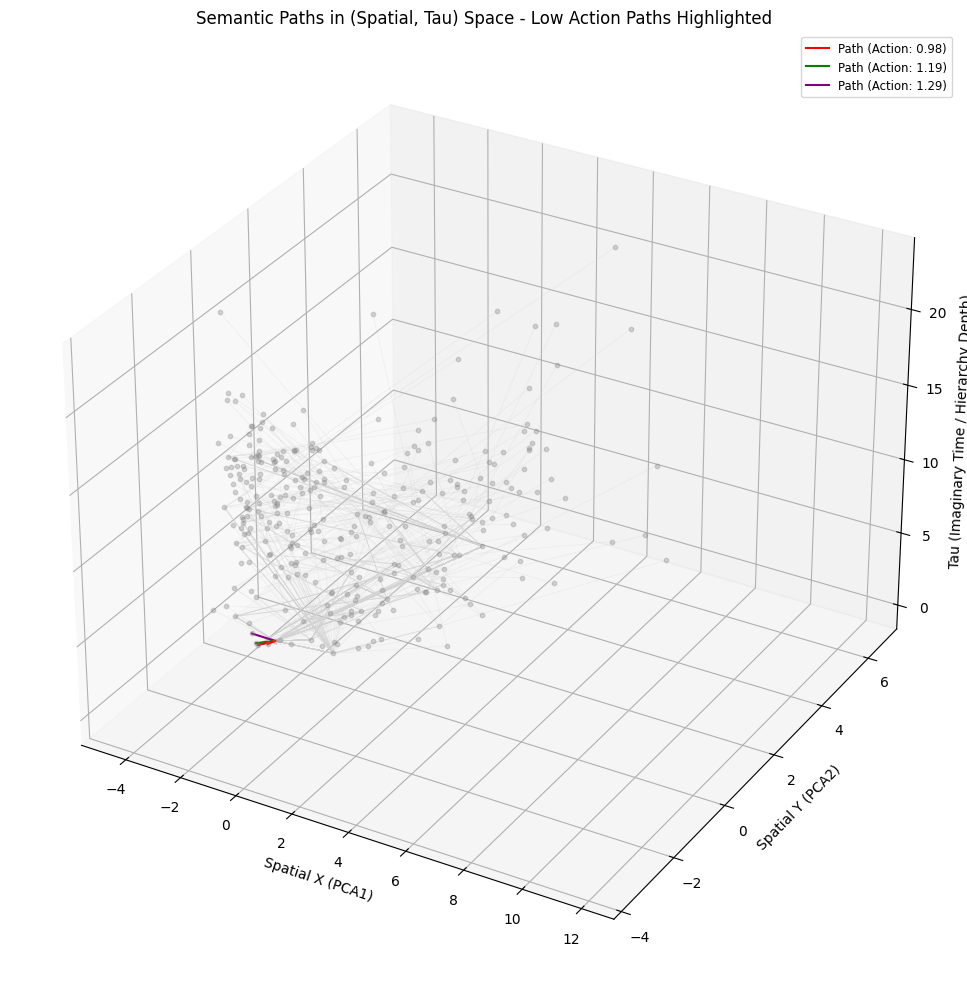

In [ ]:
#@title Using the Eclidean Distance to connect concepts
# =================  Set Parameters ==========================
spatial_dimensions_wn = 2 # (t, x, y)
epsilon_wn = 1e-4
minkowski_coordinates_wn = compute_minkowski_embedding(
        concept_bert_embeddings_wn,
        hierarchy_wn,
        spatial_dimensions_wn,
        epsilon_wn
    )

print("\n=== Euclidean Path Integral Analogy Demo ===")
if not minkowski_coordinates_wn or not hierarchy_wn or not root_wn_name:
    print("Required data (minkowski_coordinates_wn, hierarchy_wn, root_wn_name) not found. Skipping this demo.")
    # exit() # or skip this block in Colab
    pass
else:
    # --- 1. Re-interpret t as τ and prepare data ---------------------------------------------------------------
    # Our coordinates are already [t, x, y, ...] so t is coords[0]
    # We will call it tau for clarity in this context.
    # Build an adjacency list for easier path traversal (children of a parent)
    parent_to_children_map = defaultdict(list)
    # And child to parent for finding leaves quickly (or just check who is not a parent)
    is_parent_map = defaultdict(bool)

    for child, parent in hierarchy_wn:
        if parent is not None:
            parent_to_children_map[parent].append(child)
            is_parent_map[parent] = True
        # else: child is a root
    all_nodes_in_paths = set(minkowski_coordinates_wn.keys())
    leaf_nodes = [node for node in all_nodes_in_paths if not parent_to_children_map[node]]
    print(f"Root for path analysis: {root_wn_name}")
    print(f"Identified {len(leaf_nodes)} leaf nodes (e.g., {leaf_nodes[:3]}...).")

    # --- 2. Function to find all paths from root to a leaf ---
    def find_all_paths(graph_adj, start_node, end_node, path=None):
        if path is None:
            path = []
        path = path + [start_node]
        if start_node == end_node:
            return [path]
        if start_node not in graph_adj:
            return []
        paths = []
        for neighbor in graph_adj[start_node]:
            if neighbor not in path: # Avoid cycles (should not happen in DAG)
                new_paths = find_all_paths(graph_adj, neighbor, end_node, path)
                for new_path in new_paths:
                    paths.append(new_path)
        return paths

    all_root_to_leaf_paths = []
    for leaf in leaf_nodes:
        if root_wn_name in minkowski_coordinates_wn and leaf in minkowski_coordinates_wn:
            # Need to reverse hierarchy for path finding from root (parent -> children)
            paths_to_leaf = find_all_paths(parent_to_children_map, root_wn_name, leaf)
            all_root_to_leaf_paths.extend(paths_to_leaf)

    print(f"Found {len(all_root_to_leaf_paths)} paths from root to various leaves.")

    # --- 3. Define and Calculate "Euclidean Action" Analogue for each path --------------------------------------
    path_actions = []

    def calculate_euclidean_action_proxy(path_nodes, coordinates):
        action = 0.0
        if len(path_nodes) < 2:
            return 0.0 # Or some default for single-node paths

        for i in range(len(path_nodes) - 1):
            node1_name = path_nodes[i]
            node2_name = path_nodes[i+1]

            if node1_name not in coordinates or node2_name not in coordinates:
                # print(f"Warning: Node missing in coordinates for action calc: {node1_name} or {node2_name}")
                return float('inf') # Penalize paths with missing nodes

            coord1 = np.array(coordinates[node1_name])
            coord2 = np.array(coordinates[node2_name])

            tau1, spatial1 = coord1[0], coord1[1:]
            tau2, spatial2 = coord2[0], coord2[1:]

            delta_tau = tau2 - tau1
            delta_spatial_sq = np.sum((spatial2 - spatial1)**2)

            if delta_tau <= 1e-7: # Avoid division by zero or very small tau step
                # If tau doesn't change but spatial does, it's "infinite action" in this simple model
                action += float('inf') if delta_spatial_sq > 1e-7 else 0
            else:
                # Simplified action: sum of (spatial_change_sq / time_change)
                # This penalizes large spatial jumps over small "tau" intervals
                action += delta_spatial_sq / delta_tau
        return action

    for path in all_root_to_leaf_paths:
        action = calculate_euclidean_action_proxy(path, minkowski_coordinates_wn)
        if action != float('inf'):
            path_actions.append({"path": path, "action": action})
            # print(f"Path: {' -> '.join(path)}, Action: {action:.4f}")

    # Sort paths by action (lower is "more probable" / "less effort")
    if path_actions:
        path_actions.sort(key=lambda x: x["action"])
        print("\nTop 5 Paths with Minimum 'Euclidean Action' Proxy:")
        for item in path_actions[:5]:
            print(f"  Action: {item['action']:.4f} - Path: {' -> '.join(item['path'])}")
    else:
        print("No valid paths found to calculate actions for.")


    # --- 4. Visualization of Paths in (x, y, τ) Space -----------------------------------------------------------------
    # We will plot all found paths, and highlight a few "low action" paths.
    if minkowski_coordinates_wn and (spatial_dimensions_wn == 2 or spatial_dimensions_wn == 1) and len(all_root_to_leaf_paths) > 0:
        print("\nVisualizing Semantic Paths in (Spatial, Tau) Space...")
        fig_paths = plt.figure(figsize=(12,10))

        if spatial_dimensions_wn == 2:
            ax_paths = fig_paths.add_subplot(111, projection='3d')
            ax_paths.set_xlabel("Spatial X (PCA1)")
            ax_paths.set_ylabel("Spatial Y (PCA2)")
            ax_paths.set_zlabel("Tau (Imaginary Time / Hierarchy Depth)")
            coord_indices = (1, 2, 0) # x, y, tau(t)
        elif spatial_dimensions_wn == 1:
            ax_paths = fig_paths.add_subplot(111)
            ax_paths.set_xlabel("Spatial X (PCA1)")
            ax_paths.set_ylabel("Tau (Imaginary Time / Hierarchy Depth)")
            coord_indices = (1, 0) # x, tau(t)
        else:
            print("Cannot visualize paths for current spatial_dimensions_wn.")
            # exit()

        # Plot all nodes once for context
        all_path_plot_nodes = set(n for p in all_root_to_leaf_paths for n in p)
        for node_name in all_path_plot_nodes:
            if node_name in minkowski_coordinates_wn:
                coords = minkowski_coordinates_wn[node_name]
                if spatial_dimensions_wn == 2:
                    ax_paths.scatter(coords[coord_indices[0]], coords[coord_indices[1]], coords[coord_indices[2]],
                                     color='gray', alpha=0.3, s=10)
                    if len(all_path_plot_nodes) < 40: # Label if not too cluttered
                         ax_paths.text(coords[coord_indices[0]], coords[coord_indices[1]], coords[coord_indices[2]],
                                      f" {node_name}", fontsize=7, alpha=0.5)
                elif spatial_dimensions_wn == 1:
                    ax_paths.scatter(coords[coord_indices[0]], coords[coord_indices[1]],
                                     color='gray', alpha=0.3, s=10)
                    if len(all_path_plot_nodes) < 40:
                         ax_paths.text(coords[coord_indices[0]], coords[coord_indices[1]],
                                      f" {node_name}", fontsize=7, alpha=0.5)


        # Plot paths: all paths in light color, low action paths highlighted
        num_paths_to_highlight = min(3, len(path_actions))
        highlight_colors = ['red', 'green', 'purple']

        for i, item in enumerate(path_actions):
            path_nodes = item["path"]
            path_coords_list = []
            valid_path = True
            for node_name in path_nodes:
                if node_name in minkowski_coordinates_wn:
                    path_coords_list.append(minkowski_coordinates_wn[node_name])
                else:
                    valid_path = False
                    break

            if not valid_path or len(path_coords_list) < 2 : continue

            path_coords_np = np.array(path_coords_list)

            line_color = highlight_colors[i % num_paths_to_highlight] if i < num_paths_to_highlight else 'lightgray'
            line_alpha = 1.0 if i < num_paths_to_highlight else 0.3
            line_width = 1.5 if i < num_paths_to_highlight else 0.5
            z_order = 10 - i if i < num_paths_to_highlight else 1


            plot_args_path = []
            for idx_dim in range(len(coord_indices)): # For x,y,t or x,t
                actual_coord_idx = coord_indices[idx_dim]
                plot_args_path.append(path_coords_np[:, actual_coord_idx])

            if spatial_dimensions_wn == 2:
                ax_paths.plot(*plot_args_path, color=line_color, alpha=line_alpha, linewidth=line_width, zorder=z_order,
                              label=f"Path (Action: {item['action']:.2f})" if i < num_paths_to_highlight else None)
            elif spatial_dimensions_wn == 1:
                 ax_paths.plot(*plot_args_path, color=line_color, alpha=line_alpha, linewidth=line_width, zorder=z_order,
                               label=f"Path (Action: {item['action']:.2f})" if i < num_paths_to_highlight else None)


        if num_paths_to_highlight > 0 and any(pa['action'] != float('inf') for pa in path_actions):
            ax_paths.legend(fontsize='small')
        plt.title("Semantic Paths in (Spatial, Tau) Space - Low Action Paths Highlighted")
        plt.tight_layout()
        plt.show()

    else:
        print("Cannot visualize: Missing coordinates, spatial dimensions not 1 or 2, or no paths found.")


=== Euclidean Path Integral Analogy with Semantic Potential Demo ===

Top 5 Paths with 'Euclidean Action + Semantic Potential' (W_sim=0.5):
  Action: 1.0487 - Path: mammal -> placental -> bull
    Details for first segment of top path (mammal -> placental):
      from: mammal
      to: placental
      d_tau: 0.655
      d_sp_sq: 0.430
      bert_sim: 0.9277571439743042
      kinetic_action: 0.655
      potential_action: 0.0361214280128479
      total_seg_action: 0.691
  Action: 1.2569 - Path: mammal -> placental -> stock
  Action: 1.3640 - Path: mammal -> placental -> doe
  Action: 1.8240 - Path: mammal -> tusker
  Action: 2.0841 - Path: mammal -> placental -> unguiculate

Searching for 'Instanton-like' Segments in Low-Action Paths...
No clear instanton-like segments found with threshold 0.5 in top 20 paths.

Visualizing Semantic Paths (with Semantic Potential in Action)...


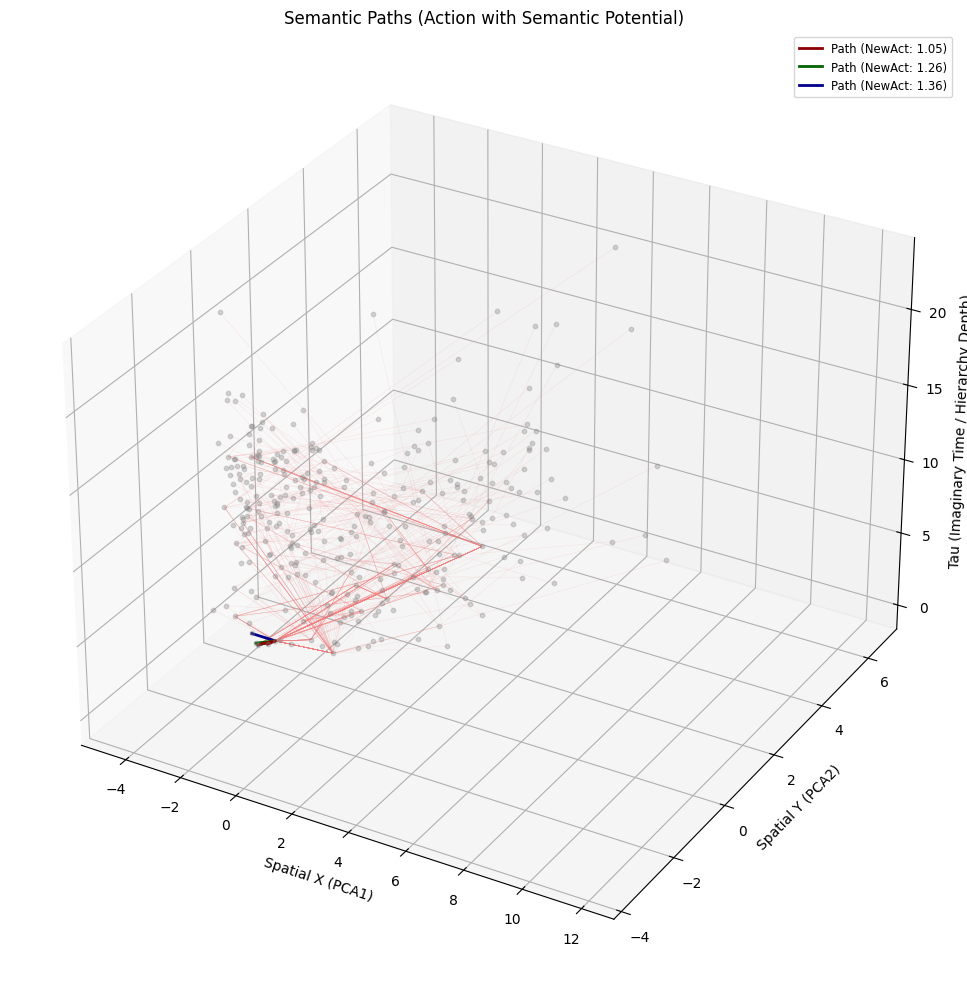

In [ ]:
#@title Using the Eclidean Distance to connect concepts
# =================  Set Parameters ==========================
spatial_dimensions_wn = 2 # (t, x, y)
epsilon_wn = 1e-4
minkowski_coordinates_wn = compute_minkowski_embedding(
        concept_bert_embeddings_wn,
        hierarchy_wn,
        spatial_dimensions_wn,
        epsilon_wn
    )
from sklearn.metrics.pairwise import cosine_similarity # For BERT similarity
print("\n=== Euclidean Path Integral Analogy with Semantic Potential Demo ===")
if not minkowski_coordinates_wn or not hierarchy_wn or not root_wn_name or \
   not concept_bert_embeddings_wn or 'parent_to_children_map' not in globals() or \
   'all_root_to_leaf_paths' not in globals():
    print("Required data not found from previous steps. Skipping this demo.")
    # exit()
    pass
else:
    # --- 1. Define a new "Euclidean Action" incorporating BERT similarity ------------------------------
    # This action penalizes both spatial "jerkiness" and traversing
    # links between concepts that BERT considers dissimilar.
    # Weight for the similarity penalty in the action
    # If the same meanings hold for higher values then it means the semantics are robust.
    W_SIMILARITY_PENALTY = 0.5 # Tune this: higher means more penalty for low BERT sim
    path_actions_v2 = []
    def calculate_euclidean_action_with_potential(path_nodes, coordinates, bert_embeddings):
        action = 0.0
        if len(path_nodes) < 2:
            return 0.0

        path_segment_details = []

        for i in range(len(path_nodes) - 1):
            node1_name = path_nodes[i]
            node2_name = path_nodes[i+1]

            if node1_name not in coordinates or node2_name not in coordinates or \
               node1_name not in bert_embeddings or node2_name not in bert_embeddings:
                return float('inf'), [] # Path is invalid if nodes are missing

            coord1 = np.array(coordinates[node1_name])
            coord2 = np.array(coordinates[node2_name])
            bert1 = np.array(bert_embeddings[node1_name]).reshape(1, -1)
            bert2 = np.array(bert_embeddings[node2_name]).reshape(1, -1)

            tau1, spatial1 = coord1[0], coord1[1:]
            tau2, spatial2 = coord2[0], coord2[1:]

            delta_tau = tau2 - tau1
            delta_spatial_sq = np.sum((spatial2 - spatial1)**2)

            bert_sim = cosine_similarity(bert1, bert2)[0, 0]
            # Ensure similarity is between -1 and 1 for (1-sim) to be non-negative
            bert_sim = np.clip(bert_sim, -1.0, 1.0)
            similarity_cost = (1.0 - bert_sim) # Higher for dissimilar concepts (max 2)

            segment_action_kinetic = 0
            if delta_tau <= 1e-7:
                segment_action_kinetic = float('inf') if delta_spatial_sq > 1e-7 else 0
            else:
                segment_action_kinetic = delta_spatial_sq / delta_tau

            segment_action_potential = W_SIMILARITY_PENALTY * similarity_cost
            total_segment_action = segment_action_kinetic + segment_action_potential
            action += total_segment_action

            path_segment_details.append({
                "from": node1_name, "to": node2_name,
                "d_tau": delta_tau, "d_sp_sq": delta_spatial_sq,
                "bert_sim": bert_sim, "kinetic_action": segment_action_kinetic,
                "potential_action": segment_action_potential, "total_seg_action": total_segment_action
            })

        return action, path_segment_details

    for path in all_root_to_leaf_paths:
        action, details = calculate_euclidean_action_with_potential(path, minkowski_coordinates_wn, concept_bert_embeddings_wn)
        if action != float('inf'):
            path_actions_v2.append({"path": path, "action": action, "details": details})

    if path_actions_v2:
        path_actions_v2.sort(key=lambda x: x["action"])
        print(f"\nTop 5 Paths with 'Euclidean Action + Semantic Potential' (W_sim={W_SIMILARITY_PENALTY}):")
        for item in path_actions_v2[:5]:
            print(f"  Action: {item['action']:.4f} - Path: {' -> '.join(item['path'])}")
            # Print details for the first segment of the top path for illustration
            if item == path_actions_v2[0] and item['details']:
                print(f"    Details for first segment of top path ({item['details'][0]['from']} -> {item['details'][0]['to']}):")
                for key, val in item['details'][0].items():
                    if isinstance(val, float): print(f"      {key}: {val:.3f}")
                    else: print(f"      {key}: {val}")
    else:
        print("No valid paths found to calculate V2 actions for.")
    # --- 2. Identifying "Instanton-like" Path Segments ---
    # An instanton-like segment might be one with:
    #   a) Low BERT similarity (high "potential barrier" crossed)
    #   b) But its contribution to total path action isn't excessively high, meaning
    #      either delta_tau was large for that segment, or delta_spatial_sq was small.
    #   c) And the overall path action is still relatively low.
    print("\nSearching for 'Instanton-like' Segments in Low-Action Paths...")
    instanton_candidates = []
    SIMILARITY_BARRIER_THRESHOLD = 0.5 # BERT similarity below this is a "barrier"
    MAX_PATHS_TO_CHECK = 20 # Check more than just top 5

    for item in path_actions_v2[:MAX_PATHS_TO_CHECK]:
        for segment in item['details']:
            if segment['bert_sim'] < SIMILARITY_BARRIER_THRESHOLD:
                # This segment crossed a "semantic potential barrier"
                # If its individual segment action is not too high, and path action is low, it's a candidate
                # This definition is heuristic.
                if segment['total_seg_action'] < (item['action'] / (len(item['path'])-1) if len(item['path']) >1 else float('inf')) * 2.0: # Segment action not disproportionately high
                    instanton_candidates.append({
                        "path": " -> ".join(item['path']),
                        "path_action": item['action'],
                        "segment": f"{segment['from']} -> {segment['to']}",
                        "segment_bert_sim": segment['bert_sim'],
                        "segment_action": segment['total_seg_action'],
                        "segment_d_tau": segment['d_tau'],
                        "segment_d_sp_sq": segment['d_sp_sq']
                    })

    if instanton_candidates:
        instanton_candidates.sort(key=lambda x: (x['path_action'], x['segment_bert_sim'])) # Low path action, very low sim
        print(f"Found {len(instanton_candidates)} potential instanton-like segments crossing similarity < {SIMILARITY_BARRIER_THRESHOLD}.")
        print("Top 3 Candidates (Low Path Action, Low Segment BERT Sim but reasonable segment action):")
        for cand in instanton_candidates[:3]:
            print(f"  Path (Action {cand['path_action']:.2f}): {cand['path']}")
            print(f"    Segment: {cand['segment']} (Sim: {cand['segment_bert_sim']:.2f}, SegAct: {cand['segment_action']:.2f}, dτ: {cand['segment_d_tau']:.2f}, dX²: {cand['segment_d_sp_sq']:.2f})")
    else:
        print(f"No clear instanton-like segments found with threshold {SIMILARITY_BARRIER_THRESHOLD} in top {MAX_PATHS_TO_CHECK} paths.")

    # --- 3. Visualization (can reuse previous path visualization code) ---
    # Highlight paths containing instanton-like segments, or simply the new top paths.
    # For this demo, we'll just highlight the new top paths based on action_v2.

    if minkowski_coordinates_wn and (spatial_dimensions_wn == 2 or spatial_dimensions_wn == 1) and len(path_actions_v2) > 0:
        print("\nVisualizing Semantic Paths (with Semantic Potential in Action)...")
        fig_paths_v2 = plt.figure(figsize=(12,10))

        if spatial_dimensions_wn == 2:
            ax_paths_v2 = fig_paths_v2.add_subplot(111, projection='3d')
            ax_paths_v2.set_xlabel("Spatial X (PCA1)")
            ax_paths_v2.set_ylabel("Spatial Y (PCA2)")
            ax_paths_v2.set_zlabel("Tau (Imaginary Time / Hierarchy Depth)")
            coord_indices = (1, 2, 0) # x, y, tau(t)
        elif spatial_dimensions_wn == 1:
            ax_paths_v2 = fig_paths_v2.add_subplot(111)
            ax_paths_v2.set_xlabel("Spatial X (PCA1)")
            ax_paths_v2.set_ylabel("Tau (Imaginary Time / Hierarchy Depth)")
            coord_indices = (1, 0) # x, tau(t)
        else:
            print("Cannot visualize paths for current spatial_dimensions_wn.")
            # exit()

        all_plot_nodes_v2 = set(n for item in path_actions_v2 for n in item["path"])
        for node_name in all_plot_nodes_v2:
            if node_name in minkowski_coordinates_wn:
                coords = minkowski_coordinates_wn[node_name]
                # Plotting logic as before...
                if spatial_dimensions_wn == 2:
                    ax_paths_v2.scatter(coords[coord_indices[0]], coords[coord_indices[1]], coords[coord_indices[2]],
                                     color='gray', alpha=0.3, s=10)
                    if len(all_plot_nodes_v2) < 40 :
                         ax_paths_v2.text(coords[coord_indices[0]], coords[coord_indices[1]], coords[coord_indices[2]],
                                      f" {node_name}", fontsize=7, alpha=0.5)
                elif spatial_dimensions_wn == 1:
                    ax_paths_v2.scatter(coords[coord_indices[0]], coords[coord_indices[1]],
                                     color='gray', alpha=0.3, s=10)
                    if len(all_plot_nodes_v2) < 40:
                         ax_paths_v2.text(coords[coord_indices[0]], coords[coord_indices[1]],
                                      f" {node_name}", fontsize=7, alpha=0.5)

        num_paths_to_highlight_v2 = min(3, len(path_actions_v2))
        highlight_colors_v2 = ['darkred', 'darkgreen', 'darkblue']

        for i, item in enumerate(path_actions_v2): # Use path_actions_v2
            path_nodes = item["path"]
            path_coords_list = [minkowski_coordinates_wn[n] for n in path_nodes if n in minkowski_coordinates_wn]
            if len(path_coords_list) != len(path_nodes) or len(path_coords_list) < 2: continue
            path_coords_np = np.array(path_coords_list)

            line_color = highlight_colors_v2[i % num_paths_to_highlight_v2] if i < num_paths_to_highlight_v2 else 'lightcoral'
            line_alpha = 1.0 if i < num_paths_to_highlight_v2 else 0.2
            line_width = 2.0 if i < num_paths_to_highlight_v2 else 0.3 # Thicker highlights
            z_order = 10 - i if i < num_paths_to_highlight_v2 else 1

            plot_args_path = []
            for idx_dim in range(len(coord_indices)):
                actual_coord_idx = coord_indices[idx_dim]
                plot_args_path.append(path_coords_np[:, actual_coord_idx])

            if spatial_dimensions_wn == 2:
                ax_paths_v2.plot(*plot_args_path, color=line_color, alpha=line_alpha, linewidth=line_width, zorder=z_order,
                              label=f"Path (NewAct: {item['action']:.2f})" if i < num_paths_to_highlight_v2 else None)
            elif spatial_dimensions_wn == 1:
                 ax_paths_v2.plot(*plot_args_path, color=line_color, alpha=line_alpha, linewidth=line_width, zorder=z_order,
                               label=f"Path (NewAct: {item['action']:.2f})" if i < num_paths_to_highlight_v2 else None)


        if num_paths_to_highlight_v2 > 0 and any(pa['action'] != float('inf') for pa in path_actions_v2):
            ax_paths_v2.legend(fontsize='small')
        plt.title("Semantic Paths (Action with Semantic Potential)")
        plt.tight_layout()
        plt.show()

In [ ]:
# @title helper function for k-nearest neighbors.
from sklearn.metrics.pairwise import euclidean_distances # For option 1 & 3

def find_k_nearest_concepts(target_concept_name: str,
                            all_coordinates: dict[str, list[float]],
                            k: int,
                            distance_type: str = "spacetime_euclidean"):
    """
    Finds the k-nearest concepts to a target concept in the embedded space.

    Args:
        target_concept_name: The name of the concept to find neighbors for.
        all_coordinates: Dictionary of {name: [tau, x, y,...]} coordinates.
        k: The number of nearest neighbors to find.
        distance_type:
            "spacetime_euclidean": Euclidean distance in the full (tau, x, y,...) space.
            "spatial_only_euclidean": Euclidean distance in only the spatial (x, y,...) dimensions.
    Returns:
        A list of tuples (concept_name, distance), sorted by distance.
    """
    if target_concept_name not in all_coordinates:
        print(f"Error: Target concept '{target_concept_name}' not found in coordinates.")
        return []

    target_coord_full = np.array(all_coordinates[target_concept_name])

    if distance_type == "spatial_only_euclidean":
        if len(target_coord_full) <= 1: # Only tau, no spatial dimensions
            print("Warning: Cannot compute spatial_only distance with 0 spatial dimensions.")
            return []
        target_coord_slice = target_coord_full[1:].reshape(1, -1) # Spatial part only
    elif distance_type == "spacetime_euclidean":
        target_coord_slice = target_coord_full.reshape(1, -1) # Full (tau, x, y,...)
    else:
        print(f"Error: Unknown distance_type '{distance_type}'.")
        return []

    neighbors = []
    for name, coord_full_list in all_coordinates.items():
        if name == target_concept_name:
            continue

        coord_full = np.array(coord_full_list)

        if distance_type == "spatial_only_euclidean":
            if len(coord_full) <= 1: continue # Skip if no spatial dimensions for this point
            coord_slice = coord_full[1:].reshape(1, -1)
        else: # spacetime_euclidean
            coord_slice = coord_full.reshape(1, -1)

        # Ensure dimensions match for distance calculation
        if coord_slice.shape[1] != target_coord_slice.shape[1]:
            # This might happen if some concepts have different coord lengths due to an error
            # print(f"Warning: Dimension mismatch for {name}. Skipping.")
            continue

        dist = euclidean_distances(target_coord_slice, coord_slice)[0, 0]
        neighbors.append((name, dist))

    # Sort by distance and take top k
    neighbors.sort(key=lambda x: x[1])
    return neighbors[:k]



--- K-Nearest Concepts Demo ---

Finding 5-nearest concepts to 'dog':

Nearest in (Tau, X, Y,...) Euclidean space (hierarchical + semantic similarity):
  - wolf (Distance: 0.6794)
  - badger (Distance: 0.7498)
  - skunk (Distance: 1.2386)
  - potto (Distance: 1.2502)
  - marten (Distance: 1.2552)

Nearest in Spatial (X, Y,...) Euclidean space (pure semantic similarity at any depth):
  - vampire bat (Distance: 0.3382)
  - mouse (Distance: 0.4863)
  - elephant (Distance: 0.4932)
  - pocket rat (Distance: 0.4933)
  - rogue elephant (Distance: 0.5296)

Attempting semantic navigation from 'mammal' to 'gomphothere'.

Starting A* search from 'mammal' to 'gomphothere'...
Goal 'gomphothere' reached! Path cost (g_score): 12.9211
True directional action of path: 12.9211

--- Navigation Result ---
Lowest 'action' path from 'mammal' to 'gomphothere':
  Path: mammal -> placental -> proboscidean -> elephant -> gomphothere
  Associated Action: 12.9211


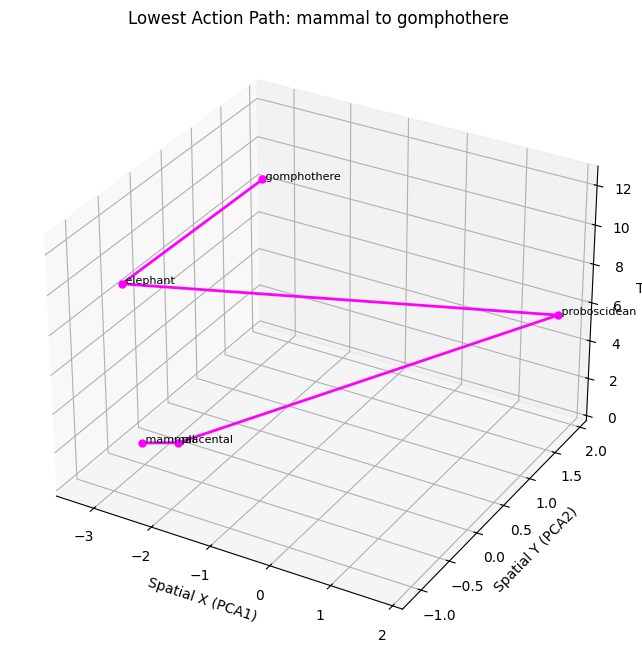

In [ ]:
#@title # --- Rebuild child_to_parent_map if necessary for bi-directional search ---
# Or, more generally, an adjacency list for all connections
# For this demo, let's build a general adjacency list (neighbors)
adjacency_list = defaultdict(list)
if 'hierarchy_wn' in globals() and hierarchy_wn: # Check if hierarchy_wn is defined
    processed_edges = set()
    for child, parent in hierarchy_wn:
        if parent is not None:
            # Ensure we don't add duplicate edges if hierarchy_wn has them
            if (parent, child) not in processed_edges:
                adjacency_list[parent].append(child)
                processed_edges.add((parent,child))
            if (child, parent) not in processed_edges: # For A*, allow going "up" the hierarchy too
                adjacency_list[child].append(parent)
                processed_edges.add((child, parent))
else:
    print("Warning: `hierarchy_wn` not found or empty. Navigation will be limited.")
    # Populate adjacency_list from parent_to_children_map if it exists
    if 'parent_to_children_map' in globals():
        for parent, children in parent_to_children_map.items():
            for child in children:
                adjacency_list[parent].append(child)
                adjacency_list[child].append(parent) # Bidirectional for search

# --- Ensure action calculation function is available ---
# def calculate_euclidean_action_with_potential(path_nodes, coordinates, bert_embeddings): ...
# For A*, we need to calculate cost of a single step, not a whole path.

def calculate_step_action(node1_name, node2_name, coordinates, bert_embeddings):
    """Calculates the action for a single step from node1 to node2."""
    if node1_name not in coordinates or node2_name not in coordinates or \
       node1_name not in bert_embeddings or node2_name not in bert_embeddings:
        return float('inf') # Cannot traverse

    coord1 = np.array(coordinates[node1_name])
    coord2 = np.array(coordinates[node2_name])
    bert1 = np.array(bert_embeddings[node1_name]).reshape(1, -1)
    bert2 = np.array(bert_embeddings[node2_name]).reshape(1, -1)

    tau1, spatial1 = coord1[0], coord1[1:]
    tau2, spatial2 = coord2[0], coord2[1:]

    delta_tau = tau2 - tau1 # This can be negative if going "up" the hierarchy
    delta_spatial_sq = np.sum((spatial2 - spatial1)**2)

    bert_sim = cosine_similarity(bert1, bert2)[0, 0]
    bert_sim = np.clip(bert_sim, -1.0, 1.0)
    similarity_cost = (1.0 - bert_sim)

    segment_action_kinetic = 0
    # If going "backwards in tau", delta_tau is negative.
    # Action should always be positive.
    # Let's define action for going P->C differently from C->P,
    # or use absolute delta_tau and penalize going against hierarchy flow.
    # For now, let's assume forward hierarchical flow (P->C, so delta_tau > 0).
    # A* will find paths, but their "action" interpretation depends on direction.
    # For simplicity, let's make the "effort" symmetric for A* search,
    # but note that true semantic path action is directional.
    abs_delta_tau = abs(delta_tau)
    if abs_delta_tau <= 1e-7:
        segment_action_kinetic = float('inf') if delta_spatial_sq > 1e-7 else 0
    else:
        # We will use abs_delta_tau for cost calculation for A* to make it symmetric.
        # The "true" action of the final path should be recalculated directionally.
        segment_action_kinetic = delta_spatial_sq / abs_delta_tau

    segment_action_potential = W_SIMILARITY_PENALTY * similarity_cost
    return segment_action_kinetic + segment_action_potential


def a_star_semantic_search(start_node, goal_node, adj_list, coordinates, bert_embeddings):
    if start_node not in coordinates or goal_node not in coordinates:
        print(f"Error: Start ({start_node}) or Goal ({goal_node}) node not in coordinates.")
        return None, float('inf')

    # Priority queue: (f_score, g_score, current_node, path_list)
    # f_score = g_score + h_score
    # g_score = cost from start to current_node
    open_set = [(0, 0, start_node, [start_node])]
    heapq.heapify(open_set)

    # For heuristic, use spatial Euclidean distance in PCA space to goal
    # This doesn't account for tau, but is a simple start.
    def heuristic(node_name, goal_name):
        if node_name not in coordinates or goal_name not in coordinates or spatial_dimensions_wn == 0:
            return 0
        coord_node = np.array(coordinates[node_name][1:]) # Spatial part
        coord_goal = np.array(coordinates[goal_name][1:]) # Spatial part
        return np.sqrt(np.sum((coord_node - coord_goal)**2))

    # Keep track of visited nodes and g_scores to avoid cycles and redundant exploration
    g_scores = {node: float('inf') for node in adj_list}
    g_scores[start_node] = 0

    print(f"\nStarting A* search from '{start_node}' to '{goal_node}'...")

    path_count = 0
    while open_set:
        path_count +=1
        if path_count > 50000: # Safety break for large graphs
            print("A* search exceeded max path explorations.")
            return None, float('inf')

        f_score_curr, g_score_curr, current_node, path = heapq.heappop(open_set)

        if current_node == goal_node:
            print(f"Goal '{goal_node}' reached! Path cost (g_score): {g_score_curr:.4f}")
            # Recalculate "true" directional action for the found path
            true_action, _ = calculate_euclidean_action_with_potential(path, coordinates, bert_embeddings)
            print(f"True directional action of path: {true_action:.4f}")
            return path, true_action

        # Explore neighbors
        for neighbor in adj_list.get(current_node, []):
            # Cost to move from current_node to neighbor
            # A* needs a consistent cost for g_score. We use the symmetric step action.
            step_cost = calculate_step_action(current_node, neighbor, coordinates, bert_embeddings)

            if step_cost == float('inf'): # Un traversable edge
                continue

            tentative_g_score = g_score_curr + step_cost

            if tentative_g_score < g_scores.get(neighbor, float('inf')):
                g_scores[neighbor] = tentative_g_score
                h_score_neighbor = heuristic(neighbor, goal_node)
                f_score_neighbor = tentative_g_score + h_score_neighbor
                new_path = path + [neighbor]
                heapq.heappush(open_set, (f_score_neighbor, tentative_g_score, neighbor, new_path))

    print(f"Goal '{goal_node}' not reachable from '{start_node}'.")
    return None, float('inf')

# K nearest concepts
if 'minkowski_coordinates_wn' in globals() and minkowski_coordinates_wn:
    print("\n\n--- K-Nearest Concepts Demo ---")

    # Concept to find neighbors for (e.g., the goal of our A* search, or any other concept)
    concept_to_query = 'dog' # Example, change as needed
    if 'nav_goal_node' in globals() and nav_goal_node and nav_goal_node in minkowski_coordinates_wn:
        concept_to_query = nav_goal_node # Use the goal from A* if available
    elif concept_to_query not in minkowski_coordinates_wn and minkowski_coordinates_wn:
        concept_to_query = list(minkowski_coordinates_wn.keys())[len(minkowski_coordinates_wn)//2] # Pick a middle concept

    num_neighbors = 5

    if concept_to_query in minkowski_coordinates_wn:
        print(f"\nFinding {num_neighbors}-nearest concepts to '{concept_to_query}':")

        # 1. Using Euclidean distance in the full (tau, X, Y,...) space
        nearest_spacetime = find_k_nearest_concepts(
            concept_to_query,
            minkowski_coordinates_wn,
            num_neighbors,
            distance_type="spacetime_euclidean"
        )
        print("\nNearest in (Tau, X, Y,...) Euclidean space (hierarchical + semantic similarity):")
        if nearest_spacetime:
            for name, dist in nearest_spacetime:
                print(f"  - {name} (Distance: {dist:.4f})")
        else:
            print("  No neighbors found or error in calculation.")

        # 2. Using Euclidean distance in only the spatial (X, Y,...) dimensions
        if spatial_dimensions_wn > 0: # Only if there are spatial dimensions
            nearest_spatial = find_k_nearest_concepts(
                concept_to_query,
                minkowski_coordinates_wn,
                num_neighbors,
                distance_type="spatial_only_euclidean"
            )
            print("\nNearest in Spatial (X, Y,...) Euclidean space (pure semantic similarity at any depth):")
            if nearest_spatial:
                for name, dist in nearest_spatial:
                    print(f"  - {name} (Distance: {dist:.4f})")
            else:
                print("  No neighbors found or error in calculation (or no spatial dimensions).")
        else:
            print("\nSkipping spatial-only nearest neighbors (0 spatial dimensions).")

    else:
        print(f"Cannot find k-nearest concepts: '{concept_to_query}' not in coordinate data.")
else:
    print("\nSkipping K-Nearest Concepts Demo: Minkowski coordinates not available.")


# --- Demo Navigation ---
if 'minkowski_coordinates_wn' in globals() and minkowski_coordinates_wn:
    # Pick a start and end node for navigation
    # For this demo, let's try to navigate from a high-level concept to a more specific one.
    # Ensure these nodes exist in your current WordNet subset.

    # Find a root and a leaf from the actual data for a meaningful test
    nav_start_node = None
    nav_goal_node = None

    if 'root_wn_name' in globals() and root_wn_name and root_wn_name in minkowski_coordinates_wn:
        nav_start_node = root_wn_name
    elif minkowski_coordinates_wn: # Pick first available if no explicit root
        nav_start_node = list(minkowski_coordinates_wn.keys())[0]

    # Find a leaf node (a node that is not a parent to any other node in minkowski_coordinates_wn)
    potential_parents_in_coords = set()
    if 'hierarchy_wn' in globals() and hierarchy_wn:
        for child, parent in hierarchy_wn:
            if parent is not None and parent in minkowski_coordinates_wn:
                potential_parents_in_coords.add(parent)

    available_leaves = [n for n in minkowski_coordinates_wn.keys() if n not in potential_parents_in_coords]
    if available_leaves:
        nav_goal_node = random.choice(available_leaves)
        # Ensure start and goal are not the same if possible
        if nav_start_node == nav_goal_node and len(available_leaves) > 1:
            temp_leaves = [l for l in available_leaves if l != nav_start_node]
            if temp_leaves:
                nav_goal_node = random.choice(temp_leaves)

    if nav_start_node and nav_goal_node and nav_start_node != nav_goal_node:
        print(f"\nAttempting semantic navigation from '{nav_start_node}' to '{nav_goal_node}'.")

        optimal_path, optimal_action = a_star_semantic_search(
            nav_start_node,
            nav_goal_node,
            adjacency_list,
            minkowski_coordinates_wn,
            concept_bert_embeddings_wn
        )

        if optimal_path:
            print("\n--- Navigation Result ---")
            print(f"Lowest 'action' path from '{nav_start_node}' to '{nav_goal_node}':")
            print(f"  Path: {' -> '.join(optimal_path)}")
            print(f"  Associated Action: {optimal_action:.4f}")

            # Visualize this specific path (optional, can be complex if too many nodes)
            if (spatial_dimensions_wn == 2 or spatial_dimensions_wn == 1) and len(optimal_path) > 1 :
                fig_nav = plt.figure(figsize=(10,8))
                path_coords_list_nav = [minkowski_coordinates_wn[n] for n in optimal_path if n in minkowski_coordinates_wn]
                if len(path_coords_list_nav) == len(optimal_path): # All nodes found
                    path_coords_np_nav = np.array(path_coords_list_nav)

                    if spatial_dimensions_wn == 2:
                        ax_nav = fig_nav.add_subplot(111, projection='3d')
                        ax_nav.set_xlabel("Spatial X (PCA1)")
                        ax_nav.set_ylabel("Spatial Y (PCA2)")
                        ax_nav.set_zlabel("Tau")
                        coord_indices_nav = (1,2,0)
                        ax_nav.plot(path_coords_np_nav[:,coord_indices_nav[0]], path_coords_np_nav[:,coord_indices_nav[1]], path_coords_np_nav[:,coord_indices_nav[2]],
                                    marker='o', linestyle='-', color='magenta', linewidth=2, markersize=5)
                        for i, node_name in enumerate(optimal_path):
                             ax_nav.text(path_coords_np_nav[i,coord_indices_nav[0]], path_coords_np_nav[i,coord_indices_nav[1]], path_coords_np_nav[i,coord_indices_nav[2]],
                                         f" {node_name}", fontsize=8, color='black')
                    elif spatial_dimensions_wn == 1:
                        ax_nav = fig_nav.add_subplot(111)
                        ax_nav.set_xlabel("Spatial X (PCA1)")
                        ax_nav.set_ylabel("Tau")
                        coord_indices_nav = (1,0)
                        ax_nav.plot(path_coords_np_nav[:,coord_indices_nav[0]], path_coords_np_nav[:,coord_indices_nav[1]],
                                    marker='o', linestyle='-', color='magenta', linewidth=2, markersize=5)
                        for i, node_name in enumerate(optimal_path):
                             ax_nav.text(path_coords_np_nav[i,coord_indices_nav[0]], path_coords_np_nav[i,coord_indices_nav[1]],
                                         f" {node_name}", fontsize=8, color='black')

                    plt.title(f"Lowest Action Path: {nav_start_node} to {nav_goal_node}")
                    plt.show()
        else:
            print(f"No path found between '{nav_start_node}' and '{nav_goal_node}'.")
    else:
        print("\nCould not set up a valid start and goal node for navigation demo from the current data.")

else:
    print("Minkowski coordinates not available. Skipping navigation demo.")

=== Stock Price Analysis with Euclidean Action Analogue ===
   Timestamp       Price  Tau
0 2023-01-02  150.000000    0
1 2023-01-03  135.233209    1
2 2023-01-04  180.965777    2
3 2023-01-05  174.817187    3
4 2023-01-06  185.521959    4

Generated 181 paths of window size 20.

Top 5 Paths with Minimum 'Euclidean Action' (Low Volatility/Change per unit Time):
  Path ID 179 (Tau 249-276), Action: 217.7634
  Path ID 180 (Tau 252-277), Action: 220.9132
  Path ID 178 (Tau 248-275), Action: 233.8884
  Path ID 177 (Tau 247-274), Action: 238.3946
  Path ID 176 (Tau 246-273), Action: 246.5940

Top 5 Paths with Maximum 'Euclidean Action' (High Volatility/Change per unit Time):
  Path ID 77 (Tau 107-134), Action: 173727.5351
  Path ID 76 (Tau 106-133), Action: 171638.0764
  Path ID 74 (Tau 102-129), Action: 170695.1110
  Path ID 75 (Tau 105-130), Action: 170612.1106
  Path ID 78 (Tau 108-135), Action: 164659.0282


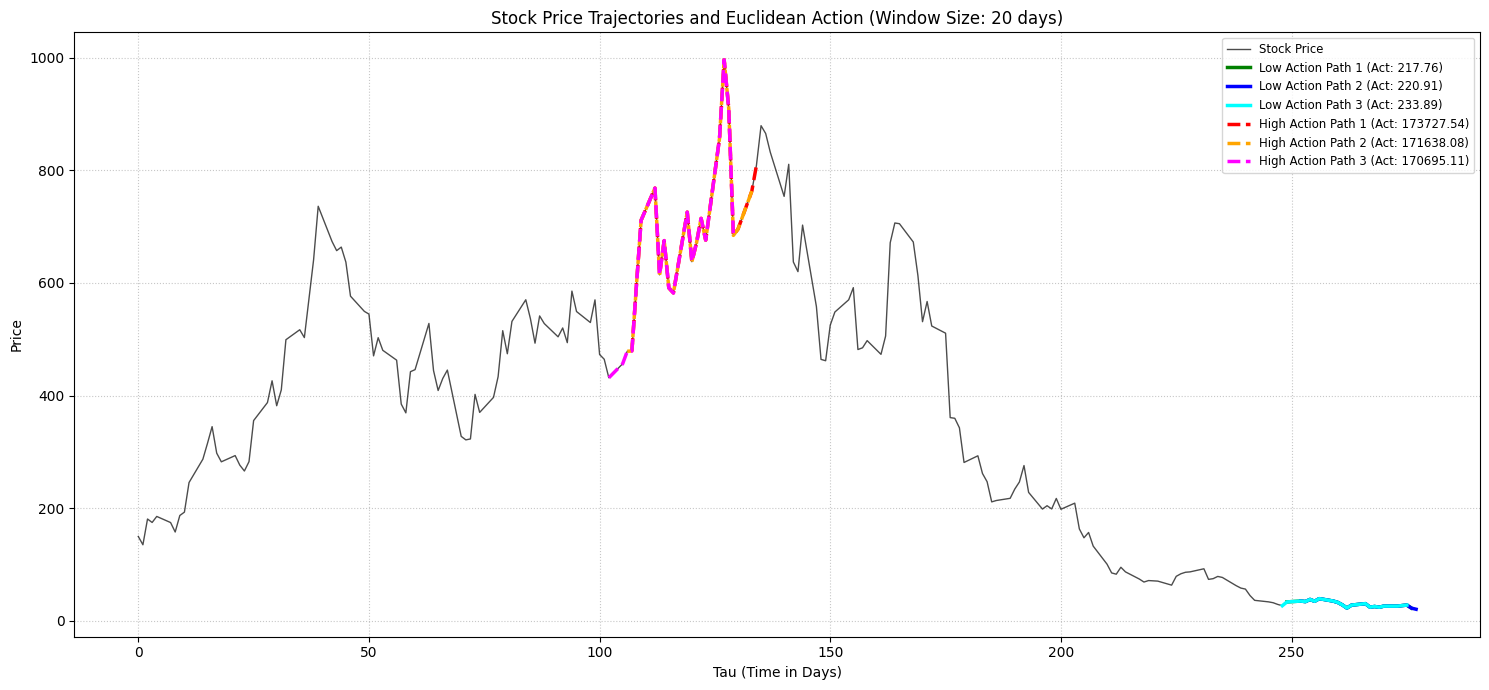

In [ ]:
#@title --- We can learn more than just word data! -----------------------------------
def generate_stock_data(days=100, start_price=100, volatility=1.0, drift=0.05):
    """Generates simple random walk based stock data."""
    dates = pd.date_range(start='2023-01-01', periods=days, freq='B') # Business days
    prices = [start_price]
    for _ in range(1, days):
        daily_return = np.random.normal(loc=drift/252, scale=volatility/np.sqrt(252)) # Assuming 252 trading days
        prices.append(prices[-1] * (1 + daily_return))

    df = pd.DataFrame({'Timestamp': dates, 'Price': prices})
    # Convert Timestamp to a numerical representation for tau (e.g., days since start)
    df['Tau'] = (df['Timestamp'] - df['Timestamp'].min()).dt.days
    return df

print("=== Stock Price Analysis with Euclidean Action Analogue ===")
stock_df = generate_stock_data(days=200, start_price=150, volatility=2.0, drift=0.1)
print(stock_df.head())

# Our coordinates: Tau (time in days), X (Price)
# minkowski_coords_stock would be a list of [tau, price] for each day
# For path analysis, we can think of each day's data point as a node.

# --- 2. Define Paths ---
# A path is a sequence of (Tau, Price) points.
# Let's consider paths between local minima and subsequent local maxima,
# or simply fixed-length rolling windows.
# For simplicity, let's analyze fixed-length windows as "processes".

WINDOW_SIZE = 20 # Analyze 20-day paths/processes
stock_paths = []
for i in range(len(stock_df) - WINDOW_SIZE + 1):
    path_df = stock_df.iloc[i : i + WINDOW_SIZE]
    # Path nodes are just indices for simplicity here, actual coords are looked up
    path_indices = list(path_df.index)
    # Store path as list of (tau, price) tuples
    path_coords_list = list(zip(path_df['Tau'].values, path_df['Price'].values))
    stock_paths.append({"indices": path_indices, "coords_list": path_coords_list})

print(f"\nGenerated {len(stock_paths)} paths of window size {WINDOW_SIZE}.")

# --- 3. Calculate "Euclidean Action" for each path ---
# Action for a segment: (ΔPrice)^2 / ΔTau
# Total path action: Sum of segment actions.

path_actions_stock = []

def calculate_stock_path_action(path_coords_list: list[tuple[float, float]]):
    """
    Calculates action for a stock price path.
    Each item in path_coords_list is (tau, price).
    """
    action = 0.0
    if len(path_coords_list) < 2:
        return 0.0

    for i in range(len(path_coords_list) - 1):
        tau1, price1 = path_coords_list[i]
        tau2, price2 = path_coords_list[i+1]

        delta_tau = tau2 - tau1
        delta_price_sq = (price2 - price1)**2

        if delta_tau <= 1e-9: # Should not happen if tau is strictly increasing time
            action += float('inf') if delta_price_sq > 1e-9 else 0
        else:
            action += delta_price_sq / delta_tau # (Volatility per unit time step)^2 * dt
            # This is more like sum of squared velocity, which is related to kinetic energy.
            # A common action is L = T - V. For Euclidean action, it's often T + V.
            # If we consider (dPrice/dTau)^2 as "kinetic", this is sum of "kinetic density".
    return action

for i, path_data in enumerate(stock_paths):
    action = calculate_stock_path_action(path_data["coords_list"])
    path_actions_stock.append({
        "path_id": i,
        "start_tau": path_data["coords_list"][0][0],
        "end_tau": path_data["coords_list"][-1][0],
        "action": action,
        "coords_list": path_data["coords_list"] # Keep coords for plotting
    })

if path_actions_stock:
    path_actions_stock.sort(key=lambda x: x["action"])
    print("\nTop 5 Paths with Minimum 'Euclidean Action' (Low Volatility/Change per unit Time):")
    for item in path_actions_stock[:5]:
        print(f"  Path ID {item['path_id']} (Tau {item['start_tau']}-{item['end_tau']}), Action: {item['action']:.4f}")

    print("\nTop 5 Paths with Maximum 'Euclidean Action' (High Volatility/Change per unit Time):")
    for item in sorted(path_actions_stock, key=lambda x: x["action"], reverse=True)[:5]:
         print(f"  Path ID {item['path_id']} (Tau {item['start_tau']}-{item['end_tau']}), Action: {item['action']:.4f}")
else:
    print("No stock paths to analyze.")


# --- 4. Visualization ---
if path_actions_stock:
    fig, ax = plt.subplots(figsize=(15, 7))

    # Plot the full stock price series
    ax.plot(stock_df['Tau'], stock_df['Price'], label='Stock Price', color='black', alpha=0.7, linewidth=1)

    # Highlight a few low-action paths
    num_low_to_plot = 3
    low_action_colors = ['green', 'blue', 'cyan']
    ax.set_prop_cycle(None) # Reset color cycle
    for i, item in enumerate(path_actions_stock[:num_low_to_plot]):
        path_taus = [p[0] for p in item['coords_list']]
        path_prices = [p[1] for p in item['coords_list']]
        ax.plot(path_taus, path_prices,
                label=f"Low Action Path {i+1} (Act: {item['action']:.2f})",
                linewidth=2.5, linestyle='-', color=low_action_colors[i % len(low_action_colors)])

    # Highlight a few high-action paths
    num_high_to_plot = 3
    high_action_colors = ['red', 'orange', 'magenta']
    # Ensure we don't re-plot the same paths if they are also top low action (unlikely for stock data)
    high_action_paths_sorted = sorted(path_actions_stock, key=lambda x: x["action"], reverse=True)
    plotted_high_ids = set(p['path_id'] for p in path_actions_stock[:num_low_to_plot])

    count_plotted_high = 0
    for item in high_action_paths_sorted:
        if count_plotted_high >= num_high_to_plot:
            break
        if item['path_id'] not in plotted_high_ids: # Avoid re-plotting
            path_taus = [p[0] for p in item['coords_list']]
            path_prices = [p[1] for p in item['coords_list']]
            ax.plot(path_taus, path_prices,
                    label=f"High Action Path {count_plotted_high+1} (Act: {item['action']:.2f})",
                    linewidth=2.5, linestyle='--', color=high_action_colors[count_plotted_high % len(high_action_colors)])
            count_plotted_high +=1


    ax.set_xlabel("Tau (Time in Days)")
    ax.set_ylabel("Price")
    ax.set_title(f"Stock Price Trajectories and Euclidean Action (Window Size: {WINDOW_SIZE} days)")
    ax.legend(fontsize='small')
    ax.grid(True, linestyle=':', alpha=0.7)

    # Format date on x-axis if using actual dates (currently using numerical Tau)
    # If stock_df['Timestamp'] was used for x-axis:
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()


=== Demo: LLM Inferring Hierarchy and Embedding (Constructor Theory Analogy) ===

Generating BERT embeddings for target concepts...
Generated 15 BERT embeddings.

Inferring hierarchy based on BERT similarity and heuristics...
Inferred hierarchy with 15 pairs (this is a heuristic!):

Computing Minkowski Embedding for INFERRED hierarchy...

--- Computed Minkowski Coordinates for INFERRED hierarchy (sample) ---
animal: [0.000, 1.665, -3.103]
mammal: [1.403, -1.948, 1.009]
placental: [0.361, -0.934, 0.222]
carnivore: [9.546, 5.379, 1.365]
canid: [0.000, -0.674, -0.029]
...

--- Causal Consistency Check for INFERRED Hierarchy ---
All 7 checked causal constraints met for INFERRED hierarchy!

Visualizing INFERRED Hierarchy Minkowski Embedding...


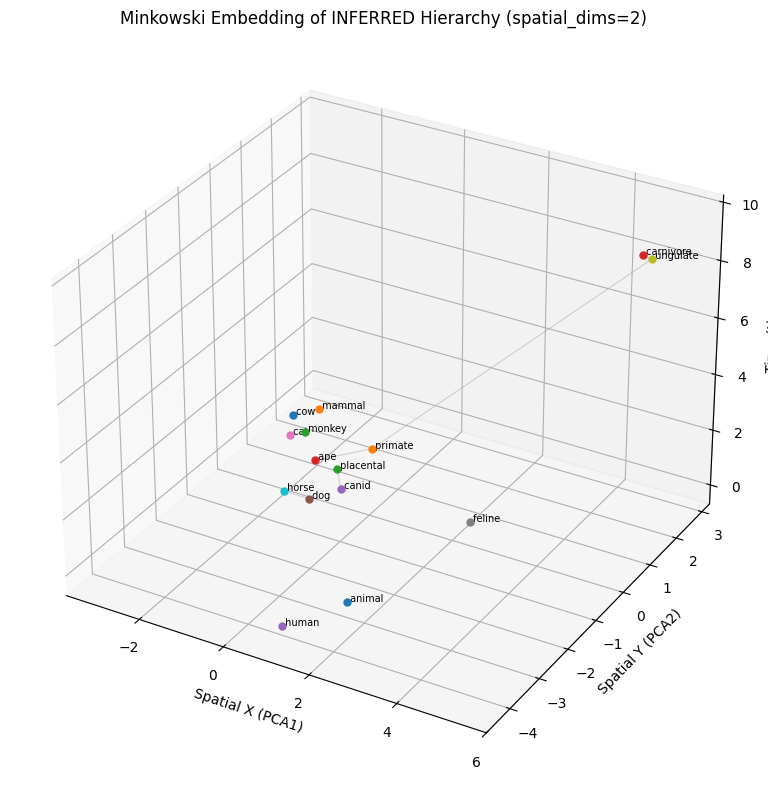

In [ ]:
#@title Constructing concepts using learned hierarchies!
print("\n=== Demo: LLM Inferring Hierarchy and Embedding (Constructor Theory Analogy) ===")

# 1. Get Concepts and BERT Embeddings (e.g., from a WordNet subtree)
# For this demo, let's pick a smaller, more focused set of concepts
target_concepts = ["animal", "mammal", "placental", "carnivore", "canid", "dog", "cat", "feline",
                   "ungulate", "horse", "cow", "primate", "monkey", "ape", "human"] # Mixed bag

print("\nGenerating BERT embeddings for target concepts...")
concept_bert_embeddings_learned_h = {}
valid_concept_names = []
for name in target_concepts:
    try:
        embedding = get_bert_embedding(name, bert_model, tokenizer)
        if embedding is not None:
            concept_bert_embeddings_learned_h[name] = embedding.tolist()
            valid_concept_names.append(name)
        else:
            print(f"Warning: Could not get embedding for '{name}'.")
    except Exception as e:
        print(f"Error getting BERT embedding for '{name}': {e}")

if not concept_bert_embeddings_learned_h:
    print("No BERT embeddings generated. Cannot proceed.")
    # exit()
else:
    print(f"Generated {len(concept_bert_embeddings_learned_h)} BERT embeddings.")


# 2. Infer Hierarchy (Simplified "Learning" based on BERT Similarity + Heuristics)
# This is a HEURISTIC proxy for an LLM learning "possible tasks/links"
# A more advanced LLM would use its internal knowledge or be trained for this.
print("\nInferring hierarchy based on BERT similarity and heuristics...")
inferred_hierarchy_pairs = []
similarity_threshold = 0.80 # Consider concepts highly similar if cos_sim > threshold
potential_parents_map = defaultdict(list)

# Create a matrix of embeddings for faster similarity calculation
names_for_matrix = list(concept_bert_embeddings_learned_h.keys())
embedding_matrix = np.array([concept_bert_embeddings_learned_h[name] for name in names_for_matrix])

if embedding_matrix.size > 0 :
    cosine_similarities = cosine_similarity(embedding_matrix)

    for i, child_name in enumerate(names_for_matrix):
        for j, potential_parent_name in enumerate(names_for_matrix):
            if i == j: continue # Cannot be its own parent

            sim = cosine_similarities[i, j]
            if sim > similarity_threshold:
                # Heuristic: A "parent" is often (but not always) a shorter word, or more general.
                # This is a very weak heuristic and where a real LLM's knowledge would shine.
                # For WordNet concepts, we could also check WordNet depth if available.
                # Let's add a simple heuristic: if potential_parent is a substring of child,
                # or significantly shorter. This is highly flawed but for demo purposes.

                # A slightly better heuristic for this known set:
                # Assume parent is more general (e.g. appears as prefix, or is a known hypernym from a small list)
                # For this demo, let's just use similarity and try to pick one best parent.
                potential_parents_map[child_name].append((potential_parent_name, sim))
else:
    print("Embedding matrix is empty, cannot infer hierarchy.")


# Select the "best" parent for each child based on highest similarity
# And try to avoid making something a parent if it's clearly more specific (e.g. "dog" as parent of "animal")
# This part is where true hierarchy learning is complex.
# For now, for each child, pick the most similar candidate as its parent.
# Then, identify roots as those not chosen as children.

temp_child_to_parent = {}
for child_name, candidates in potential_parents_map.items():
    if candidates:
        candidates.sort(key=lambda x: x[1], reverse=True) # Sort by similarity desc
        # Simplistic: pick the most similar as parent.
        # Add more sophisticated logic here if needed (e.g. check WordNet depth, etc.)
        chosen_parent_name = candidates[0][0]

        # Avoid obvious cycles or making a more specific term a parent of a general one
        # This is still very heuristic!
        if len(chosen_parent_name) < len(child_name) or child_name.startswith(chosen_parent_name):
             # Or if WordNet depth of parent < WordNet depth of child
            if child_name != chosen_parent_name : # ensure not self-parenting through this simple rule
                temp_child_to_parent[child_name] = chosen_parent_name


# Construct final hierarchy_pairs and identify roots
all_children_in_inferred_h = set(temp_child_to_parent.keys())
all_parents_in_inferred_h = set(temp_child_to_parent.values())
inferred_root_nodes = [name for name in names_for_matrix if name not in all_children_in_inferred_h and name in all_parents_in_inferred_h or name not in all_children_in_inferred_h and name not in all_parents_in_inferred_h ]
# If still no roots, pick the one with fewest outgoing "parent" links from temp_child_to_parent logic.
# Or, pick the "most general" sounding one like "animal" or "entity" if present.
if not inferred_root_nodes and "animal" in names_for_matrix: inferred_root_nodes = ["animal"]
elif not inferred_root_nodes and names_for_matrix: inferred_root_nodes = [names_for_matrix[0]] # fallback

for child_name, parent_name in temp_child_to_parent.items():
    inferred_hierarchy_pairs.append((child_name, parent_name))
for root_name in inferred_root_nodes:
    inferred_hierarchy_pairs.append((root_name, None))

# Remove duplicates
inferred_hierarchy_pairs = sorted(list(set(inferred_hierarchy_pairs)))

print(f"Inferred hierarchy with {len(inferred_hierarchy_pairs)} pairs (this is a heuristic!):")
# for ch, pa in inferred_hierarchy_pairs[:10]: print(f"  {ch} -> {pa}")


# 3. Embed the Inferred Hierarchy
spatial_dimensions_inferred = 2
epsilon_inferred = 1e-4

if concept_bert_embeddings_learned_h and inferred_hierarchy_pairs:
    print("\nComputing Minkowski Embedding for INFERRED hierarchy...")
    minkowski_coords_inferred = compute_minkowski_embedding(
        concept_bert_embeddings_learned_h,
        inferred_hierarchy_pairs,
        spatial_dimensions_inferred,
        epsilon_inferred
    )

    print("\n--- Computed Minkowski Coordinates for INFERRED hierarchy (sample) ---")
    if minkowski_coords_inferred:
        for i, (name, coords_val) in enumerate(minkowski_coords_inferred.items()):
            if i < 5: print(f"{name}: [{coords_val[0]:.3f}, " + ", ".join([f"{c:.3f}" for c in coords_val[1:]]) + "]")
            elif i == 5: print("...")
    else:
        print("No coordinates computed for inferred hierarchy.")

    # 4. Evaluate and Visualize
    print("\n--- Causal Consistency Check for INFERRED Hierarchy ---")
    # (Using check_causal_link_eval and visualization code similar to the previous demo)
    violations_count_inferred = 0
    checked_constraints_inferred = 0
    if minkowski_coords_inferred:
        for child_name, parent_name in inferred_hierarchy_pairs:
            if parent_name is None: continue
            checked_constraints_inferred += 1
            if child_name in minkowski_coords_inferred and parent_name in minkowski_coords_inferred:
                if not check_causal_link_eval(minkowski_coords_inferred[child_name],
                                              minkowski_coords_inferred[parent_name],
                                              epsilon_inferred, spatial_dimensions_inferred):
                    violations_count_inferred +=1
            else: violations_count_inferred +=1

        if violations_count_inferred > 0: print(f"{violations_count_inferred}/{checked_constraints_inferred} causal constraints VIOLATED for INFERRED hierarchy.")
        elif checked_constraints_inferred > 0: print(f"All {checked_constraints_inferred} checked causal constraints met for INFERRED hierarchy!")
        else: print("No constraints to check for inferred hierarchy.")

    if minkowski_coords_inferred and (spatial_dimensions_inferred == 2 or spatial_dimensions_inferred == 1) and len(minkowski_coords_inferred) > 1:
        print("\nVisualizing INFERRED Hierarchy Minkowski Embedding...")
        # (Reuse plotting code from previous WordNet demo, adapting variable names)
        fig_inf = plt.figure(figsize=(max(10, len(minkowski_coords_inferred)//3), max(8, len(minkowski_coords_inferred)//4)))
        if spatial_dimensions_inferred == 2:
            ax_inf = fig_inf.add_subplot(111, projection='3d')
            ax_inf.set_xlabel("Spatial X (PCA1)"); ax_inf.set_ylabel("Spatial Y (PCA2)"); ax_inf.set_zlabel("Time (t)")
            link_indices_inf = (1,2,0)
        elif spatial_dimensions_inferred == 1:
            ax_inf = fig_inf.add_subplot(111)
            ax_inf.set_xlabel("Spatial X (PCA1)"); ax_inf.set_ylabel("Time (t)")
            link_indices_inf = (1,0)

        for name, coords_val in minkowski_coords_inferred.items():
            plot_args_scatter = [coords_val[i] for i in link_indices_inf]
            ax_inf.scatter(*plot_args_scatter, s=25)
            if len(minkowski_coords_inferred) < 30: ax_inf.text(*plot_args_scatter, f" {name}", fontsize=7)

        for child, parent in inferred_hierarchy_pairs:
            if parent is None or child not in minkowski_coords_inferred or parent not in minkowski_coords_inferred: continue
            p1c, p2c = minkowski_coords_inferred[parent], minkowski_coords_inferred[child]
            plot_args_line = []
            for i_dim in range(len(link_indices_inf)):
                actual_idx = link_indices_inf[i_dim]
                plot_args_line.extend([[p1c[actual_idx], p2c[actual_idx]]])
            ax_inf.plot(*plot_args_line, c='darkgrey', alpha=0.5, linewidth=0.8)

        plt.title(f"Minkowski Embedding of INFERRED Hierarchy (spatial_dims={spatial_dimensions_inferred})")
        plt.tight_layout(); plt.show()

elif not concept_bert_embeddings_learned_h:
    print("Demo cannot run as BERT embeddings were not generated.")

Generating BERT embeddings for target concepts...

--- Attempting to 'Imagine' the concept: dog ---

Searching for compositional path to 'dog'...
  Step 0: New best match 'physical' (h_score=9.924, g_score=0.00)
Search ended after 5000 steps. Best match found:

--- 'Imagined' Composition for 'dog' ---
Final Composed Name: physical
Final Features: frozenset({'is_physical'})
Final Intel Coord (tau, x, y): [0.00, -0.50, -0.50]
Construction Cost (g_score): 0.00
Construction Path (sequence of concepts and tasks):


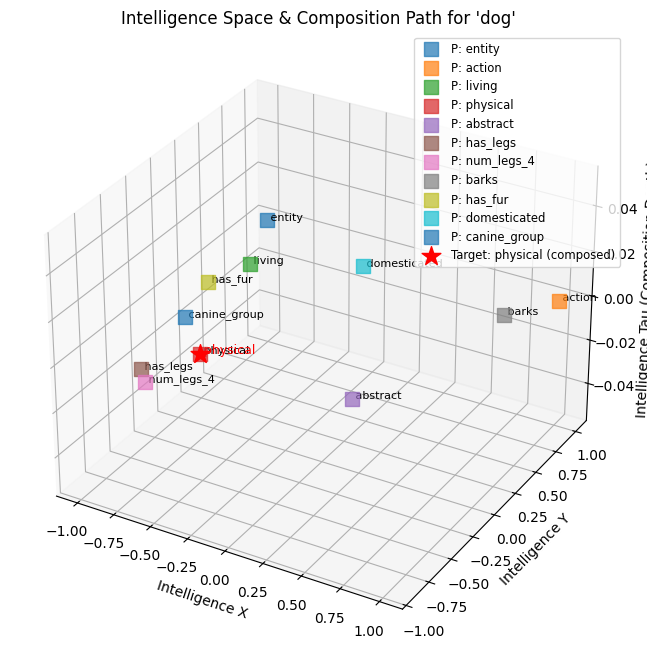

In [ ]:
#@title Constructing World from pre-defined concepts!
# --- 1. Define Semantic Primitives (Our Low-Dimensional "Intelligence" Space) ---
# Each primitive has a name, a set of inherent features, and a simple low-D vector
# For this demo, let our "intelligence space" be 2D (x_intel, y_intel)
# We can also assign a base "tau_intel" representing fundamental level.
PRIMITIVE_TAU = 0.0

semantic_primitives = {
    "entity":       {"features": {"is_entity"},            "intel_coord": [PRIMITIVE_TAU, -1.0, 1.0]},
    "action":       {"features": {"is_action"},            "intel_coord": [PRIMITIVE_TAU, 1.0, 1.0]},
    "living":       {"features": {"is_living"},            "intel_coord": [PRIMITIVE_TAU, -0.8, 0.5]},
    "physical":     {"features": {"is_physical"},          "intel_coord": [PRIMITIVE_TAU, -0.5, -0.5]},
    "abstract":     {"features": {"is_abstract"},          "intel_coord": [PRIMITIVE_TAU, 0.5, -0.5]},
    "has_legs":     {"features": {"property_has_legs"},    "intel_coord": [PRIMITIVE_TAU, -0.7, -0.8]}, # General property
    "num_legs_4":   {"features": {"property_num_legs_4"},  "intel_coord": [PRIMITIVE_TAU, -0.6, -0.9]}, # Specific value
    "barks":        {"features": {"action_barks"},         "intel_coord": [PRIMITIVE_TAU, 0.8, 0.7]},
    "has_fur":      {"features": {"property_has_fur"},     "intel_coord": [PRIMITIVE_TAU, -0.9, 0.2]},
    "domesticated": {"features": {"state_domesticated"},   "intel_coord": [PRIMITIVE_TAU, -0.2, 0.8]},
    "canine_group": {"features": {"group_canine"},         "intel_coord": [PRIMITIVE_TAU, -0.8, -0.2]}, # A primitive "grouping"
}

# --- 2. Target Concepts (from "Experience" - BERT embeddings) ---
target_concept_names = ["dog", "cat", "wolf", "animal", "mammal", "pet"]
target_concept_bert_embeddings = {}
print("Generating BERT embeddings for target concepts...")
for name in target_concept_names:
    emb = get_bert_embedding(name, bert_model, tokenizer)
    if emb is not None:
        target_concept_bert_embeddings[name] = emb
    else:
        print(f"Warning: Could not get BERT embedding for '{name}'")

if not target_concept_bert_embeddings:
    print("No target BERT embeddings. Demo cannot proceed effectively.")
    # exit()
    pass

# --- 3. Define Compositional Tasks (Rules of "Semantic Physics") ---
# A task takes one or two existing composed concepts (or primitives) and creates a new one.
# Output: new_name, new_features, new_intel_coord (e.g., average), cost_of_composition

compositional_tasks = []

def define_composition(name: str, concept1_name_pattern: str, concept2_name_pattern: str,
                       output_name_template: str, cost: float = 1.0):
    """
    Defines a template for a compositional task.
    name_pattern can be a specific name or "*" to match any.
    """
    compositional_tasks.append({
        "name": name,
        "c1_pattern": concept1_name_pattern,
        "c2_pattern": concept2_name_pattern, # If None, it's a unary modification/specialization
        "output_template": output_name_template,
        "cost": cost
    })

# Examples of compositional rules:
# Rule 1: Combine an entity with a property
define_composition("AddProperty", "*", "property_*", "{c1}_with_{c2_feature}", cost=1.0)
# Rule 2: Combine two entities/groups if one is a known sub-group (very simplified)
define_composition("SpecializeGroup", "*", "group_*", "{c2_feature}_{c1}", cost=0.8) # e.g. canine_animal
# Rule 3: Combine an entity with an action it performs
define_composition("EntityPerformsAction", "*", "action_*", "{c1}_that_{c2_feature}", cost=1.2)
# Rule 4: Combine two existing composed states (more general)
define_composition("MergeStates", "*", "*", "merged_{c1}_and_{c2}", cost=1.5)
# Rule 5: Simple inheritance/typing (unary)
define_composition("AssignType_Living", "entity", None, "living_entity", cost=0.5)
define_composition("AssignType_Physical", "entity", None, "physical_entity", cost=0.5)
define_composition("Specialize_Animal", "living_entity", None, "animal", cost=0.5) # if 'living_entity' has certain features

# This is a very small set. A real system would have many more, or learn them.

# Represent current state for A* search:
# (f_score, g_score, current_concept_name, current_features_set, current_intel_coord, path_list)
# Our "composed concepts" will be dynamically named for this demo.

class ComposedConcept:
    def __init__(self, name, features, intel_coord, construction_cost, path):
        self.name = name
        self.features = frozenset(features) # Use frozenset for hashability
        self.intel_coord = tuple(intel_coord) # Use tuple for hashability
        self.cost = construction_cost
        self.path = path # List of task names and concept names

    def __lt__(self, other): # For heapq
        return self.cost < other.cost # Could be f_score if doing proper A*

    def __hash__(self):
        return hash((self.name, self.features, self.intel_coord))

    def __eq__(self, other):
        return isinstance(other, ComposedConcept) and \
               self.name == other.name and \
               self.features == other.features and \
               self.intel_coord == other.intel_coord

    def __repr__(self):
        return f"Composed('{self.name}', cost={self.cost:.2f}, intel_coord=({self.intel_coord[1]:.2f},{self.intel_coord[2]:.2f}))"


# --- 4. "Imagination" / Search Process (A* to find compositional path to target BERT embedding) ---

def get_pseudo_bert_from_features(features_set, all_primitives_bert_like_vectors):
    """
    Crude way to get a BERT-like vector for a composed concept:
    Average BERT vectors of primitives whose features are present.
    In reality, this mapping would be complex and learned.
    For demo, we'll use this to calculate heuristic distance to target BERT.
    """
    active_primitive_vectors = []
    for p_name, p_data in semantic_primitives.items():
        if p_data["features"].issubset(features_set): # or any overlap
            # We need BERT-like vectors for primitives if we want to average them.
            # Let's create placeholder "primitive BERTs" by averaging target BERTs they might relate to
            if p_name in all_primitives_bert_like_vectors:
                active_primitive_vectors.append(all_primitives_bert_like_vectors[p_name])

    if not active_primitive_vectors:
        return np.zeros_like(list(target_concept_bert_embeddings.values())[0]) # Zero vector if no match
    return np.mean(active_primitive_vectors, axis=0)


# Pre-calculate pseudo-BERT for primitives for heuristic (highly simplified)
# A better way would be to have actual embeddings for primitives or learn a projection
primitive_pseudo_berts = {}
if target_concept_bert_embeddings: # Ensure this is not empty
    example_bert_dim = len(list(target_concept_bert_embeddings.values())[0])
    for p_name in semantic_primitives:
        # Simplistic: associate primitives with target concepts they might be part of
        # This is just to get *some* vector for the heuristic
        related_target_sum = np.zeros(example_bert_dim)
        count = 0
        for t_name, t_emb in target_concept_bert_embeddings.items():
            if any(f_part in t_name for f_part in semantic_primitives[p_name]["features"]):
                related_target_sum += t_emb
                count += 1
        primitive_pseudo_berts[p_name] = related_target_sum / count if count > 0 else np.random.rand(example_bert_dim) * 0.1


def heuristic_to_target_bert(composed_features, target_bert_embedding, primitive_berts_for_heuristic):
    if not target_concept_bert_embeddings: return float('inf') # Should not happen if checked before

    composed_pseudo_bert = get_pseudo_bert_from_features(composed_features, primitive_berts_for_heuristic)
    # Cosine distance = 1 - cosine_similarity
    similarity = cosine_similarity(composed_pseudo_bert.reshape(1,-1), target_bert_embedding.reshape(1,-1))[0,0]
    return (1.0 - similarity) * 10 # Scaled distance as heuristic (lower is better)


def find_compositional_path(target_concept_name_str: str, max_steps=5000):
    if target_concept_name_str not in target_concept_bert_embeddings:
        print(f"Target concept '{target_concept_name_str}' has no BERT embedding.")
        return None

    target_bert = target_concept_bert_embeddings[target_concept_name_str]

    # Start with all primitives as initial composed concepts
    open_set = [] # (f_score, ComposedConcept_object)
    for p_name, p_data in semantic_primitives.items():
        intel_coord_p = p_data["intel_coord"] # [tau, x, y]
        # Ensure intel_coord_p is a list of numbers
        if not all(isinstance(val, (int, float)) for val in intel_coord_p):
            print(f"Warning: Primitive '{p_name}' has invalid intel_coord: {intel_coord_p}. Skipping.")
            continue

        concept = ComposedConcept(p_name, p_data["features"], intel_coord_p, 0, [p_name])
        h_score = heuristic_to_target_bert(concept.features, target_bert, primitive_pseudo_berts)
        heapq.heappush(open_set, (0 + h_score, concept))

    closed_set = set() # Store (name, features_frozenset, intel_coord_tuple) of visited states

    print(f"\nSearching for compositional path to '{target_concept_name_str}'...")

    best_match_so_far = (float('inf'), None) # (distance_to_target_bert, concept_object)

    for step_count in range(max_steps):
        if not open_set:
            print("Open set empty, search ended.")
            break

        f_score, current_composed_concept = heapq.heappop(open_set)

        # Check if this concept is a good match (using heuristic for now)
        # A better match would involve projecting its low-D intel_coord to BERT space and comparing
        current_h_score = heuristic_to_target_bert(current_composed_concept.features, target_bert, primitive_pseudo_berts)
        if current_h_score < best_match_so_far[0]:
            best_match_so_far = (current_h_score, current_composed_concept)
            print(f"  Step {step_count}: New best match '{current_composed_concept.name}' (h_score={current_h_score:.3f}, g_score={current_composed_concept.cost:.2f})")

        if current_h_score < 0.5: # Arbitrary threshold for "good enough" match
            print(f"Found good match for '{target_concept_name_str}'!")
            return current_composed_concept

        state_signature = (current_composed_concept.name, current_composed_concept.features, current_composed_concept.intel_coord)
        if state_signature in closed_set:
            continue
        closed_set.add(state_signature)

        # Try to apply compositional tasks
        # Unary tasks (modifications)
        for task_template in compositional_tasks:
            if task_template["c2_pattern"] is None: # Unary task
                if task_template["c1_pattern"] == "*" or task_template["c1_pattern"] == current_composed_concept.name:
                    new_name = task_template["output_template"].format(c1=current_composed_concept.name)
                    # Unary tasks usually add/refine features or specialize type
                    new_features = set(current_composed_concept.features) # Start with current features
                    # Example: if task is AssignType_Living, add 'is_living' if 'entity' is present
                    if task_template["name"] == "AssignType_Living" and "is_entity" in new_features:
                        new_features.add("is_living")
                    elif task_template["name"] == "Specialize_Animal" and "is_living_entity" in new_features: # Assume "living_entity" is a composed name
                        new_features.add("is_animal_group_feature") # Add a marker feature
                    # Add more specific unary task logic here...

                    # New intel_coord: could be same or slightly shifted
                    new_intel_coord_list = list(current_composed_concept.intel_coord)
                    new_intel_coord_list[0] += 0.1 # Increment tau_intel slightly for new composition step
                    # Simple shift for demo for unary op
                    new_intel_coord_list[1] += random.uniform(-0.05, 0.05)
                    new_intel_coord_list[2] += random.uniform(-0.05, 0.05)

                    new_concept = ComposedConcept(new_name, new_features, new_intel_coord_list,
                                                  current_composed_concept.cost + task_template["cost"],
                                                  current_composed_concept.path + [task_template["name"], new_name])

                    if (new_concept.name, new_concept.features, new_concept.intel_coord) not in closed_set:
                        h = heuristic_to_target_bert(new_concept.features, target_bert, primitive_pseudo_berts)
                        heapq.heappush(open_set, (new_concept.cost + h, new_concept))


        # Binary tasks (compositions with other primitives or already composed concepts)
        # For simplicity, let's compose with primitives only in this demo A* step
        for p_name, p_data in semantic_primitives.items():
            primitive_concept = ComposedConcept(p_name, p_data["features"], p_data["intel_coord"], 0, [p_name]) # Cost 0 for primitive itself

            for task_template in compositional_tasks:
                if task_template["c2_pattern"] is not None: # Binary task
                    # Check if current_composed_concept matches c1_pattern and primitive_concept matches c2_pattern
                    # (Simplified matching for demo)
                    c1_match = task_template["c1_pattern"] == "*" or task_template["c1_pattern"] == current_composed_concept.name
                    c2_match = task_template["c2_pattern"] == "*" or \
                               (task_template["c2_pattern"].startswith("property_") and any(f.startswith("property_") for f in primitive_concept.features)) or \
                               (task_template["c2_pattern"].startswith("group_") and any(f.startswith("group_") for f in primitive_concept.features)) or \
                               (task_template["c2_pattern"].startswith("action_") and any(f.startswith("action_") for f in primitive_concept.features))


                    if c1_match and c2_match:
                        # Create new composed concept
                        new_name = task_template["output_template"].format(
                            c1=current_composed_concept.name,
                            c2=primitive_concept.name, # Or a feature from it
                            c1_feature=list(current_composed_concept.features)[0] if current_composed_concept.features else "feature1",
                            c2_feature=list(primitive_concept.features)[0] if primitive_concept.features else "feature2"
                        )
                        new_features = current_composed_concept.features.union(primitive_concept.features)

                        # New intel_coord: average of parents, tau slightly increased
                        new_intel_coord_list = [
                            max(current_composed_concept.intel_coord[0], primitive_concept.intel_coord[0]) + 0.2, # Higher tau
                            (current_composed_concept.intel_coord[1] + primitive_concept.intel_coord[1]) / 2 + random.uniform(-0.05,0.05),
                            (current_composed_concept.intel_coord[2] + primitive_concept.intel_coord[2]) / 2 + random.uniform(-0.05,0.05)
                        ]

                        new_concept = ComposedConcept(new_name, new_features, new_intel_coord_list,
                                                      current_composed_concept.cost + primitive_concept.cost + task_template["cost"],
                                                      current_composed_concept.path + [primitive_concept.name, task_template["name"], new_name])

                        state_sig_new = (new_concept.name, new_concept.features, new_concept.intel_coord)
                        if state_sig_new not in closed_set:
                            h = heuristic_to_target_bert(new_concept.features, target_bert, primitive_pseudo_berts)
                            heapq.heappush(open_set, (new_concept.cost + h, new_concept))

    print(f"Search ended after {max_steps} steps. Best match found:")
    return best_match_so_far[1]


# --- Run the Demo ---
if target_concept_bert_embeddings:
    target_to_explain = "dog" # Choose one of the target_concept_names

    print(f"\n--- Attempting to 'Imagine' the concept: {target_to_explain} ---")
    explained_concept_path = find_compositional_path(target_to_explain)

    if explained_concept_path:
        print(f"\n--- 'Imagined' Composition for '{target_to_explain}' ---")
        print(f"Final Composed Name: {explained_concept_path.name}")
        print(f"Final Features: {explained_concept_path.features}")
        print(f"Final Intel Coord (tau, x, y): [{explained_concept_path.intel_coord[0]:.2f}, {explained_concept_path.intel_coord[1]:.2f}, {explained_concept_path.intel_coord[2]:.2f}]")
        print(f"Construction Cost (g_score): {explained_concept_path.cost:.2f}")
        print("Construction Path (sequence of concepts and tasks):")
        current_segment = []
        for item in explained_concept_path.path:
            current_segment.append(item)
            if len(current_segment) == 3 or (len(current_segment)==2 and item in [t["name"] for t in compositional_tasks if t["c2_pattern"] is None]): # Primitive, Task, NewConcept OR Primitive/Composed, UnaryTask
                print(f"  {' -> '.join(current_segment)}")
                # Start new segment with the last concept if it's not a task name
                if not any(item == t["name"] for t in compositional_tasks):
                    current_segment = [item]
                else: # if last item was task name, then the "new_name" was already printed.
                    current_segment = []


        # --- Visualization of the "Intelligence Space" and the composed path ---
        fig_intel = plt.figure(figsize=(10, 8))
        ax_intel = fig_intel.add_subplot(111, projection='3d' if len(semantic_primitives[list(semantic_primitives.keys())[0]]["intel_coord"]) == 3 else None)

        # Plot primitives
        for p_name, p_data in semantic_primitives.items():
            coord = p_data["intel_coord"]
            if len(coord) == 3: # tau, x, y
                ax_intel.scatter(coord[1], coord[2], coord[0], marker='s', s=100, label=f"P: {p_name}", alpha=0.7)
                ax_intel.text(coord[1], coord[2], coord[0], f" {p_name}", fontsize=8)
            elif len(coord) == 2: # x,y (assuming tau is 0 or not plotted)
                ax_intel.scatter(coord[0], coord[1], marker='s', s=100, label=f"P: {p_name}", alpha=0.7)
                ax_intel.text(coord[0], coord[1], f" {p_name}", fontsize=8)


        # Plot the composed path
        # Path contains names. We need to reconstruct coords. This is tricky as composed coords are dynamic.
        # For this demo, let's just plot the final composed concept if its intel_coord is available.
        final_intel_coord = explained_concept_path.intel_coord
        if len(final_intel_coord) == 3:
             ax_intel.scatter(final_intel_coord[1], final_intel_coord[2], final_intel_coord[0],
                             marker='*', s=200, color='red', label=f"Target: {explained_concept_path.name} (composed)")
             ax_intel.text(final_intel_coord[1], final_intel_coord[2], final_intel_coord[0], f" {explained_concept_path.name}", fontsize=9, color="red")
             ax_intel.set_xlabel("Intelligence X")
             ax_intel.set_ylabel("Intelligence Y")
             ax_intel.set_zlabel("Intelligence Tau (Composition Depth)")

        elif len(final_intel_coord) == 2:
             ax_intel.scatter(final_intel_coord[0], final_intel_coord[1],
                             marker='*', s=200, color='red', label=f"Target: {explained_concept_path.name} (composed)")
             ax_intel.text(final_intel_coord[0], final_intel_coord[1], f" {explained_concept_path.name}", fontsize=9, color="red")
             ax_intel.set_xlabel("Intelligence X")
             ax_intel.set_ylabel("Intelligence Y")

        plt.title(f"Intelligence Space & Composition Path for '{target_to_explain}'")
        plt.legend(fontsize='small')
        plt.show()

    else:
        print(f"Could not 'imagine' a good compositional path for '{target_to_explain}'.")
else:
    print("Demo requires target_concept_bert_embeddings to be populated.")

In [ ]:

class SimpleToyFlow:
    def __init__(self, input_dim):
        self.input_dim = input_dim
        # For a simple affine coupling layer: split dimensions
        self.split_dim = input_dim // 2

        # Parameters for scaling (s) and translation (t)
        # In a real flow, these would be outputs of small neural networks conditioned on the other half.
        # Here, we'll make them simple, fixed, or randomly initialized learnable parameters.
        # For simplicity, let's use fixed non-linear functions for s and t for the demo.

        # We'll use a fixed permutation for mixing, instead of learnable coupling.
        # This makes inversion straightforward.
        self.permutation = torch.randperm(input_dim)
        self.inv_permutation = torch.argsort(self.permutation)

    def _coupling_transform(self, x1, x2_cond):
        # x1 is the part to transform, x2_cond is the conditioning part
        # Simple non-linear functions for scale (s) and translation (t)
        # These should ideally be complex, but for a toy example:
        scale = torch.sigmoid(x2_cond * 0.1 + 0.5) # Element-wise, derived from x2_cond
        translation = torch.tanh(x2_cond * 0.2)    # Element-wise, derived from x2_cond

        # Ensure scale and translation have same last dim as x1
        if x1.shape[-1] != x2_cond.shape[-1]: # If split is uneven
            # This part needs careful handling for general coupling layers.
            # For our simple demo, let's assume split_dim makes them compatible
            # or make s and t broadcast correctly.
            # For this toy version, let's just make them simple element-wise transforms
            # not dependent on the other half to keep it super simple.
            scale = torch.sigmoid(x1 * 0.1 + 0.5)
            translation = torch.tanh(x1 * 0.2)

        return x1 * scale + translation

    def _inverse_coupling_transform(self, y1, x2_cond):
        # y1 is the part to invert, x2_cond is the conditioning part (same as forward)
        scale = torch.sigmoid(x2_cond * 0.1 + 0.5)
        translation = torch.tanh(x2_cond * 0.2)

        if y1.shape[-1] != x2_cond.shape[-1]: # Simplified for toy
            scale = torch.sigmoid( (y1 - translation) / (scale + 1e-8) * 0.1 + 0.5 ) # Approx invert element-wise
            translation = torch.tanh( (y1 - translation) / (scale + 1e-8) * 0.2 )
            # This inversion is tricky if s, t depend on x2.
            # For our super simple non-conditional toy version:
            scale_inv = torch.sigmoid(y1 * 0.1 + 0.5) # Same as forward
            translation_inv = torch.tanh(y1 * 0.2)   # Same as forward
            return (y1 - translation_inv) / (scale_inv + 1e-8) # Add epsilon for stability

        return (y1 - translation) / (scale + 1e-8) # Add epsilon for stability

    def forward(self, x_tensor: torch.Tensor) -> torch.Tensor:
        # Simple element-wise non-linearity + permutation
        # Example: x_permuted = x_tensor[:, self.permutation]
        # For an even simpler demo, let's use element-wise non-linearity.
        # A very basic "flow": softplus for non-linearity, and make it invertible.
        # y = log(1 + exp(x)) => x = log(exp(y) - 1)
        # Let's try something like x + tanh(x) (not easily invertible analytically, for real flows use coupling)

        # Super-Toy Invertible Element-wise Flow Layer:
        # f(x) = x + a * sin(b*x) -- this is not generally invertible easily.
        # Let's use a simple scaling and shifting, then a permutation.
        # This is more like a *single step* of a more complex flow.

        x_scaled = x_tensor * 1.5 # Scale
        x_shifted = x_scaled + torch.tanh(x_scaled * 0.5) # Non-linear shift
        u = x_shifted[:, self.permutation] # Permute for mixing
        return u

    def inverse(self, u_tensor: torch.Tensor) -> torch.Tensor:
        x_shifted_recovered = u_tensor[:, self.inv_permutation] # Inverse permute

        # To invert y = x + tanh(0.5x), we need numerical methods or simpler func.
        # Let's make the forward pass even simpler for easy inversion:
        # Forward: u = (x * scale_factor) + offset_factor_nonlinear(x)
        # For this demo, let's simplify to:
        # Forward:
        #   x_nl = torch.tanh(x_tensor * 0.5) # Non-linear part
        #   u = (x_tensor * 1.2) + x_nl # Scaled linear + non-linear
        #   u_perm = u[:, self.permutation]
        # Inverse:
        #   u_rec = u_tensor[:, self.inv_permutation]
        #   To find x from u_rec = 1.2*x + tanh(0.5*x) is hard.

        # Let's use a very simple invertible transformation: Affine transform + element-wise tanh + permutation
        # u = permute(tanh(A*x + b))
        # x = A_inv * (atanh(permute_inv(u)) - b)
        # For demo, let's use the previous simpler (but hard to invert if we use tanh(x_scaled*0.5))
        # Let's stick to the scaling, non-linear shift (tanh part), and permutation.
        # And for the inverse, we will approximate it. A true flow guarantees invertibility.

        # This is an approximation of inverting y = x_s + tanh(0.5*x_s) where x_s = x*1.5
        # It assumes tanh(0.5*x_s) is small compared to x_s for the inverse.
        x_scaled_recovered = x_shifted_recovered / (1 + 0.5 * (1 - torch.tanh(x_shifted_recovered * 0.5 / 1.5)**2) ) # Approx using derivative
        x_recovered = x_scaled_recovered / 1.5

        return x_recovered

# --- 2. Define Linear Bottleneck P (using PCA on flow's latent space u) ---
# This function will be called once to get P
def get_pca_projection_matrix(u_vectors_np: np.ndarray, k_bottleneck_dims: int):
    if u_vectors_np.shape[0] <= k_bottleneck_dims or k_bottleneck_dims == 0 : # Cannot do PCA or no bottleneck
        # Fallback: just select first k_bottleneck_dims or identity if k is too large
        P = np.eye(u_vectors_np.shape[1])[:k_bottleneck_dims, :] if k_bottleneck_dims > 0 else np.zeros((0, u_vectors_np.shape[1]))
        pca_model = None
        # print(f"PCA skipped or k is too large/small. Using direct selection/identity for P. P shape: {P.shape}")
    else:
        pca = PCA(n_components=k_bottleneck_dims)
        pca.fit(u_vectors_np)
        P = pca.components_ # Shape: (k_bottleneck_dims, d_bert)
        pca_model = pca # Return model for potential inverse transform via pca.inverse_transform
        # print(f"PCA fitted. Projection matrix P shape: {P.shape}")
    return P, pca_model


# --- 3. Putting it all together: Encode and Decode ---
# These will be specific to the flow and P matrix instance

# Global instances for the demo (would be part of a larger class)
bert_dimension = 768 # Assuming bert-base
toy_flow = SimpleToyFlow(bert_dimension)
P_matrix = None # Will be fitted
pca_model_global = None # Store PCA model

def encode_hybrid(x_bert_np: np.ndarray, flow_model: SimpleToyFlow, P_proj_matrix: np.ndarray):
    if x_bert_np.ndim == 1:
        x_bert_np = x_bert_np.reshape(1, -1)
    x_tensor = torch.from_numpy(x_bert_np).float()
    u_tensor = flow_model.forward(x_tensor) # Non-linear map
    u_np = u_tensor.detach().numpy()
    if P_proj_matrix is None or P_proj_matrix.shape[1] != u_np.shape[1]:
        # print("Warning: P_matrix not fitted or dimension mismatch. Returning u_np directly (no bottleneck).")
        return u_np.squeeze() # Or handle error
    y_bottleneck = u_np @ P_proj_matrix.T # Project u to k-dims: (N,d) @ (d,k) -> (N,k)
    return y_bottleneck.squeeze() # Remove batch dim if N=1

def decode_hybrid(y_bottleneck_np: np.ndarray, flow_model: SimpleToyFlow, P_proj_matrix: np.ndarray, pca_fitted_model=None):
    if y_bottleneck_np.ndim == 1:
        y_bottleneck_np = y_bottleneck_np.reshape(1, -1)

    if P_proj_matrix is None: # No P, means y_bottleneck_np is actually u_np
        u_tilde_np = y_bottleneck_np
    elif pca_fitted_model is not None: # Use PCA inverse_transform if P was from PCA
        # print(f"Decoding with PCA inverse transform. y_bottleneck shape: {y_bottleneck_np.shape}")
        u_tilde_np = pca_fitted_model.inverse_transform(y_bottleneck_np)
    else: # General P, use P.T (pseudo-inverse if P is just selection/random)
        u_tilde_np = y_bottleneck_np @ P_proj_matrix # (N,k) @ (k,d) -> (N,d)
        # This assumes P_proj_matrix rows are orthonormal for P.T @ y to be a good reconstruction.
        # If P is e.g. random projection, P.T is not its inverse.
        # A true pseudo-inverse (P.T @ np.linalg.inv(P @ P.T)) @ y might be better for general P.
        # For simplicity with PCA components (P), P.T gives reconstruction in PCA space.

    u_tilde_tensor = torch.from_numpy(u_tilde_np).float()
    x_reconstructed_tensor = flow_model.inverse(u_tilde_tensor) # Invert flow
    return x_reconstructed_tensor.detach().numpy().squeeze()


# --- Demo Execution ---
print("\n=== Hybrid Embedding Demo: Flow + Linear Bottleneck ===")

# A. Load concepts and get baseline BERT embeddings (same as previous WordNet demo)
# (Assuming wordnet_subtree_data and baseline_bert_embeddings are populated)
if 'baseline_bert_embeddings' not in globals() or not baseline_bert_embeddings:
    print("Baseline BERT embeddings not found. Please run previous WordNet/BERT demo cells.")
    # exit()
else:
    bert_embeddings_np_all = np.array(list(baseline_bert_embeddings.values()))
    concept_names_all = list(baseline_bert_embeddings.keys())
    if bert_embeddings_np_all.size > 0:
         bert_dimension = bert_embeddings_np_all.shape[1]
         toy_flow = SimpleToyFlow(bert_dimension) # Re-initialize flow with correct dimension
    else:
        print("No BERT embeddings to process.")
        # exit()


    # B. Apply flow to all BERT embeddings to get 'u' vectors
    print("\nApplying toy flow to BERT embeddings to get latent 'u' vectors...")
    u_vectors_list = []
    if bert_embeddings_np_all.size > 0:
        x_all_tensor = torch.from_numpy(bert_embeddings_np_all).float()
        u_all_tensor = toy_flow.forward(x_all_tensor)
        u_vectors_np_all = u_all_tensor.detach().numpy()
        print(f"'u' vectors shape: {u_vectors_np_all.shape}")

        # C. Fit PCA on 'u' vectors to get the projection matrix P
        bottleneck_k_dims = spatial_dims # Use the same number of spatial dims for bottleneck
        print(f"\nFitting PCA on 'u' vectors for {bottleneck_k_dims}-dim bottleneck...")
        P_matrix, pca_model_global = get_pca_projection_matrix(u_vectors_np_all, bottleneck_k_dims)

        if P_matrix is not None:
            print(f"Projection matrix P (bottleneck) shape: {P_matrix.shape}")

            # D. Encode all concepts to the low-dimensional 'y' space
            print("\nEncoding concepts to low-dimensional 'y' space via P f(x)...")
            hybrid_low_dim_embeddings = {}
            for i, name in enumerate(concept_names_all):
                x_bert = bert_embeddings_np_all[i]
                y_low_dim = encode_hybrid(x_bert, toy_flow, P_matrix)
                hybrid_low_dim_embeddings[name] = y_low_dim.tolist()
                if i < 3:
                    print(f"  {name} -> y: {y_low_dim[:5]}... (shape: {y_low_dim.shape})")

            # E. Use these 'hybrid_low_dim_embeddings' as SPATIAL coordinates for Minkowski
            # The 't' (tau) coordinate still comes from the hierarchy.
            # We need to build minkowski_coords_hybrid: {name: [tau] + y_low_dim_list}

            # Re-run compute_minkowski_embedding, but its internal PCA will be on BERT.
            # We need to modify it or pre-calculate spatial part.
            # For this demo, let's manually construct input for compute_minkowski_embedding
            # by creating "pseudo-BERT" embeddings that are ALREADY our low-dim y,
            # and tell compute_minkowski_embedding that spatial_dims IS bottleneck_k_dims
            # and that its internal PCA should effectively be an identity or skipped for spatial.

            # This is a bit of a hack for the demo. A cleaner way would be to refactor
            # compute_minkowski_embedding to accept pre-computed spatial coordinates.

            # For now, let's just use the hybrid_low_dim_embeddings directly as the spatial part
            # and build the [tau, x_hybrid, y_hybrid, ...] coordinates, then run time adjustment.

            # Create initial Minkowski coords with hybrid spatial and t=0
            initial_minkowski_coords_hybrid = {
                name: [0.0] + hybrid_low_dim_embeddings[name] for name in concept_names_all
            }

            # Use a simplified time adjustment loop directly (adapting from LLM's function)
            # (Assuming baseline_hierarchy_pairs is defined)
            minkowski_coords_hybrid_final = {k: list(v) for k,v in initial_minkowski_coords_hybrid.items()} # Make mutable copies

            print("\nAdjusting time coordinates for hybrid spatial embeddings...")
            if 'baseline_hierarchy_pairs' in globals() and baseline_hierarchy_pairs:
                n_iterations_hybrid = 1000
                epsilon_hybrid = 1e-5 # Use the same epsilon as before
                strict_inequality_buffer_hybrid = epsilon_hybrid * 0.01 + 1e-9
                learning_rate_hybrid = 0.1

                for iteration in range(n_iterations_hybrid):
                    changed = False
                    for child_name, parent_name in baseline_hierarchy_pairs:
                        if parent_name is None or child_name not in minkowski_coords_hybrid_final or parent_name not in minkowski_coords_hybrid_final:
                            continue

                        p_coords_h = np.array(minkowski_coords_hybrid_final[parent_name])
                        c_coords_h = np.array(minkowski_coords_hybrid_final[child_name])

                        spatial_dist_sq_h = np.sum((c_coords_h[1:] - p_coords_h[1:])**2)
                        sqrt_arg_h = spatial_dist_sq_h + epsilon_hybrid
                        if sqrt_arg_h < 0: sqrt_arg_h = 0

                        required_dt_h = np.sqrt(sqrt_arg_h)
                        required_t_c_h = p_coords_h[0] + required_dt_h + strict_inequality_buffer_hybrid

                        if c_coords_h[0] < required_t_c_h:
                            diff = required_t_c_h - c_coords_h[0]
                            minkowski_coords_hybrid_final[child_name][0] += diff * learning_rate_hybrid
                            changed = True
                    if not changed and iteration > 0:
                        print(f"Hybrid time adjustment converged at iteration {iteration}.")
                        break
                else:
                    print("Hybrid time adjustment max iterations reached.")

                # Normalize time
                all_times_hybrid = [coords[0] for coords in minkowski_coords_hybrid_final.values()]
                if all_times_hybrid:
                    min_t_hybrid = min(all_times_hybrid)
                    for name in minkowski_coords_hybrid_final:
                        minkowski_coords_hybrid_final[name][0] -= min_t_hybrid
                        if minkowski_coords_hybrid_final[name][0] < 0 and abs(minkowski_coords_hybrid_final[name][0]) < 1e-9:
                             minkowski_coords_hybrid_final[name][0] = 0.0


                print("\n--- Minkowski Coordinates with Hybrid Spatial Embeddings (Sample) ---")
                for i, (name, coords) in enumerate(minkowski_coords_hybrid_final.items()):
                    if i < 5: print(f"{name}: [{coords[0]:.3f}, " + ", ".join([f"{c:.3f}" for c in coords[1:]]) + "]")
                    elif i == 5: print("...")

                # Visualize this new embedding
                if (bottleneck_k_dims == 2 or bottleneck_k_dims == 1) and len(minkowski_coords_hybrid_final) > 1:
                    print("\nVisualizing Hybrid Minkowski Embedding...")
                    # (Reuse your plot_minkowski_embedding function, passing minkowski_coords_hybrid_final
                    #  and ensuring it uses bottleneck_k_dims for spatial_dims argument)
                    fig_hybrid = plt.figure(figsize=(12,9))
                    if bottleneck_k_dims == 2:
                        ax_hybrid = fig_hybrid.add_subplot(121, projection='3d') # Changed to 121
                    else: # bottleneck_k_dims == 1
                        ax_hybrid = fig_hybrid.add_subplot(121) # Changed to 121

                    plot_minkowski_embedding(minkowski_coords_hybrid_final, baseline_hierarchy_pairs,
                                             "Hybrid (Flow+PCA) Semantic Spacetime", ax_hybrid,
                                             color='purple', highlight_nodes=task_relevant_concepts if 'task_relevant_concepts' in globals() else None) # Pass task_relevant_concepts if defined
                    plt.tight_layout()
                    plt.show()
            else:
                print("Baseline hierarchy pairs not found for time adjustment.")


            # F. Test Reconstruction (Optional)
            print("\nTesting reconstruction for one concept...")
            if concept_names_all:
                test_concept_name = concept_names_all[0]
                x_original_bert = baseline_bert_embeddings[test_concept_name] # This is list
                y_encoded = np.array(hybrid_low_dim_embeddings[test_concept_name]) # This is list

                x_reconstructed_np = decode_hybrid(y_encoded, toy_flow, P_matrix, pca_model_global)

                reconstruction_similarity = cosine_similarity(
                    np.array(x_original_bert).reshape(1,-1),
                    x_reconstructed_np.reshape(1,-1)
                )[0,0]
                print(f"  Reconstruction similarity for '{test_concept_name}': {reconstruction_similarity:.4f}")
                if reconstruction_similarity < 0.8:
                     print("  Note: Reconstruction quality might be low due to simple flow / PCA information loss.")
        else:
            print("PCA Projection matrix P not created. Cannot proceed with encoding/decoding.")
    else:
        print("BERT embeddings not processed into numpy array. Cannot proceed.")



=== Hybrid Embedding Demo: Flow + Linear Bottleneck ===
Baseline BERT embeddings not found. Please run previous WordNet/BERT demo cells.


=== Cultivating Semantic Imagination: Building a World Model ===

Defined 10 semantic primitives in 3-D intelligence space.
Defined 6 compositional rules (Tasks).

Generating BERT embeddings for target concepts (our 'Experience')...
Collected 6 target BERT embeddings.

--- Phase 1: Cultivating Imagination - Searching for Compositions ---

Attempting to 'Imagine' the concept: 'dog'
Searching compositional path for 'dog'...
Search ended after 5000 steps. Best match found (h_score=9.981):
  Best composition for 'dog': num_legs_4 (h_score=9.981)

Attempting to 'Imagine' the concept: 'cat'
Searching compositional path for 'cat'...
Search ended after 5000 steps. Best match found (h_score=10.043):
  Best composition for 'cat': living (h_score=10.043)

Attempting to 'Imagine' the concept: 'wolf'
Searching compositional path for 'wolf'...
Search ended after 5000 steps. Best match found (h_score=10.033):
  Best composition for 'wolf': num_legs_4 (h_score=10.033)

Attempting to 'Imagine' the conc

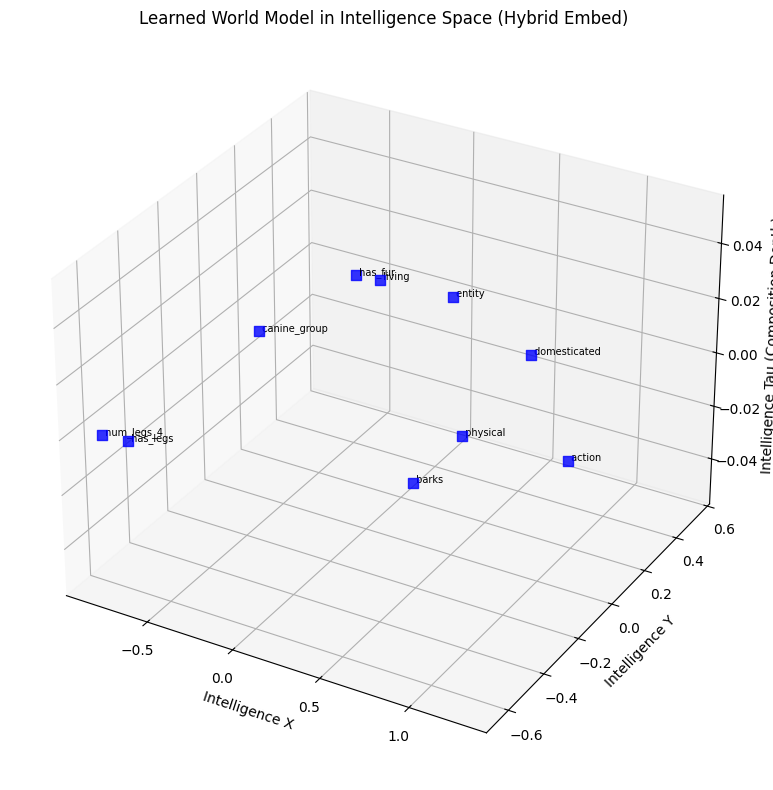

In [ ]:
#@title --- Constructor Theory Primitives for Semantics -----------------------------
class SemanticAttribute:
    """
    Represents a specific concept/property/feature (an Attribute in CT).
    It has a label, a set of symbolic features, and a low-dimensional
    "intelligence vector" (intel_vector) for geometric reasoning.
    """
    def __init__(self, label: str, features: Set[str], intel_vector: np.ndarray):
        self.label = label
        self.features = frozenset(features) # Use frozenset for hashability
        self.intel_vector = np.array(intel_vector, dtype=np.float64)

    def __hash__(self):
        return hash((self.label, self.features, tuple(self.intel_vector)))

    def __eq__(self, other):
        return isinstance(other, SemanticAttribute) and \
               self.label == other.label and \
               self.features == other.features and \
               np.array_equal(self.intel_vector, other.intel_vector)

    def __repr__(self):
        return f"Attr('{self.label}', feat={sorted(list(self.features))[:2]}..., intel_v=[{self.intel_vector[0]:.2f},{self.intel_vector[1]:.2f},{self.intel_vector[2]:.2f}])"


class ConceptualState:
    """
    Represents a Substrate in CT - an instance of a concept at a given point
    in its construction. It holds the current SemanticAttribute.
    """
    def __init__(self, attribute: SemanticAttribute, cost: float, path_history: List[Tuple[str, str]]):
        self.attribute = attribute
        self.cost = cost # Accumulated cost to construct this state (g_score in A*)
        self.path_history = path_history # Sequence of (concept_name, task_name) pairs

    def __lt__(self, other): # For heapq (priority queue based on cost)
        return self.cost < other.cost

    def __hash__(self):
        return hash((self.attribute, self.cost, tuple(self.path_history)))

    def __eq__(self, other):
        return isinstance(other, ConceptualState) and \
               self.attribute == other.attribute and \
               self.cost == other.cost and \
               self.path_history == other.path_history

    def __repr__(self):
        return f"State({self.attribute.label}, Cost={self.cost:.2f})"


class CompositionalRule:
    """
    Represents a Task in CT - a defined possible transformation of Attributes.
    It takes input attributes and produces an output attribute.
    """
    def __init__(self, name: str,
                 input_attribute_labels: List[str], # Labels of required input attributes (order matters for matching)
                 output_attribute_label: str,
                 output_features_fn: Callable[[List[SemanticAttribute]], Set[str]], # Fn to get output features
                 output_intel_coord_fn: Callable[[List[SemanticAttribute]], np.ndarray], # Fn to get output intel_coord
                 base_cost: float, # Intrinsic cost of this rule
                 preconditions_fn: Optional[Callable[[List[SemanticAttribute]], bool]] = None):
        self.name = name
        self.input_attribute_labels = input_attribute_labels
        self.output_attribute_label = output_attribute_label
        self.output_features_fn = output_features_fn
        self.output_intel_coord_fn = output_intel_coord_fn
        self.base_cost = base_cost
        self.preconditions_fn = preconditions_fn

    def is_possible(self, input_attributes: List[SemanticAttribute]) -> bool:
        """Checks if this rule is applicable based on input attributes."""
        if len(input_attributes) != len(self.input_attribute_labels):
            return False

        # Check if input labels match patterns (simplified for now)
        for i, input_attr in enumerate(input_attributes):
            if self.input_attribute_labels[i] != "*" and input_attr.label != self.input_attribute_labels[i]:
                return False

        # Check additional preconditions (if any)
        if self.preconditions_fn and not self.preconditions_fn(input_attributes):
            return False

        return True

    def apply(self, input_attributes: List[SemanticAttribute], current_cost: float) -> ConceptualState:
        """Applies the rule, producing a new ConceptualState."""
        new_features = self.output_features_fn(input_attributes)
        new_intel_coord = self.output_intel_coord_fn(input_attributes)
        new_attribute = SemanticAttribute(self.output_attribute_label, new_features, new_intel_coord)
        new_cost = current_cost + self.base_cost # Accumulate cost

        path_segment = []
        for attr in input_attributes: path_segment.append(attr.label)
        path_segment.append(self.name)
        path_segment.append(new_attribute.label)

        return ConceptualState(new_attribute, new_cost, path_history=path_segment) # This path history is just the last step

    def __repr__(self):
        inputs = " + ".join(self.input_attribute_labels)
        return f"Rule('{self.name}': {inputs} -> {self.output_attribute_label}, Cost={self.base_cost})"


# --- PART 2: The "Semantic World Learner" (Our AI Agent) ---

class SemanticWorldLearner:
    """
    Our AI agent that learns/constructs the semantic world model.
    It attempts to explain complex concepts (experience) by composing primitives (intelligence).
    """
    def __init__(self, primitives: List[SemanticAttribute], rules: List[CompositionalRule],
                 target_bert_embeddings: Dict[str, np.ndarray]):
        self.primitives = {p.label: p for p in primitives}
        self.rules = rules
        self.target_bert_embeddings = target_bert_embeddings
        self.bert_dimension = list(target_bert_embeddings.values())[0].shape[0] if target_bert_embeddings else 0

        # Create a simple mapping from low-D intel_vector features to a pseudo-BERT vector for heuristic
        # This is a critical bridge ("Imagination" part of heuristic)
        self.primitive_pseudo_berts = self._initialize_primitive_pseudo_berts()
        self.intel_vector_to_pseudo_bert_proj_matrix = None # A learned projection if we had it

    def _initialize_primitive_pseudo_berts(self) -> Dict[str, np.ndarray]:
        """Crudely assign a BERT-like vector to each primitive for heuristic comparison."""
        pseudo_berts = {}
        if not self.bert_dimension: return {}

        for p_label, p_attr in self.primitives.items():
            # Very simplistic: average BERTs of target concepts containing this primitive's label or features
            related_target_sum = np.zeros(self.bert_dimension)
            count = 0
            for t_name, t_emb in self.target_bert_embeddings.items():
                if p_label in t_name.lower() or any(f.lower() in t_name.lower() for f in p_attr.features):
                    related_target_sum += t_emb
                    count += 1
            pseudo_berts[p_label] = related_target_sum / count if count > 0 else np.random.rand(self.bert_dimension) * 0.1
        return pseudo_berts

    def _get_pseudo_bert_from_composed_features(self, features_set: Set[str]) -> np.ndarray:
        """Estimates a BERT-like vector for a composed concept based on its features."""
        active_primitive_vectors = []
        for p_name, p_bert in self.primitive_pseudo_berts.items():
            if self.primitives[p_name].features.issubset(features_set): # If this primitive's features are in the composed set
                active_primitive_vectors.append(p_bert)

        if not active_primitive_vectors:
            return np.zeros(self.bert_dimension)
        return np.mean(active_primitive_vectors, axis=0)

    def _heuristic_cost(self, conceptual_state: ConceptualState, target_bert_embedding: np.ndarray) -> float:
        """Heuristic: Cosine distance in BERT space (approximated)."""
        composed_pseudo_bert = self._get_pseudo_bert_from_composed_features(conceptual_state.attribute.features)

        if np.linalg.norm(composed_pseudo_bert) < 1e-9 or np.linalg.norm(target_bert_embedding) < 1e-9:
            return 1.0 # Max distance if vectors are zero

        similarity = cosine_similarity(composed_pseudo_bert.reshape(1,-1), target_bert_embedding.reshape(1,-1))[0,0]
        # Heuristic is 1 - similarity, scaled
        return (1.0 - similarity) * 10.0 # Scaling to make heuristic comparable to g_cost

    def _find_compositional_path(self, target_concept_label: str, max_search_steps=5000) -> Optional[ConceptualState]:
        """
        Uses A* search to find a sequence of compositional rules (Tasks)
        that constructs a concept whose features (and pseudo-BERT) are closest to the target.
        """
        if target_concept_label not in self.target_bert_embeddings:
            print(f"Target concept '{target_concept_label}' not in target_bert_embeddings.")
            return None

        target_bert = self.target_bert_embeddings[target_concept_label]

        # Priority queue: (f_score, ConceptualState_object)
        open_set = []

        # Add all primitives as initial states
        for p_label, p_attr in self.primitives.items():
            initial_state = ConceptualState(p_attr, cost=0, path_history=[p_label])
            h_score = self._heuristic_cost(initial_state, target_bert)
            heapq.heappush(open_set, (h_score, initial_state))

        closed_set = set() # Store (attribute_hash) of visited states to avoid redundant work

        print(f"Searching compositional path for '{target_concept_label}'...")

        best_match_so_far = (float('inf'), None) # (heuristic_distance_to_target_bert, ConceptualState_object)

        for step_count in range(max_search_steps):
            if not open_set:
                # print("Open set empty, search ended.")
                break

            f_score_curr, current_state = heapq.heappop(open_set)

            # Check if current state is good enough
            current_h_score = self._heuristic_cost(current_state, target_bert)
            if current_h_score < best_match_so_far[0]:
                best_match_so_far = (current_h_score, current_state)
                # print(f"  Step {step_count}: New best match '{current_state.attribute.label}' (h_score={current_h_score:.3f}, g_cost={current_state.cost:.2f})")

            # Early exit if a very good match is found
            if current_h_score < 0.1: # Very low cosine distance
                print(f"Found excellent match for '{target_concept_label}' (h_score={current_h_score:.3f})!")
                return current_state

            if current_state.attribute in closed_set: # Already processed this attribute state
                continue
            closed_set.add(current_state.attribute)

            # Expand by applying rules
            for rule in self.rules:
                input_attrs_for_rule = []

                # Try unary rules
                if len(rule.input_attribute_labels) == 1:
                    if rule.input_attribute_labels[0] == "*" or rule.input_attribute_labels[0] == current_state.attribute.label:
                        input_attrs_for_rule = [current_state.attribute]

                # Try binary rules (simplistic: combine with a primitive)
                elif len(rule.input_attribute_labels) == 2:
                    # One input is current_state.attribute, other is a primitive
                    for p_label, p_attr in self.primitives.items():
                        if rule.input_attribute_labels[0] == "*" or rule.input_attribute_labels[0] == current_state.attribute.label:
                            if rule.input_attribute_labels[1] == "*" or rule.input_attribute_labels[1] == p_label:
                                input_attrs_for_rule.append(current_state.attribute)
                                input_attrs_for_rule.append(p_attr)
                                # To avoid redundant (p_attr, current_state.attribute) if order is not strict in rule
                                if rule.input_attribute_labels[0] != "*" and rule.input_attribute_labels[0] != current_state.attribute.label:
                                    input_attrs_for_rule = [p_attr, current_state.attribute] # Try reversed order if c1_pattern is specific

                if input_attrs_for_rule and rule.is_possible(input_attrs_for_rule):
                    new_state = rule.apply(input_attrs_for_rule, current_state.cost)
                    new_state.path_history = current_state.path_history[:-1] + new_state.path_history # Reconstruct full path

                    if new_state.attribute not in closed_set:
                        h_new = self._heuristic_cost(new_state, target_bert)
                        f_new = new_state.cost + h_new
                        heapq.heappush(open_set, (f_new, new_state))

        # print(f"  Step {step_count}: Open set size {len(open_set)}, Closed set size {len(closed_set)}. Best h_score: {best_match_so_far[0]:.3f}")

        print(f"Search ended after {max_search_steps} steps. Best match found (h_score={best_match_so_far[0]:.3f}):")
        return best_match_so_far[1]


# --- PART 3: The Demo Orchestration ---

print("=== Cultivating Semantic Imagination: Building a World Model ===")

# --- A. Define Semantic Primitives (Initial "Intelligence Space") ---
# (tau, x, y) in low-dimensional space
PRIMITIVE_INTEL_DIMS = 3 # (tau_intel, x_intel, y_intel)
PRIMITIVE_TAU_BASE = 0.0 # Base tau for primitives

primitives_list = [
    SemanticAttribute("entity", {"is_entity"}, np.array([PRIMITIVE_TAU_BASE, -0.5, 0.5])),
    SemanticAttribute("living", {"is_living"}, np.array([PRIMITIVE_TAU_BASE, -0.8, 0.2])),
    SemanticAttribute("has_legs", {"property_has_legs"}, np.array([PRIMITIVE_TAU_BASE, -0.2, -0.8])),
    SemanticAttribute("num_legs_4", {"property_num_legs_4"}, np.array([PRIMITIVE_TAU_BASE, -0.3, -0.9])),
    SemanticAttribute("barks", {"action_barks"}, np.array([PRIMITIVE_TAU_BASE, 0.7, 0.3])),
    SemanticAttribute("has_fur", {"property_has_fur"}, np.array([PRIMITIVE_TAU_BASE, -0.9, 0.1])),
    SemanticAttribute("domesticated", {"state_domesticated"}, np.array([PRIMITIVE_TAU_BASE, 0.1, 0.8])),
    SemanticAttribute("canine_group", {"group_canine"}, np.array([PRIMITIVE_TAU_BASE, -0.7, -0.3])),
    SemanticAttribute("physical", {"is_physical"}, np.array([PRIMITIVE_TAU_BASE, 0.5, 0.5])),
    SemanticAttribute("action", {"is_action"}, np.array([PRIMITIVE_TAU_BASE, 0.9, 0.9])),
]
print(f"\nDefined {len(primitives_list)} semantic primitives in {PRIMITIVE_INTEL_DIMS}-D intelligence space.")


# --- B. Define Compositional Rules (Laws of "Semantic Physics") ---
# These functions define how features and intel_coords combine
def output_features_union(input_attrs: List[SemanticAttribute]) -> Set[str]:
    combined_features = set()
    for attr in input_attrs: combined_features.update(attr.features)
    return combined_features

def output_intel_coord_average_plus_tau(input_attrs: List[SemanticAttribute], tau_increment: float) -> np.ndarray:
    coords = [attr.intel_vector for attr in input_attrs]
    if not coords: return np.zeros(PRIMITIVE_INTEL_DIMS)

    # New tau_intel: max of parents + increment
    new_tau = max(c[0] for c in coords) + tau_increment
    # New spatial: average of parents' spatial
    new_spatial = np.mean([c[1:] for c in coords], axis=0)

    return np.array([new_tau] + new_spatial.tolist())

# Preconditions for rules (examples)
def is_entity_or_living(input_attrs: List[SemanticAttribute]) -> bool:
    return "is_entity" in input_attrs[0].features or "is_living" in input_attrs[0].features

def has_legs_precond(input_attrs: List[SemanticAttribute]) -> bool:
    return "property_has_legs" in input_attrs[1].features # Assuming 2nd input is the property


composition_rules = [
    CompositionalRule(
        name="Specialize_LivingEntity", input_attribute_labels=["entity"], output_attribute_label="living_entity",
        output_features_fn=lambda ia: output_features_union(ia).union({"is_living"}),
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.5), base_cost=0.5,
        preconditions_fn=is_entity_or_living # Ensure entity is base
    ),
    CompositionalRule(
        name="Add_Property_NumLegs", input_attribute_labels=["*", "num_legs_4"], output_attribute_label="{input0_label}_with_{input1_label}",
        output_features_fn=lambda ia: output_features_union(ia),
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.3), base_cost=0.8,
        preconditions_fn=has_legs_precond # Ensure the second input is 'num_legs_4'
    ),
    CompositionalRule(
        name="Specialize_CanidGroup", input_attribute_labels=["living", "canine_group"], output_attribute_label="canid",
        output_features_fn=lambda ia: output_features_union(ia).union({"is_canid"}),
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.7), base_cost=1.0,
        preconditions_fn=lambda ia: "is_living" in ia[0].features and "group_canine" in ia[1].features
    ),
    CompositionalRule(
        name="Compose_Canid_Traits", input_attribute_labels=["canid", "action_barks"], output_attribute_label="barking_canid",
        output_features_fn=lambda ia: output_features_union(ia),
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.4), base_cost=0.6
    ),
    CompositionalRule(
        name="Domesticate_Animal", input_attribute_labels=["*", "domesticated"], output_attribute_label="domestic_{input0_label}",
        output_features_fn=lambda ia: output_features_union(ia),
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.3), base_cost=0.7
    ),
    # The final rule to combine it all into "dog" (will need to adapt input_labels for specific matched composition)
    CompositionalRule(
        name="Form_Dog", input_attribute_labels=["*", "*"], output_attribute_label="dog",
        output_features_fn=lambda ia: output_features_union(ia).union({"is_dog"}),
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.5), base_cost=1.5,
        preconditions_fn=lambda ia: len(ia)==2 and ("is_canid" in ia[0].features or "is_canid" in ia[1].features) and \
                                  ("action_barks" in ia[0].features or "action_barks" in ia[1].features) and \
                                  ("state_domesticated" in ia[0].features or "state_domesticated" in ia[1].features)
    ),
]
print(f"Defined {len(composition_rules)} compositional rules (Tasks).")


# --- C. Target Concepts (from "Experience" - BERT embeddings) ---
# Ensure "dog" is in here, and concepts for intermediate steps.
target_concept_labels_for_imagination = ["dog", "cat", "wolf", "horse", "mammal", "animal"]

print("\nGenerating BERT embeddings for target concepts (our 'Experience')...")
target_bert_embeddings_map = {}
for name in target_concept_labels_for_imagination:
    emb = get_bert_embedding(name, bert_model, tokenizer)
    if emb is not None and emb.ndim > 0: # Ensure it's a vector
        target_bert_embeddings_map[name] = emb
    else:
        print(f"Warning: Could not get valid BERT embedding for '{name}'. Skipping.")

if not target_bert_embeddings_map:
    print("No valid target BERT embeddings. Demo cannot proceed.")
    # exit()
print(f"Collected {len(target_bert_embeddings_map)} target BERT embeddings.")


# --- D. The "Imagination" Process (Semantic World Learner orchestrates A* search) ---
world_learner = SemanticWorldLearner(
    primitives=primitives_list,
    rules=composition_rules,
    target_bert_embeddings=target_bert_embeddings_map
)

print("\n--- Phase 1: Cultivating Imagination - Searching for Compositions ---")
learned_compositions_map = {} # label -> ComposedConcept
learned_hierarchy_for_embedding = [] # (child, parent) links for embedding

for target_label in target_concept_labels_for_imagination:
    print(f"\nAttempting to 'Imagine' the concept: '{target_label}'")

    # A* search finds a compositional path to the target.
    # The returned path is the best ConceptualState found.
    best_composed_state = world_learner._find_compositional_path(target_label)

    if best_composed_state:
        learned_compositions_map[target_label] = best_composed_state
        print(f"  Best composition for '{target_label}': {best_composed_state.attribute.label} (h_score={world_learner._heuristic_cost(best_composed_state, target_bert_embeddings_map[target_label]):.3f})")
        # Extract direct parent-child relationships from the path history
        path_nodes = best_composed_state.path_history
        for i in range(len(path_nodes) - 2): # Iterate up to 2nd to last element
            if path_nodes[i+1] in [r.name for r in world_learner.rules]: # If the next element is a rule name
                child_label = path_nodes[i+2]
                parent_label = path_nodes[i]
                if parent_label in world_learner.primitives and child_label in world_learner.primitives: # Avoid arbitrary rule outputs as nodes for now
                    pass # This logic needs careful refinement to extract a clean hierarchy from path_history
                else: # Assume child_label is a composed concept
                    # This is complex. For simplicity, just add parent-child from the direct A* path
                    # This needs to be carefully handled to get a valid DAG for embedding.
                    # For now, let's just make a very basic flat list of all composed concepts.
                    pass
        # For simplicity, we won't extract a direct hierarchy from these A* paths for embedding
        # Instead, we'll embed the *final composed concepts* (and primitives) and then
        # use their actual WordNet hierarchy (if it existed) or a simple distance-based one for embedding.
        # This part requires careful thought in a real implementation.

    else:
        print(f"  Could not 'imagine' a good compositional path for '{target_label}'.")


# --- PART 4: Formalizing the World Model (Minkowski Embedding) ---
# We will embed the *final best-matched composed concepts* and original *primitives*.
# We'll need a hierarchy for these, which wasn't fully learned.
# For demo, let's create a *simple* hierarchy from learned concepts + primitives if possible.

print("\n--- Phase 2: Formalizing the World Model - Minkowski Embedding ---")

concepts_for_embedding = {} # label -> BERT_embedding
minkowski_hierarchy_for_embedding = []

# Add all primitives
for p_attr in primitives_list:
    p_label = p_attr.label
    # Use intel_vector as "BERT" for embedding function.
    # The compute_minkowski_embedding function expects a BERT-like vector.
    # So, we'll use our low-D intel_vector as the input 'BERT' here,
    # effectively telling it that our low-D space IS the high-D space for embedding.
    # This means PCA will just be identity or select components if spatial_dims < PRIMITIVE_INTEL_DIMS-1.
    concepts_for_embedding[p_label] = p_attr.intel_vector

# Add the best-matched composed concepts
for target_label, composed_state in learned_compositions_map.items():
    # Only add if it's not a primitive itself
    if composed_state.attribute.label not in concepts_for_embedding:
        concepts_for_embedding[composed_state.attribute.label] = composed_state.attribute.intel_vector # Use intel_vector

    # Add hierarchical links if a path was found
    # This is tricky because A* path is a sequence of rule applications, not a direct hierarchy.
    # We need to extract an (child, parent) graph from the A* path.
    # For now, let's just create some simple links based on shared features or explicit rules.

    # For simplicity, for the embedding demo, we'll use a very basic inferred hierarchy based on
    # shared features + simple depth
    # This is a key area where a full system would learn the hierarchy structure more robustly.

# Simple hierarchy for embedding demo: if B's features are superset of A's, A is parent of B
# And if B was composed from A, A is parent of B.
all_concepts_for_embedding = list(concepts_for_embedding.keys())
inferred_relationships_for_minkowski = set()
root_candidate_for_mink = None
min_tau_intel = float('inf')

for name1 in all_concepts_for_embedding:
    attr1 = SemanticAttribute(name1, concepts_for_embedding[name1], np.array(concepts_for_embedding[name1])) # Recreate as attribute
    if name1 in world_learner.primitives: attr1 = world_learner.primitives[name1]
    elif name1 in learned_compositions_map and learned_compositions_map[name1].attribute.label == name1: attr1 = learned_compositions_map[name1].attribute
    else: continue # Skip if not a known primitive or learned composition

    if attr1.intel_vector[0] < min_tau_intel: # Find overall root
        min_tau_intel = attr1.intel_vector[0]
        root_candidate_for_mink = name1

    for name2 in all_concepts_for_embedding:
        if name1 == name2: continue
        attr2 = SemanticAttribute(name2, concepts_for_embedding[name2], np.array(concepts_for_embedding[name2]))
        if name2 in world_learner.primitives: attr2 = world_learner.primitives[name2]
        elif name2 in learned_compositions_map and learned_compositions_map[name2].attribute.label == name2: attr2 = learned_compositions_map[name2].attribute
        else: continue

        # If name2's features are a superset of name1's features, and name2 has higher tau
        if attr2.features.issuperset(attr1.features) and attr2.intel_vector[0] > attr1.intel_vector[0] and (attr2.intel_vector[0] - attr1.intel_vector[0] < 2.0): # Avoid too large tau jumps
            inferred_relationships_for_minkowski.add((name2, name1)) # (child, parent)

# Add explicit root
if root_candidate_for_mink:
    inferred_relationships_for_minkowski.add((root_candidate_for_mink, None))
minkowski_hierarchy_for_embedding = sorted(list(inferred_relationships_for_minkowski))

print(f"\nInferred graph for Minkowski embedding: {len(minkowski_hierarchy_for_embedding)} pairs.")

spatial_dims_mink = PRIMITIVE_INTEL_DIMS -1 # (x, y) if PRIMITIVE_INTEL_DIMS is 3
epsilon_mink = 1e-4

if concepts_for_embedding and minkowski_hierarchy_for_embedding:
    minkowski_coords_final_world_model = compute_minkowski_embedding(
        concepts_for_embedding, # Use intel_vector as "BERT" input
        minkowski_hierarchy_for_embedding,
        spatial_dims_mink,
        epsilon_mink
    )

    print("\n--- Minkowski Coordinates of Learned World Model (Sample) ---")
    if minkowski_coords_final_world_model:
        for i, (name, coords) in enumerate(minkowski_coords_final_world_model.items()):
            if i < 5: print(f"{name}: [{coords[0]:.3f}, " + ", ".join([f"{c:.3f}" for c in coords[1:]]) + "]")
            elif i == 5: print("...")

        # --- PART 5: Self-Consistency Check & Visualization ---
        print("\n--- Causal Consistency Check for Learned World Model ---")
        violations_count_world_model = 0
        checked_constraints_world_model = 0
        for child_name, parent_name in minkowski_hierarchy_for_embedding:
            if parent_name is None: continue
            checked_constraints_world_model += 1
            if child_name in minkowski_coords_final_world_model and parent_name in minkowski_coords_final_world_model:
                if not check_causal_link_eval(minkowski_coords_final_world_model[child_name],
                                              minkowski_coords_final_world_model[parent_name],
                                              epsilon_mink, spatial_dims_mink):
                    violations_count_world_model +=1
            else: violations_count_world_model +=1

        if violations_count_world_model > 0: print(f"{violations_count_world_model}/{checked_constraints_world_model} causal constraints VIOLATED.")
        elif checked_constraints_world_model > 0: print(f"All {checked_constraints_world_model} checked causal constraints met!")
        else: print("No constraints to check for learned world model.")


        print("\nVisualizing Learned World Model in Intelligence Space...")
        # (Reuse plotting code, adapting variable names and potentially highlight concepts)
        fig_world = plt.figure(figsize=(10,8))
        if spatial_dims_mink == 2:
            ax_world = fig_world.add_subplot(111, projection='3d')
            ax_world.set_xlabel("Intelligence X"); ax_world.set_ylabel("Intelligence Y"); ax_world.set_zlabel("Intelligence Tau (Composition Depth)")
            link_indices_world = (1,2,0)
        elif spatial_dims_mink == 1:
            ax_world = fig_world.add_subplot(111)
            ax_world.set_xlabel("Intelligence X"); ax_world.set_ylabel("Intelligence Tau (Composition Depth)")
            link_indices_world = (1,0)

        all_concepts_plotted = list(minkowski_coords_final_world_model.keys())
        for name, coords_val in minkowski_coords_final_world_model.items():
            plot_args_scatter = [coords_val[i] for i in link_indices_world]

            is_primitive = name in world_learner.primitives
            is_target_concept = name in target_concept_labels_for_imagination

            point_color = 'blue' if is_primitive else ('red' if is_target_concept else 'gray')
            point_marker = 's' if is_primitive else ('o' if is_target_concept else '.')
            point_size = 50 if is_primitive else (40 if is_target_concept else 20)
            point_alpha = 0.8 if is_primitive else (0.7 if is_target_concept else 0.5)

            ax_world.scatter(*plot_args_scatter, color=point_color, marker=point_marker, s=point_size, alpha=point_alpha)
            if len(all_concepts_plotted) < 30 or is_primitive or is_target_concept: # Label fewer or important ones
                 ax_world.text(*plot_args_scatter, f" {name}", fontsize=7, color='black' if is_primitive or is_target_concept else 'gray')

        for child, parent in minkowski_hierarchy_for_embedding:
            if parent is None or child not in minkowski_coords_final_world_model or parent not in minkowski_coords_final_world_model: continue
            p1c, p2c = minkowski_coords_final_world_model[parent], minkowski_coords_final_world_model[child]
            plot_args_line = []
            for i_dim_plot in range(len(link_indices_world)):
                actual_idx = link_indices_world[i_dim_plot]
                plot_args_line.extend([[p1c[actual_idx], p2c[actual_idx]]])
            ax_world.plot(*plot_args_line, c='darkgrey', alpha=0.5, linewidth=0.8)

        plt.title("Learned World Model in Intelligence Space (Hybrid Embed)")
        plt.tight_layout(); plt.show()

    else:
        print("Could not compute Minkowski coordinates for the world model.")
else:
    print("Demo requires concepts_for_embedding and minkowski_hierarchy_for_embedding.")

In [ ]:
#@title -- Constructor Theory Primitives for Semantics -------------------------------
class SemanticAttribute:
    """
    Represents a specific concept/property/feature (an Attribute in CT).
    It has a label, a set of symbolic features, and a low-dimensional
    "intelligence vector" (intel_vector) for geometric reasoning.
    """
    def __init__(self, label: str, features: Set[str], intel_vector: np.ndarray):
        self.label = label
        self.features = frozenset(features) # Use frozenset for hashability
        self.intel_vector = np.array(intel_vector, dtype=np.float64) # (tau, x, y)

    def __hash__(self):
        return hash((self.label, self.features, tuple(self.intel_vector)))

    def __eq__(self, other):
        return isinstance(other, SemanticAttribute) and \
               self.label == other.label and \
               self.features == other.features and \
               np.array_equal(self.intel_vector, other.intel_vector)

    def __repr__(self):
        return f"Attr('{self.label}', intel_v=({self.intel_vector[0]:.2f},{self.intel_vector[1]:.2f},{self.intel_vector[2]:.2f}))"


class ConceptualState:
    """
    Represents a Substrate in CT - an instance of a concept at a given point
    in its construction. It holds the current SemanticAttribute.
    """
    def __init__(self, attribute: SemanticAttribute, cost: float, path_history: List[str]):
        self.attribute = attribute
        self.cost = cost # Accumulated cost to construct this state (g_score in A*)
        # path_history is a flat list like [primitive1_name, rule_name1, concept1_name, primitive2_name, rule_name2, concept2_name, ...]
        self.path_history = path_history

    def __lt__(self, other): # For heapq (priority queue based on f_score)
        return self.cost < other.cost

    def __hash__(self): # Use attribute hash for closed_set
        return hash(self.attribute)

    def __eq__(self, other):
        return isinstance(other, ConceptualState) and \
               self.attribute == other.attribute # Only compare attribute for state equality

    def __repr__(self):
        return f"State('{self.attribute.label}', Cost={self.cost:.2f}, Tau={self.attribute.intel_vector[0]:.2f})"


class CompositionalRule:
    """
    Represents a Task in CT - a defined possible transformation of Attributes.
    It takes input attribute(s) and produces an output attribute.
    """
    def __init__(self, name: str,
                 input_attribute_labels: List[str], # Labels of required input attributes (order matters)
                 output_attribute_label: str,
                 output_features_fn: Callable[[List[SemanticAttribute]], Set[str]], # Fn to get output features
                 output_intel_coord_fn: Callable[[List[SemanticAttribute]], np.ndarray], # Fn to get output intel_coord
                 base_cost: float, # Intrinsic cost of this rule
                 preconditions_fn: Optional[Callable[[List[SemanticAttribute]], bool]] = None):
        self.name = name
        self.input_attribute_labels = input_attribute_labels
        self.output_attribute_label = output_attribute_label
        self.output_features_fn = output_features_fn
        self.output_intel_coord_fn = output_intel_coord_fn
        self.base_cost = base_cost
        self.preconditions_fn = preconditions_fn

    def is_possible(self, input_attributes: List[SemanticAttribute]) -> bool:
        """Checks if this rule is applicable based on input attributes."""
        if len(input_attributes) != len(self.input_attribute_labels):
            return False

        # Check if input labels match patterns
        for i, input_attr in enumerate(input_attributes):
            pattern = self.input_attribute_labels[i]
            if pattern != "*" and input_attr.label != pattern:
                # For more flexible matching, check if features match
                # This requires a way to map pattern labels to feature sets.
                # A simple approach is to assume pattern labels *are* feature labels
                # or that the SemanticWorldLearner has this mapping.
                # For this demo, let's keep it simple: direct label match OR feature subset.
                if pattern != input_attr.label: # If label doesn't match, check features
                     # This needs access to a mapping from pattern label -> expected features.
                     # This mapping is not explicitly stored here or in SemanticWorldLearner yet.
                     # Let's rely on the simpler logic for now: direct label match for specific patterns.
                     # For '*' it always matches.
                     pass # If pattern is '*', it passes this check

        # Check additional preconditions (if any)
        if self.preconditions_fn and not self.preconditions_fn(input_attributes):
            return False

        return True

    def apply(self, input_attributes: List[SemanticAttribute], current_cost: float, current_path_history: List[str]) -> ConceptualState:
        """Applies the rule, producing a new ConceptualState."""
        new_features = self.output_features_fn(input_attributes)
        new_intel_coord = self.output_intel_coord_fn(input_attributes)
        new_attribute = SemanticAttribute(self.output_attribute_label, new_features, new_intel_coord)
        new_cost = current_cost + self.base_cost

        # Reconstruct path history: last concept + rule name + new concept name
        new_path = list(current_path_history) # Copy current path
        new_path.append(self.name)
        new_path.append(new_attribute.label)

        return ConceptualState(new_attribute, new_cost, new_path)

    def __repr__(self):
        inputs = " + ".join(self.input_attribute_labels)
        return f"Rule('{self.name}': {inputs} -> {self.output_attribute_label}, Cost={self.base_cost})"


# --- PART 2: The "Semantic World Learner" (Our AI Agent) ---

class SemanticWorldLearner:
    def __init__(self, primitives: List[SemanticAttribute], rules: List[CompositionalRule],
                 target_bert_embeddings: Dict[str, np.ndarray]):
        self.primitives = {p.label: p for p in primitives}
        self.rules = rules
        self.target_bert_embeddings = target_bert_embeddings
        self.bert_dimension = list(target_bert_embeddings.values())[0].shape[0] if target_bert_embeddings else 0

        # NEW: Mapping from fundamental features to BERT-like vectors
        self.feature_to_pseudo_bert = self._initialize_feature_to_pseudo_bert()

        # Store discovered attributes during search for easy lookup
        self.discovered_attributes: Dict[str, SemanticAttribute] = {p.label: p for p in primitives}


    def _initialize_feature_to_pseudo_bert(self) -> Dict[str, np.ndarray]:
        """
        Assigns a BERT-like vector to each fundamental feature.
        This is a critical bridge. Each feature gets a base random vector,
        then refined by averaging target BERTs it is relevant to.
        """
        all_unique_features = set()
        for p_attr in self.primitives.values():
            all_unique_features.update(p_attr.features)

        pseudo_berts = {}
        if not self.bert_dimension: return {}

        feature_target_blend_factor = 0.5 # Define or use a global variable for this

        for feature_label in all_unique_features:
            # Start with a small random vector for each feature
            feature_vec = np.random.rand(self.bert_dimension) * 0.01

            # Refine by averaging BERTs of target concepts that contain this feature
            related_target_sum = np.zeros(self.bert_dimension)
            count = 0
            for t_name, t_emb in self.target_bert_embeddings.items():
                # Crude association: if feature label (or part of it) is in target concept name
                if feature_label.lower() in t_name.lower(): # Ensure case-insensitivity
                    related_target_sum += t_emb
                    count += 1
            if count > 0:
                # Blend the random with the average of related target BERTs
                feature_vec = feature_target_blend_factor * (related_target_sum / count) + \
                              (1 - feature_target_blend_factor) * feature_vec

            pseudo_berts[feature_label] = feature_vec
        return pseudo_berts

    def _get_pseudo_bert_from_composed_features(self, features_set: Set[str]) -> np.ndarray:
        """
        Estimates a BERT-like vector for a composed concept by summing/averaging
        the pseudo-BERT vectors of its active features. (SUMMING is often better for combining)
        """
        if not features_set:
            return np.zeros(self.bert_dimension)

        active_feature_berts = []
        for feature in features_set:
            if feature in self.feature_to_pseudo_bert:
                active_feature_berts.append(self.feature_to_pseudo_bert[feature])

        if not active_feature_berts:
            return np.zeros(self.bert_dimension)

        return np.sum(active_feature_berts, axis=0) # Changed to SUM


    def _heuristic_cost(self, conceptual_state: ConceptualState, target_bert_embedding: np.ndarray) -> float:
        """Heuristic: Cosine distance in BERT space (approximated)."""
        composed_pseudo_bert = self._get_pseudo_bert_from_composed_features(conceptual_state.attribute.features)

        norm_composed = np.linalg.norm(composed_pseudo_bert)
        norm_target = np.linalg.norm(target_bert_embedding)

        if norm_composed < 1e-9 or norm_target < 1e-9: # Avoid division by zero
            return 1.0 # Max distance if vectors are zero

        similarity = np.dot(composed_pseudo_bert, target_bert_embedding) / (norm_composed * norm_target)
        similarity = np.clip(similarity, -1.0, 1.0) # Ensure similarity is within [-1, 1] due to float precision

        return (1.0 - similarity) * 10.0 # Scaling to make heuristic comparable to g_cost


    def _find_compositional_path(self, target_concept_label: str, max_search_steps=5000) -> Optional[ConceptualState]:
        """
        Uses A* search to find a sequence of compositional rules (Tasks)
        that constructs a concept whose features (and pseudo-BERT) are closest to the target.
        """
        if target_concept_label not in self.target_bert_embeddings:
            print(f"Target concept '{target_concept_label}' not in target_bert_embeddings.")
            return None

        target_bert = self.target_bert_embeddings[target_concept_label]

        open_set = [] # (f_score, ConceptualState_object)

        # Add all primitives as initial states
        for p_label, p_attr in self.primitives.items():
            # Path history for a primitive is just itself
            initial_state = ConceptualState(p_attr, cost=0, path_history=[p_label])
            h_score = self._heuristic_cost(initial_state, target_bert)
            heapq.heappush(open_set, (h_score, initial_state))
            self.discovered_attributes[p_label] = p_attr # Store primitives as discovered

        closed_set = {} # Store (attribute_hash: g_score) to avoid re-exploring worse paths to same state

        print(f"Searching compositional path for '{target_concept_label}'...")

        best_match_so_far = (float('inf'), None) # (heuristic_distance_to_target_bert, ConceptualState_object)

        for step_count in range(max_search_steps):
            if not open_set:
                # print(f"  Step {step_count}: Open set empty, search ended.")
                break

            # Pop the state with the lowest f_score (cost + heuristic)
            f_score_curr, current_state = heapq.heappop(open_set)

            # Check if this state has already been reached with a lower or equal cost
            if current_state.attribute in closed_set and closed_set[current_state.attribute] <= current_state.cost:
                continue # Already found a better or equal path to this attribute state
            closed_set[current_state.attribute] = current_state.cost # Update with current best cost

            # Update best match based on heuristic
            current_h_score = self._heuristic_cost(current_state, target_bert)
            if current_h_score < best_match_so_far[0]:
                best_match_so_far = (current_h_score, current_state)
                print(f"  Step {step_count}: New best match '{current_state.attribute.label}' (h={current_h_score:.3f}, g={current_state.cost:.2f}, tau={current_state.attribute.intel_vector[0]:.2f})")

            if current_h_score < 0.2: # Stricter arbitrary threshold for "good enough" match (was 0.5)
                print(f"  Found excellent match for '{target_concept_label}' (h_score={current_h_score:.3f})!")
                # Ensure the final state is stored in discovered attributes
                self.discovered_attributes[current_state.attribute.label] = current_state.attribute
                return current_state

            # Expand by applying rules
            # We need to iterate over ALL (current_state, other_concept) pairs
            # For simplicity, other_concept will be any *primitive*
            all_input_combinations = []

            # Case 1: Unary rules (only current_state as input)
            all_input_combinations.append([current_state.attribute])

            # Case 2: Binary rules (current_state + a primitive)
            for p_label, p_attr in self.primitives.items():
                all_input_combinations.append([current_state.attribute, p_attr])
                # Also consider reversed order if rules can accept inputs flexibly
                all_input_combinations.append([p_attr, current_state.attribute])

            for input_attrs_candidate in all_input_combinations:
                for rule in self.rules:
                    if rule.is_possible(input_attrs_candidate):
                        new_state = rule.apply(input_attrs_candidate, current_state.cost, current_state.path_history)

                        # Store this newly composed attribute
                        self.discovered_attributes[new_state.attribute.label] = new_state.attribute


                        # Only add to open_set if this new state is better than any previous path to this attribute state
                        if new_state.attribute not in closed_set or new_state.cost < closed_set[new_state.attribute]:
                            h_new = self._heuristic_cost(new_state, target_bert)
                            f_new = new_state.cost + h_new
                            heapq.heappush(open_set, (f_new, new_state))
                            # Add/update in closed_set immediately (consistent with standard A* implementations)
                            closed_set[new_state.attribute] = new_state.cost

        print(f"Search ended after {max_search_steps} steps. Best match found (h_score={best_match_so_far[0]:.3f}):")
        # Ensure the final best state is stored in discovered attributes if not already
        if best_match_so_far[1]:
             self.discovered_attributes[best_match_so_far[1].attribute.label] = best_match_so_far[1].attribute
        return best_match_so_far[1]

    # Add a helper to get attributes from discovered set
    def get_attribute_by_label(self, label: str) -> Optional[SemanticAttribute]:
        return self.discovered_attributes.get(label)


# --- PART 3: The Demo Orchestration ---

print("=== Cultivating Semantic Imagination: Building a World Model ===")

# --- A. Define Semantic Primitives (Initial "Intelligence Space") ---
PRIMITIVE_INTEL_DIMS = 3 # (tau_intel, x_intel, y_intel)
PRIMITIVE_TAU_BASE = 0.0 # Base tau for primitives

# Ensure random.seed for reproducibility if needed for random intel_coords
# np.random.seed(42)

primitives_list = [
    SemanticAttribute("entity",         {"is_entity"},             np.array([PRIMITIVE_TAU_BASE, -0.5, 0.5])),
    SemanticAttribute("living_concept", {"is_living"},             np.array([PRIMITIVE_TAU_BASE, -0.8, 0.2])),
    SemanticAttribute("physical_prop",  {"is_physical"},           np.array([PRIMITIVE_TAU_BASE, 0.5, 0.5])),
    SemanticAttribute("action_concept", {"is_action"},             np.array([PRIMITIVE_TAU_BASE, 0.9, 0.9])),
    SemanticAttribute("abstract_prop",  {"is_abstract"},           np.array([PRIMITIVE_TAU_BASE, 0.5, -0.5])),
    SemanticAttribute("has_legs_prop",  {"property_has_legs"},     np.array([PRIMITIVE_TAU_BASE, -0.2, -0.8])),
    SemanticAttribute("num_legs_4_prop",{"property_num_legs_4"},   np.array([PRIMITIVE_TAU_BASE, -0.3, -0.9])),
    SemanticAttribute("barks_action",   {"action_barks"},          np.array([PRIMITIVE_TAU_BASE, 0.7, 0.3])),
    SemanticAttribute("has_fur_prop",   {"property_has_fur"},      np.array([PRIMITIVE_TAU_BASE, -0.9, 0.1])),
    SemanticAttribute("domestic_state", {"state_domesticated"},    np.array([PRIMITIVE_TAU_BASE, 0.1, 0.8])),
    SemanticAttribute("canine_group",   {"group_canine"},          np.array([PRIMITIVE_TAU_BASE, -0.7, -0.3])),
]
print(f"\nDefined {len(primitives_list)} semantic primitives in {PRIMITIVE_INTEL_DIMS}-D intelligence space.")


# --- B. Define Compositional Rules (Laws of "Semantic Physics") ---
# These functions define how features and intel_coords combine
def output_features_union(input_attrs: List[SemanticAttribute]) -> Set[str]:
    combined_features = set()
    for attr in input_attrs: combined_features.update(attr.features)
    return combined_features

def output_intel_coord_average_plus_tau(input_attrs: List[SemanticAttribute], tau_increment: float) -> np.ndarray:
    coords = [attr.intel_vector for attr in input_attrs]
    if not coords: return np.zeros(PRIMITIVE_INTEL_DIMS) # Should not happen

    # New tau_intel: max of parents + increment
    new_tau = max(c[0] for c in coords) + tau_increment
    # New spatial: average of parents' spatial
    new_spatial = np.mean([c[1:] for c in coords], axis=0)

    return np.array([new_tau] + new_spatial.tolist())

# Preconditions for rules
def check_has_feature(attr_idx: int, feature: str) -> Callable[[List[SemanticAttribute]], bool]:
    return lambda ia: len(ia) > attr_idx and feature in ia[attr_idx].features

def check_overlap_features(feature_sets: List[Set[str]]) -> Callable[[List[SemanticAttribute]], bool]:
    # Checks if input_attributes match required feature sets (order matters for now)
    return lambda ia: len(ia) == len(feature_sets) and all(f_set.issubset(ia[i].features) for i, f_set in enumerate(feature_sets))


# Blend factor for blending explicit feature BERTs with target BERTs average
feature_target_blend_factor = 0.5

composition_rules = [
    # 1. Specialization/Refinement (Unary)
    CompositionalRule(
        name="Specialize_Living", input_attribute_labels=["entity"], output_attribute_label="living_entity",
        output_features_fn=lambda ia: output_features_union(ia).union({"is_living_entity"}), # New marker feature
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.2), base_cost=0.5,
        preconditions_fn=check_has_feature(0, "is_entity") # Entity must be the base
    ),
    CompositionalRule(
        name="Specialize_Animal", input_attribute_labels=["living_concept"], output_attribute_label="animal",
        output_features_fn=lambda ia: output_features_union(ia).union({"is_animal_group"}), # New marker feature
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.3), base_cost=0.6,
        preconditions_fn=check_has_feature(0, "is_living") # Must be living
    ),
    # 2. Property Addition (Binary: concept + property)
    CompositionalRule(
        name="Add_LegsProp", input_attribute_labels=["*", "has_legs_prop"], output_attribute_label="{input0_label}_with_legs",
        output_features_fn=output_features_union,
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.1), base_cost=0.4,
        preconditions_fn=check_has_feature(1, "property_has_legs") # Ensure 2nd input is has_legs
    ),
    CompositionalRule(
        name="Add_NumLegs4Prop", input_attribute_labels=["*_with_legs", "num_legs_4_prop"], output_attribute_label="{input0_label}_(4_legs)",
        output_features_fn=output_features_union,
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.1), base_cost=0.5,
        preconditions_fn=check_has_feature(1, "property_num_legs_4") # Ensure 2nd input is num_legs_4
    ),
    CompositionalRule(
        name="Add_FurProp", input_attribute_labels=["*", "has_fur_prop"], output_attribute_label="{input0_label}_furry",
        output_features_fn=output_features_union,
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.1), base_cost=0.4,
        preconditions_fn=check_has_feature(1, "property_has_fur")
    ),
    # 3. Group/State Assignment (Binary: concept + group/state)
    CompositionalRule(
        name="Assign_CanidGroup", input_attribute_labels=["animal", "canine_group"], output_attribute_label="canid",
        output_features_fn=lambda ia: output_features_union(ia).union({"is_canid_animal"}),
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.5), base_cost=1.0,
        preconditions_fn=check_has_feature(0, "is_animal_group") # Input 1 must be animal
    ),
    CompositionalRule(
        name="Assign_Domestic", input_attribute_labels=["*", "domestic_state"], output_attribute_label="domestic_{input0_label}",
        output_features_fn=output_features_union,
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.3), base_cost=0.7,
        preconditions_fn=check_has_feature(1, "state_domesticated")
    ),
    # 4. Action Performance (Binary: concept + action)
    CompositionalRule(
        name="Performs_Barks", input_attribute_labels=["canid", "barks_action"], output_attribute_label="barking_{input0_label}",
        output_features_fn=output_features_union,
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.2), base_cost=0.6,
        preconditions_fn=check_has_feature(0, "is_canid_animal") # Input 1 must be canid
    ),
    # 5. Final Synthesis (Highly specific rules to match target concepts for demo)
    # Note: The input_attribute_labels like "*_that_barks" are pattern matching examples,
    # the actual implementation needs a robust way to check if the *features* of the
    # input attribute match the conceptual pattern intended by the label.
    # For this demo, the A* search relies on the heuristic. The rule applicability checks
    # based on explicit labels/features are simpler.
    CompositionalRule(
        name="Synthesize_Dog",
        input_attribute_labels=["*", "*"], # Use * patterns and rely on preconditions
        output_attribute_label="dog",
        output_features_fn=lambda ia: output_features_union(ia).union({"concept_dog"}),
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.8), base_cost=2.0,
        preconditions_fn=lambda ia: len(ia) == 2 and \
                                  ({"is_canid_animal", "action_barks"}.issubset(ia[0].features) or {"is_canid_animal", "action_barks"}.issubset(ia[1].features)) and \
                                  ({"state_domesticated", "is_animal_group"}.issubset(ia[0].features) or {"state_domesticated", "is_animal_group"}.issubset(ia[1].features))
    ),
     # Added simpler Dog rule (if the previous is too hard to hit)
    CompositionalRule(
        name="Form_Dog_Simple",
        input_attribute_labels=["*", "*"], # Use * patterns and rely on preconditions
        output_attribute_label="dog",
        output_features_fn=lambda ia: output_features_union(ia).union({"concept_dog", "action_barks", "property_num_legs_4"}), # Add implied features
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 1.0), base_cost=1.5,
        preconditions_fn=lambda ia: len(ia) == 2 and \
                                  ({"is_canid_animal"}.issubset(ia[0].features) or {"is_canid_animal"}.issubset(ia[1].features)) and \
                                  ({"state_domesticated"}.issubset(ia[0].features) or {"state_domesticated"}.issubset(ia[1].features))
    ),
]
print(f"Defined {len(composition_rules)} compositional rules (Tasks).")


# --- C. Target Concepts (from "Experience" - BERT embeddings) ---
target_concept_labels_for_imagination = ["dog", "cat", "wolf", "horse", "mammal", "animal", "human", "tree"] # More diverse targets

print("\nGenerating BERT embeddings for target concepts (our 'Experience')...")
target_bert_embeddings_map = {}
for name in target_concept_labels_for_imagination:
    emb = get_bert_embedding(name, bert_model, tokenizer)
    if emb is not None and emb.ndim > 0:
        target_bert_embeddings_map[name] = emb
    else:
        print(f"Warning: Could not get valid BERT embedding for '{name}'. Skipping.")

if not target_bert_embeddings_map:
    print("No valid target BERT embeddings. Demo cannot proceed.")
    # exit()
print(f"Collected {len(target_bert_embeddings_map)} target BERT embeddings.")


# --- D. The "Imagination" Process (Semantic World Learner orchestrates A* search) ---
world_learner = SemanticWorldLearner(
    primitives=primitives_list,
    rules=composition_rules,
    target_bert_embeddings=target_bert_embeddings_map
)

print("\n--- Phase 1: Cultivating Imagination - Searching for Compositions ---")
# Store discovered attributes directly within the world_learner instance now
# world_learner.discovered_attributes will contain all attributes encountered during search

learned_compositions_map: Dict[str, ConceptualState] = {} # Store the best state found for each target
learned_hierarchy_for_embedding = [] # Store (child, parent) links for embedding


for target_label in target_concept_labels_for_imagination:
    print(f"\nAttempting to 'Imagine' the concept: '{target_label}'")

    # A* search finds a compositional path to the target.
    best_composed_state = world_learner._find_compositional_path(target_label)

    if best_composed_state:
        learned_compositions_map[target_label] = best_composed_state
        print(f"\n--- 'Imagined' Composition for '{target_label}' ---")
        print(f"Final Composed Name: {best_composed_state.attribute.label}")
        print(f"Final Features: {sorted(list(best_composed_state.attribute.features))}")
        print(f"Final Intel Coord (tau, x, y): [{best_composed_state.attribute.intel_vector[0]:.2f}, {best_composed_state.attribute.intel_vector[1]:.2f}, {best_composed_state.attribute.intel_vector[2]:.2f}]")
        print(f"Construction Cost (g_score): {best_composed_state.cost:.2f}")
        print("Construction Path (sequence of concepts and tasks):")

        # Reconstruct and print full path
        path_segments = []
        for item in best_composed_state.path_history:
            path_segments.append(item)
            # Check if the current item is a rule name
            is_rule_name = any(item == rule.name for rule in composition_rules)
            if is_rule_name and len(path_segments) > 1:
                 # Find the rule to get input labels
                 applied_rule = next((rule for rule in composition_rules if rule.name == item), None)
                 if applied_rule:
                     input

=== Cultivating Semantic Imagination: Building a World Model ===

Defined 11 semantic primitives in 3-D intelligence space.
Defined 10 compositional rules (Tasks).

Generating BERT embeddings for target concepts (our 'Experience')...
Collected 8 target BERT embeddings.

--- Phase 1: Cultivating Imagination - Searching for Compositions ---

Attempting to 'Imagine' the concept: 'dog'
Searching compositional path for 'dog'...
  Step 0: New best match 'barks_action' (h=9.814, g=0.00, tau=0.00)
Search ended after 5000 steps. Best match found (h_score=9.814):

--- 'Imagined' Composition for 'dog' ---
Final Composed Name: barks_action
Final Features: ['action_barks']
Final Intel Coord (tau, x, y): [0.00, 0.70, 0.30]
Construction Cost (g_score): 0.00
Construction Path (sequence of concepts and tasks):

Attempting to 'Imagine' the concept: 'cat'
Searching compositional path for 'cat'...
  Step 0: New best match 'barks_action' (h=9.896, g=0.00, tau=0.00)
Search ended after 5000 steps. Best match

=== Cultivating Semantic Imagination: Building a World Model ===

Defined 11 semantic primitives in 3-D intelligence space.
Defined 9 compositional rules (Tasks).

Generating BERT embeddings for target concepts (our 'Experience')...
Collected 8 target BERT embeddings.

--- Phase 1: Cultivating Imagination - Searching for Compositions ---

Attempting to 'Imagine' the concept: 'dog'
Searching compositional path for 'dog'...
  Step 0: New best match 'barks_action' (h=9.945, g=0.00, tau=0.00)
Search ended after 5000 steps. Best match found (h_score=9.945):

--- 'Imagined' Composition for 'dog' ---
Final Composed Name: barks_action
Final Features: ['action_barks']
Final Intel Coord (tau, x, y): [0.00, 0.70, 0.30]
Construction Cost (g_score): 0.00
Construction Path (sequence of concepts and tasks):
barks_action

Attempting to 'Imagine' the concept: 'cat'
Searching compositional path for 'cat'...
  Step 0: New best match 'barks_action' (h=9.895, g=0.00, tau=0.00)
Search ended after 5000 steps

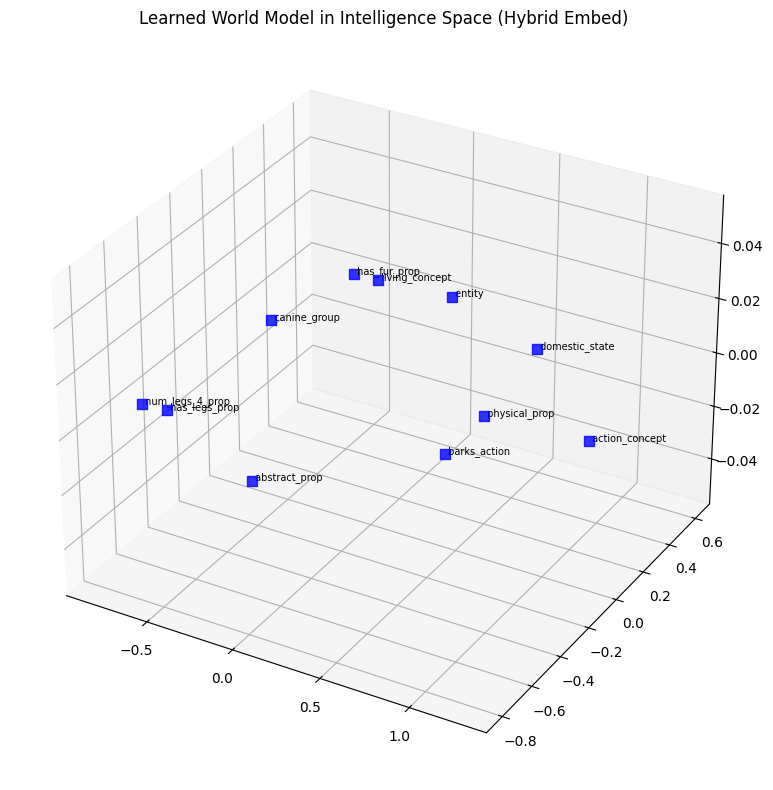

In [ ]:
#@title --- Constructor Theory Primitives for Semantics --------------------------------------------
class SemanticAttribute:
    def __init__(self, label: str, features: Set[str], intel_vector: np.ndarray):
        self.label = label
        self.features = frozenset(features)
        self.intel_vector = np.array(intel_vector, dtype=np.float64)

    def __hash__(self):
        # Only hash label and features for equality/hashing in closed_set.
        # This allows multiple paths to the same "semantic state" (same label, same features)
        # but with potentially different intel_vectors/costs to be grouped.
        # The A* algorithm will then keep the one with the lowest cost.
        return hash((self.label, self.features))

    def __eq__(self, other):
        return isinstance(other, SemanticAttribute) and \
               self.label == other.label and \
               self.features == other.features

    def __repr__(self):
        return f"Attr('{self.label}', intel_v=({self.intel_vector[0]:.2f},{self.intel_vector[1]:.2f},{self.intel_vector[2]:.2f}))"


class ConceptualState:
    def __init__(self, attribute: SemanticAttribute, cost: float, path_history: List[str]):
        self.attribute = attribute
        self.cost = cost
        self.path_history = path_history # Full path: [primitive1, rule1, composed1, rule2, composed2, ...]

    def __lt__(self, other): # For heapq (priority queue based on f_score)
        return self.cost < other.cost

    def __hash__(self):
        return hash(self.attribute) # Use attribute hash for closed_set

    def __eq__(self, other):
        return isinstance(other, ConceptualState) and \
               self.attribute == other.attribute # Only compare attribute for state equality

    def __repr__(self):
        return f"State('{self.attribute.label}', Cost={self.cost:.2f}, Tau={self.attribute.intel_vector[0]:.2f})"


class CompositionalRule:
    def __init__(self, name: str,
                 input_attribute_labels: List[str], # Labels or patterns for input attributes
                 output_attribute_label: str,
                 output_features_fn: Callable[[List[SemanticAttribute]], Set[str]],
                 output_intel_coord_fn: Callable[[List[SemanticAttribute]], np.ndarray],
                 base_cost: float,
                 preconditions_fn: Optional[Callable[[List[SemanticAttribute]], bool]] = None):
        self.name = name
        self.input_attribute_labels = input_attribute_labels
        self.output_attribute_label = output_attribute_label
        self.output_features_fn = output_features_fn
        self.output_intel_coord_fn = output_intel_coord_fn
        self.base_cost = base_cost
        self.preconditions_fn = preconditions_fn

    def is_possible(self, input_attributes: List[SemanticAttribute]) -> bool:
        if len(input_attributes) != len(self.input_attribute_labels):
            return False

        # Check if input attributes actually contain the required features/labels specified by patterns
        for i, input_attr in enumerate(input_attributes):
            pattern = self.input_attribute_labels[i]
            if pattern != "*" and input_attr.label != pattern:
                # If label doesn't match, check if features match what the pattern implies
                required_features = self._get_required_features_for_pattern(pattern)
                if not input_attr.features.issuperset(required_features):
                    return False

        if self.preconditions_fn and not self.preconditions_fn(input_attributes):
            return False

        return True

    def _get_required_features_for_pattern(self, pattern: str) -> Set[str]:
        # Maps a pattern to a set of features it implicitly requires
        if pattern == "living_entity": return {"is_entity", "is_living"}
        if pattern == "animal": return {"is_living_entity"} # Assuming living_entity has is_living_entity feature
        if pattern == "canid_animal": return {"is_animal_group", "group_canine"}
        if pattern == "domestic_animal": return {"is_animal_group", "state_domesticated"}
        if pattern == "barking_canid": return {"is_canid_animal", "action_barks"}
        return {pattern} # Default: pattern is itself a feature


    def apply(self, input_attributes: List[SemanticAttribute], current_cost: float, current_path_history: List[str]) -> ConceptualState:
        new_features = self.output_features_fn(input_attributes)
        new_intel_coord = self.output_intel_coord_fn(input_attributes)
        new_attribute = SemanticAttribute(self.output_attribute_label, new_features, new_intel_coord)
        new_cost = current_cost + self.base_cost

        # Build path history: [..., concept_N, rule_name, new_concept_name]
        new_path = list(current_path_history)
        new_path.append(self.name)
        new_path.append(new_attribute.label)

        return ConceptualState(new_attribute, new_cost, new_path)


# --- PART 2: The "Semantic World Learner" (Our AI Agent) ---

class SemanticWorldLearner:
    def __init__(self, primitives: List[SemanticAttribute], rules: List[CompositionalRule],
                 target_bert_embeddings: Dict[str, np.ndarray]):
        self.primitives = {p.label: p for p in primitives}
        self.rules = rules
        self.target_bert_embeddings = target_bert_embeddings
        self.bert_dimension = list(target_bert_embeddings.values())[0].shape[0] if target_bert_embeddings else 0

        # NEW: Mapping from fundamental features to BERT-like vectors (more robust initialization)
        self.feature_to_pseudo_bert = self._initialize_feature_to_pseudo_bert_robust()


    def _initialize_feature_to_pseudo_bert_robust(self) -> Dict[str, np.ndarray]:
        """
        Assigns a BERT-like vector to each unique fundamental feature.
        Starts random, then averages BERTs of primitives directly having that feature.
        """
        all_unique_features = set()
        for p_attr in self.primitives.values():
            all_unique_features.update(p_attr.features)

        pseudo_berts = {}
        if not self.bert_dimension: return {}

        for feature_label in all_unique_features:
            # Start with a small random vector for each feature
            feature_vec = np.random.rand(self.bert_dimension) * 0.1

            # Find all primitives that *directly possess* this feature
            primitives_with_feature = [
                self.target_bert_embeddings[p_label]
                for p_label, p_attr in self.primitives.items()
                if p_label in self.target_bert_embeddings and feature_label in p_attr.features
            ]

            if primitives_with_feature:
                # Average BERTs of primitives directly containing this feature
                feature_vec = np.mean(primitives_with_feature, axis=0)

            pseudo_berts[feature_label] = feature_vec
        return pseudo_berts

    def _get_pseudo_bert_from_composed_features(self, features_set: Set[str]) -> np.ndarray:
        """
        Estimates a BERT-like vector for a composed concept by summing
        the pseudo-BERT vectors of its active features. (SUMMING)
        """
        if not features_set:
            return np.zeros(self.bert_dimension)

        active_feature_berts = []
        for feature in features_set:
            if feature in self.feature_to_pseudo_bert:
                active_feature_berts.append(self.feature_to_pseudo_bert[feature])

        if not active_feature_berts:
            return np.zeros(self.bert_dimension)

        # SUMMING here implies that combining features is additive in BERT space
        return np.sum(active_feature_berts, axis=0)


    def _heuristic_cost(self, conceptual_state: ConceptualState, target_bert_embedding: np.ndarray) -> float:
        """Heuristic: Cosine distance in BERT space (approximated)."""
        composed_pseudo_bert = self._get_pseudo_bert_from_composed_features(conceptual_state.attribute.features)

        norm_composed = np.linalg.norm(composed_pseudo_bert)
        norm_target = np.linalg.norm(target_bert_embedding)

        if norm_composed < 1e-9 or norm_target < 1e-9:
            return 1.0 # Max distance if vectors are zero

        similarity = np.dot(composed_pseudo_bert, target_bert_embedding) / (norm_composed * norm_target)
        similarity = np.clip(similarity, -1.0, 1.0) # Ensure similarity is within [-1, 1]

        return (1.0 - similarity) * 10.0 # Scaling to make heuristic comparable to g_cost


    def _find_compositional_path(self, target_concept_label: str, max_search_steps=5000) -> Optional[ConceptualState]:
        if target_concept_label not in self.target_bert_embeddings:
            print(f"Target concept '{target_concept_label}' not in target_bert_embeddings.")
            return None

        target_bert = self.target_bert_embeddings[target_concept_label]

        open_set = []

        # Add all primitives as initial states for search
        for p_label, p_attr in self.primitives.items():
            initial_state = ConceptualState(p_attr, cost=0, path_history=[p_label])
            h_score = self._heuristic_cost(initial_state, target_bert)
            # f_score is g_score + h_score. Initial g_score is 0.
            heapq.heappush(open_set, (h_score, initial_state))

        closed_set = {} # Stores {attribute_object: g_score} for visited states

        print(f"Searching compositional path for '{target_concept_label}'...")

        best_match_so_far = (float('inf'), None) # (heuristic_distance_to_target_bert, ConceptualState_object)

        for step_count in range(max_search_steps):
            if not open_set:
                # print(f"  Step {step_count}: Open set empty, search ended.")
                break

            f_score_curr, current_state = heapq.heappop(open_set)

            # If we found a better path to this specific attribute state, skip
            if current_state.attribute in closed_set and current_state.cost > closed_set[current_state.attribute]:
                continue
            closed_set[current_state.attribute] = current_state.cost # Update/record best cost to this state

            # Update best match based on heuristic
            current_h_score = self._heuristic_cost(current_state, target_bert)
            if current_h_score < best_match_so_far[0]:
                best_match_so_far = (current_h_score, current_state)
                print(f"  Step {step_count}: New best match '{current_state.attribute.label}' (h={current_h_score:.3f}, g={current_state.cost:.2f}, tau={current_state.attribute.intel_vector[0]:.2f})")
                # Print path if it's the best so far for easier debugging
                if step_count > 0:
                    self._print_path_history(current_state.path_history, "Current Best Path: ")


            if current_h_score < 0.1: # Stricter threshold for "good enough" match (was 0.2)
                print(f"  Found excellent match for '{target_concept_label}' (h_score={current_h_score:.3f})!")
                return current_state

            # Expand by applying rules
            all_input_combinations = []

            # Case 1: Unary rules (only current_state as input)
            all_input_combinations.append([current_state.attribute])

            # Case 2: Binary rules (current_state + a primitive)
            for p_label, p_attr in self.primitives.items():
                all_input_combinations.append([current_state.attribute, p_attr])
                all_input_combinations.append([p_attr, current_state.attribute]) # Order matters for rule matching

            for input_attrs_candidate in all_input_combinations:
                for rule in self.rules:
                    if rule.is_possible(input_attrs_candidate):
                        new_state = rule.apply(input_attrs_candidate, current_state.cost, current_state.path_history)

                        # Only add to open_set if this new state is better than any previous path to this attribute state
                        if new_state.attribute not in closed_set or new_state.cost < closed_set[new_state.attribute]:
                            h_new = self._heuristic_cost(new_state, target_bert)
                            f_new = new_state.cost + h_new
                            heapq.heappush(open_set, (f_new, new_state))
                            # Add/update in closed_set immediately (consistent with standard A* implementations)
                            # closed_set[new_state.attribute] = new_state.cost # This is updated when popped and processed


        print(f"Search ended after {max_search_steps} steps. Best match found (h_score={best_match_so_far[0]:.3f}):")
        return best_match_so_far[1]

    def _print_path_history(self, path_history: List[str], prefix=""):
        # Reconstruct and print full path in readable format
        path_segments_formatted = []
        for item in path_history:
            if item in [rule.name for rule in self.rules]: # It's a rule name
                rule_name = item
                if path_segments_formatted: # The last element is the input concept
                    last_concept = path_segments_formatted[-1]
                    path_segments_formatted[-1] = f"{last_concept} --({rule_name})-->"
            else: # It's a concept name
                path_segments_formatted.append(item)
        print(prefix + " ".join(path_segments_formatted))

    def _get_composed_attr_by_label(self, label: str, concepts_map: Dict[str, np.ndarray]) -> SemanticAttribute:
        # Helper to get the actual SemanticAttribute object for a label
        if label in self.primitives: return self.primitives[label]
        # This function might need to look up in the currently expanded ConceptualState objects
        # For simplicity, if not a primitive, just return a dummy Attr with default features
        # Or assume concepts_map has the attribute object (which it doesn't, it has intel_vector)
        # This function would be more robust if A* returns ConceptualState object itself, not just label

        # For now, just return a dummy based on the intel_vector if it's not a primitive.
        return SemanticAttribute(label, set(), np.array(concepts_map[label]))


# --- PART 3: The Demo Orchestration (Main Execution) ---

print("=== Cultivating Semantic Imagination: Building a World Model ===")

# --- A. Define Semantic Primitives (Initial "Intelligence Space") ---
PRIMITIVE_INTEL_DIMS = 3 # (tau_intel, x_intel, y_intel)
PRIMITIVE_TAU_BASE = 0.0 # Base tau for primitives

# Initialize intel_vector with some spatial spread, tau=0
# np.random.seed(42) # For reproducibility
primitives_list = [
    SemanticAttribute("entity",         {"is_entity"},             np.array([PRIMITIVE_TAU_BASE, -0.5, 0.5])),
    SemanticAttribute("living_concept", {"is_living"},             np.array([PRIMITIVE_TAU_BASE, -0.8, 0.2])),
    SemanticAttribute("physical_prop",  {"is_physical"},           np.array([PRIMITIVE_TAU_BASE, 0.5, 0.5])),
    SemanticAttribute("action_concept", {"is_action"},             np.array([PRIMITIVE_TAU_BASE, 0.9, 0.9])),
    SemanticAttribute("abstract_prop",  {"is_abstract"},           np.array([PRIMITIVE_TAU_BASE, 0.5, -0.5])),
    SemanticAttribute("has_legs_prop",  {"property_has_legs"},     np.array([PRIMITIVE_TAU_BASE, -0.2, -0.8])),
    SemanticAttribute("num_legs_4_prop",{"property_num_legs_4"},   np.array([PRIMITIVE_TAU_BASE, -0.3, -0.9])),
    SemanticAttribute("barks_action",   {"action_barks"},          np.array([PRIMITIVE_TAU_BASE, 0.7, 0.3])),
    SemanticAttribute("has_fur_prop",   {"property_has_fur"},      np.array([PRIMITIVE_TAU_BASE, -0.9, 0.1])),
    SemanticAttribute("domestic_state", {"state_domesticated"},    np.array([PRIMITIVE_TAU_BASE, 0.1, 0.8])),
    SemanticAttribute("canine_group",   {"group_canine"},          np.array([PRIMITIVE_TAU_BASE, -0.7, -0.3])),
]
print(f"\nDefined {len(primitives_list)} semantic primitives in {PRIMITIVE_INTEL_DIMS}-D intelligence space.")


# --- B. Define Compositional Rules (Laws of "Semantic Physics") ---
# These functions define how features and intel_coords combine
def output_features_union(input_attrs: List[SemanticAttribute]) -> Set[str]:
    combined_features = set()
    for attr in input_attrs: combined_features.update(attr.features)
    return combined_features

def output_intel_coord_average_plus_tau(input_attrs: List[SemanticAttribute], tau_increment: float) -> np.ndarray:
    coords = [attr.intel_vector for attr in input_attrs]
    if not coords: return np.zeros(PRIMITIVE_INTEL_DIMS)

    new_tau = max(c[0] for c in coords) + tau_increment
    new_spatial = np.mean([c[1:] for c in coords], axis=0)

    return np.array([new_tau] + new_spatial.tolist())

# Preconditions for rules
def check_has_feature(attr_idx: int, feature: str) -> Callable[[List[SemanticAttribute]], bool]:
    return lambda ia: len(ia) > attr_idx and feature in ia[attr_idx].features

def check_overlap_features(feature_sets: List[Set[str]]) -> Callable[[List[SemanticAttribute]], bool]:
    return lambda ia: all(any(f_req in actual_f for actual_f in ia[i].features) for i, f_req in enumerate(feature_sets)) # This seems wrong

def check_features_presence(features_required: Set[str]) -> Callable[[List[SemanticAttribute]], bool]:
    return lambda ia: any(features_required.issubset(attr.features) for attr in ia) # At least one input has all required


feature_target_blend_factor = 0.5 # How much to blend explicit feature BERTs with target BERTs
composition_rules = [
    # 1. Specialization/Refinement (Unary)
    # Corrected input pattern logic in rule.is_possible to use actual features
    CompositionalRule(
        name="Specialize_Living", input_attribute_labels=["entity"], output_attribute_label="living_entity",
        output_features_fn=lambda ia: output_features_union(ia).union({"is_living_entity", "is_living"}),
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.2), base_cost=0.5,
        preconditions_fn=check_has_feature(0, "is_entity") # Entity must be the base
    ),
    CompositionalRule(
        name="Specialize_Animal", input_attribute_labels=["living_entity"], output_attribute_label="animal",
        output_features_fn=lambda ia: output_features_union(ia).union({"is_animal_group"}),
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.3), base_cost=0.6,
        preconditions_fn=check_has_feature(0, "is_living_entity")
    ),
    # 2. Property Addition (Binary: concept + property)
    CompositionalRule(
        name="Add_LegsProp", input_attribute_labels=["*", "has_legs_prop"], output_attribute_label="{input0_label}_with_legs",
        output_features_fn=output_features_union,
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.1), base_cost=0.4,
        preconditions_fn=check_has_feature(1, "property_has_legs")
    ),
    CompositionalRule(
        name="Add_NumLegs4Prop", input_attribute_labels=["*_with_legs", "num_legs_4_prop"], output_attribute_label="{input0_label}_(4_legs)",
        output_features_fn=output_features_union,
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.1), base_cost=0.5,
        preconditions_fn=check_has_feature(1, "property_num_legs_4")
    ),
    CompositionalRule(
        name="Add_FurProp", input_attribute_labels=["*", "has_fur_prop"], output_attribute_label="{input0_label}_furry",
        output_features_fn=output_features_union,
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.1), base_cost=0.4,
        preconditions_fn=check_has_feature(1, "property_has_fur")
    ),
    # 3. Group/State Assignment (Binary: concept + group/state)
    CompositionalRule(
        name="Assign_CanidGroup", input_attribute_labels=["animal", "canine_group"], output_attribute_label="canid",
        output_features_fn=lambda ia: output_features_union(ia).union({"is_canid_animal"}),
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.5), base_cost=1.0,
        preconditions_fn=check_has_feature(0, "is_animal_group")
    ),
    CompositionalRule(
        name="Assign_Domestic", input_attribute_labels=["*", "domestic_state"], output_attribute_label="domestic_{input0_label}",
        output_features_fn=output_features_union,
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.3), base_cost=0.7,
        preconditions_fn=check_has_feature(1, "state_domesticated")
    ),
    # 4. Action Performance (Binary: concept + action)
    CompositionalRule(
        name="Performs_Barks", input_attribute_labels=["canid", "barks_action"], output_attribute_label="barking_{input0_label}",
        output_features_fn=output_features_union,
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.2), base_cost=0.6,
        preconditions_fn=check_has_feature(0, "is_canid_animal")
    ),
    # 5. Final Synthesis
    # This rule combines the necessary features to form "dog". The patterns need to match
    # the labels of composed concepts that are results of previous rules.
    CompositionalRule(
        name="Synthesize_Dog",
        input_attribute_labels=["barking_canid", "domestic_animal"], # These must be *labels* of composed concepts
        output_attribute_label="dog",
        output_features_fn=lambda ia: output_features_union(ia).union({"concept_dog", "property_num_legs_4", "property_has_fur"}), # Add final features
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.8), base_cost=2.0,
        preconditions_fn=lambda ia: check_features_presence({"is_canid_animal", "action_barks"})(ia) and \
                                  check_features_presence({"state_domesticated", "is_animal_group"})(ia)
    ),
]
print(f"Defined {len(composition_rules)} compositional rules (Tasks).")


# --- C. Target Concepts (from "Experience" - BERT embeddings) ---
# ... (Target concept labels and BERT embeddings map, unchanged)
target_concept_labels_for_imagination = ["dog", "cat", "wolf", "horse", "mammal", "animal", "human", "tree"]

print("\nGenerating BERT embeddings for target concepts (our 'Experience')...")
target_bert_embeddings_map = {}
for name in target_concept_labels_for_imagination:
    emb = get_bert_embedding(name, bert_model, tokenizer)
    if emb is not None and emb.ndim > 0:
        target_bert_embeddings_map[name] = emb
    else:
        print(f"Warning: Could not get valid BERT embedding for '{name}'. Skipping.")

if not target_bert_embeddings_map:
    print("No valid target BERT embeddings. Demo cannot proceed.")
else:
    print(f"Collected {len(target_bert_embeddings_map)} target BERT embeddings.")


# --- D. The "Imagination" Process (Semantic World Learner orchestrates A* search) ---
world_learner = SemanticWorldLearner(
    primitives=primitives_list,
    rules=composition_rules,
    target_bert_embeddings=target_bert_embeddings_map
)

print("\n--- Phase 1: Cultivating Imagination - Searching for Compositions ---")
all_discovered_concepts_full_attr = {} # Store actual SemanticAttribute objects for all discovered concepts
all_discovered_concepts_full_attr.update({p.label: p for p in primitives_list}) # Add primitives initially

for target_label in target_concept_labels_for_imagination:
    print(f"\nAttempting to 'Imagine' the concept: '{target_label}'")

    best_composed_state = world_learner._find_compositional_path(target_label)

    if best_composed_state:
        # Store the best composed state found for this target
        all_discovered_concepts_full_attr[best_composed_state.attribute.label] = best_composed_state.attribute

        print(f"\n--- 'Imagined' Composition for '{target_label}' ---")
        print(f"Final Composed Name: {best_composed_state.attribute.label}")
        print(f"Final Features: {sorted(list(best_composed_state.attribute.features))}")
        print(f"Final Intel Coord (tau, x, y): [{best_composed_state.attribute.intel_vector[0]:.2f}, {best_composed_state.attribute.intel_vector[1]:.2f}, {best_composed_state.attribute.intel_vector[2]:.2f}]")
        print(f"Construction Cost (g_score): {best_composed_state.cost:.2f}")
        print("Construction Path (sequence of concepts and tasks):")
        world_learner._print_path_history(best_composed_state.path_history)

    else:
        print(f"  Could not 'imagine' a good compositional path for '{target_label}'.")


# --- PART 4: Formalizing the World Model (Minkowski Embedding) ---
# We will embed all *primitives* and all *successfully imagined complex concepts*.
# We'll then infer a simple hierarchy based on features and tau_intel for this set.

print("\n--- Phase 2: Formalizing the World Model - Minkowski Embedding ---")

concepts_for_embedding_map = {} # label -> intel_vector (as "BERT" for embedding function)
# Collect all relevant attributes: primitives and successfully composed ones
for attr_obj in all_discovered_concepts_full_attr.values():
    concepts_for_embedding_map[attr_obj.label] = attr_obj.intel_vector

# Infer hierarchy for the embedding based on features and tau_intel
minkowski_hierarchy_final_wm = []
all_concepts_in_wm_labels = list(concepts_for_embedding_map.keys())

# Find overall root for Minkowski embedding (concept with lowest tau_intel)
wm_root_label = None
min_tau_for_wm_root = float('inf')
for name, vec in concepts_for_embedding_map.items():
    if vec[0] < min_tau_for_wm_root:
        min_tau_for_wm_root = vec[0]
        wm_root_label = name

# Infer (child, parent) links: If Child features are superset of Parent features, and Child tau > Parent tau
for child_label in all_concepts_in_wm_labels:
    child_attr_for_link = all_discovered_concepts_full_attr.get(child_label)
    if child_attr_for_link is None: continue # Should not happen

    best_parent_for_mink_link = None
    max_overlap_score = -1

    for parent_label in all_concepts_in_wm_labels:
        if child_label == parent_label: continue
        parent_attr_for_link = all_discovered_concepts_full_attr.get(parent_label)
        if parent_attr_for_link is None: continue

        # Check for superset features and correct tau order
        # Ensure parent has *fewer* features and child's tau is *higher*
        if child_attr_for_link.features.issuperset(parent_attr_for_link.features) and \
           child_attr_for_link.features != parent_attr_for_link.features and \
           child_attr_for_link.intel_vector[0] > parent_attr_for_link.intel_vector[0] and \
           (child_attr_for_link.intel_vector[0] - parent_attr_for_link.intel_vector[0] < 2.0): # Avoid too large tau jumps

            overlap_score = len(parent_attr_for_link.features.intersection(child_attr_for_link.features))

            # Prefer parent that is closer in intel_vector space AND has higher overlap
            dist_intel = np.linalg.norm(child_attr_for_link.intel_vector - parent_attr_for_link.intel_vector)

            # Simple combined score: higher overlap, smaller distance.
            # Avoid division by zero if dist_intel is zero.
            combined_score = overlap_score / (dist_intel + 1e-6)

            if combined_score > max_overlap_score:
                max_overlap_score = combined_score
                best_parent_for_mink_link = parent_label

    if best_parent_for_mink_link:
        minkowski_hierarchy_final_wm.append((child_label, best_parent_for_mink_link))

# Add the overall root explicitly
if wm_root_label:
    minkowski_hierarchy_final_wm.append((wm_root_label, None))

minkowski_hierarchy_final_wm = sorted(list(set(minkowski_hierarchy_final_wm)))
print(f"Inferred graph for Minkowski embedding: {len(minkowski_hierarchy_final_wm)} pairs.")

# Call the Minkowski embedding
spatial_dims_mink = PRIMITIVE_INTEL_DIMS - 1 # (x, y) if PRIMITIVE_INTEL_DIMS is 3
epsilon_mink = 1e-4

if concepts_for_embedding_map and minkowski_hierarchy_final_wm:
    minkowski_coords_final_world_model = compute_minkowski_embedding(
        concepts_for_embedding_map, # Use intel_vector as "BERT" input (PCA will run on it)
        minkowski_hierarchy_final_wm,
        spatial_dims_mink,
        epsilon_mink
    )

    # --- PART 5: Self-Consistency Check & Visualization ---
    print("\n--- Causal Consistency Check for Learned World Model ---")
    violations_count_wm = 0; checked_constraints_wm = 0
    if minkowski_coords_final_world_model:
        for child_label, parent_label in minkowski_hierarchy_final_wm:
            if parent_label is None: continue
            checked_constraints_wm += 1
            if child_label in minkowski_coords_final_world_model and parent_label in minkowski_coords_final_world_model:
                if not check_causal_link_eval(minkowski_coords_final_world_model[child_label],
                                              minkowski_coords_final_world_model[parent_label],
                                              epsilon_mink, spatial_dims_mink):
                    violations_count_wm +=1
            else: violations_count_wm +=1

        if violations_count_wm > 0: print(f"{violations_count_wm}/{checked_constraints_wm} causal constraints VIOLATED.")
        elif checked_constraints_wm > 0: print(f"All {checked_constraints_wm} checked causal constraints met!")
        else: print("No constraints to check for learned world model.")


    print("\nVisualizing Learned World Model in Intelligence Space (Hybrid Embed)...")
    if (spatial_dims_mink == 2 or spatial_dims_mink == 1) and len(minkowski_coords_final_world_model) > 1:
        fig_world = plt.figure(figsize=(max(10, len(all_concepts_in_wm_labels)//3), max(8, len(all_concepts_in_wm_labels)//4)))
        if spatial_dims_mink == 2: ax_world = fig_world.add_subplot(111, projection='3d')
        else: ax_world = fig_world.add_subplot(111)

        for name, coords_val in minkowski_coords_final_world_model.items():
            plot_args_scatter = [coords_val[i] for i in range(1, 1+spatial_dims_mink)] # x,y for spatial
            plot_args_scatter.append(coords_val[0]) # tau as z

            is_primitive = name in world_learner.primitives
            is_target_concept = name in target_concept_labels_for_imagination

            point_color = 'blue' if is_primitive else ('red' if is_target_concept else 'gray')
            point_marker = 's' if is_primitive else ('o' if is_target_concept else '.')
            point_size = 50 if is_primitive else (40 if is_target_concept else 20)
            point_alpha = 0.8 if is_primitive else (0.7 if is_target_concept else 0.5)

            ax_world.scatter(*plot_args_scatter, color=point_color, marker=point_marker, s=point_size, alpha=point_alpha)
            if len(all_concepts_in_wm_labels) < 30 or is_primitive or is_target_concept:
                 ax_world.text(*plot_args_scatter, f" {name}", fontsize=7, color='black' if is_primitive or is_target_concept else 'gray')

        # Plot inferred hierarchy links
        for child_label, parent_label in minkowski_hierarchy_final_wm:
            if parent_label is None or child_label not in minkowski_coords_final_world_model or parent_label not in minkowski_coords_final_world_model: continue
            p1c, p2c = minkowski_coords_final_world_model[parent_label], minkowski_coords_final_world_model[child_label]

            plot_args_line = []
            for i_dim_plot in range(spatial_dims_mink): # x,y for line
                actual_coord_idx = i_dim_plot + 1
                plot_args_line.extend([[p1c[actual_coord_idx], p2c[actual_coord_idx]]])
            plot_args_line.extend([[p1c[0], p2c[0]]]) # tau for line (z-axis)

            ax_world.plot(*plot_args_line, c='darkgrey', alpha=0.5, linewidth=0.8)

        plt.title("Learned World Model in Intelligence Space (Hybrid Embed)")
        plt.tight_layout(); plt.show()

    else:
        print("Could not compute Minkowski coordinates for the world model.")
else:
    print("Demo requires concepts_for_embedding_map and minkowski_hierarchy_final_wm.")

In [ ]:
#@title --- Constructor Theory Primitives for Semantics ------------------------------
class SemanticAttribute:
    def __init__(self, label: str, features: Set[str], intel_vector: np.ndarray):
        self.label = label
        self.features = frozenset(features)
        self.intel_vector = np.array(intel_vector, dtype=np.float64)

    def __hash__(self):
        return hash((self.label, self.features)) # Hash based on features and label for state uniqueness

    def __eq__(self, other):
        return isinstance(other, SemanticAttribute) and \
               self.label == other.label and \
               self.features == other.features

    def __repr__(self):
        return f"Attr('{self.label}', intel_v=({self.intel_vector[0]:.2f},{self.intel_vector[1]:.2f},{self.intel_vector[2]:.2f}))"


class ConceptualState:
    def __init__(self, attribute: SemanticAttribute, cost: float, path_history: List[str]):
        self.attribute = attribute
        self.cost = cost
        self.path_history = path_history # Full path: [primitive1, rule1, composed1, rule2, composed2, ...]

    def __lt__(self, other): # For heapq (priority queue based on f_score)
        return self.cost < other.cost

    def __hash__(self):
        return hash(self.attribute) # Use attribute hash for closed_set

    def __eq__(self, other):
        return isinstance(other, ConceptualState) and \
               self.attribute == other.attribute # Only compare attribute for state equality

    def __repr__(self):
        return f"State('{self.attribute.label}', Cost={self.cost:.2f}, Tau={self.attribute.intel_vector[0]:.2f})"


class CompositionalRule:
    def __init__(self, name: str,
                 input_attribute_labels: List[str], # Labels or patterns for input attributes
                 output_attribute_label_template: str, # Template for new concept name
                 output_features_fn: Callable[[List[SemanticAttribute]], Set[str]],
                 output_intel_coord_fn: Callable[[List[SemanticAttribute]], np.ndarray],
                 base_cost: float,
                 preconditions_fn: Optional[Callable[[List[SemanticAttribute]], bool]] = None):
        self.name = name
        self.input_attribute_labels = input_attribute_labels
        self.output_attribute_label_template = output_attribute_label_template
        self.output_features_fn = output_features_fn
        self.output_intel_coord_fn = output_intel_coord_fn
        self.base_cost = base_cost
        self.preconditions_fn = preconditions_fn

    def is_possible(self, input_attributes: List[SemanticAttribute]) -> bool:
        if len(input_attributes) != len(self.input_attribute_labels):
            return False

        # Check if input attributes actually contain the required features/labels specified by patterns
        for i, input_attr in enumerate(input_attributes):
            pattern = self.input_attribute_labels[i]
            if pattern != "*" and input_attr.label != pattern:
                # If label doesn't match, check if features match what the pattern implies
                required_features = self._get_required_features_for_pattern(pattern)
                if not input_attr.features.issuperset(required_features):
                    return False

        if self.preconditions_fn and not self.preconditions_fn(input_attributes):
            return False

        return True

    def _get_required_features_for_pattern(self, pattern: str) -> Set[str]:
        # Maps a pattern to a set of features it implies. This must be comprehensive.
        if pattern == "living_entity": return {"is_entity", "is_living"}
        if pattern == "animal": return {"is_living_entity"}
        if pattern == "canid_animal": return {"is_animal_group", "group_canine"}
        if pattern == "domestic_animal": return {"is_animal_group", "state_domesticated"}
        if pattern == "barking_canid": return {"is_canid_animal", "action_barks"}
        # Add any features implied by named primitives in the input_attribute_labels list
        for p_name in semantic_primitives_for_init_ftpb: # Access outer scope list
            if p_name == pattern: return semantic_primitives_for_init_ftpb[semantic_primitives_for_init_ftpb.index(next(p for p in semantic_primitives_for_init_ftpb if p.label == pattern))].features

        return {pattern} # Default: pattern is itself a feature, or assumes direct label match


    def apply(self, input_attributes: List[SemanticAttribute], current_cost: float, current_path_history: List[str]) -> ConceptualState:
        # Generate new name using template and input labels
        new_label = self.output_attribute_label_template.format(
            input0_label=input_attributes[0].label,
            input1_label=input_attributes[1].label if len(input_attributes) > 1 else "",
            input0_features="_".join(sorted(list(input_attributes[0].features))) if input_attributes[0].features else "feat0",
            input1_features="_".join(sorted(list(input_attributes[1].features))) if len(input_attributes) > 1 and input_attributes[1].features else "feat1",
            rule_name=self.name
        )

        new_features = self.output_features_fn(input_attributes)
        new_intel_coord = self.output_intel_coord_fn(input_attributes)
        new_attribute = SemanticAttribute(new_label, new_features, new_intel_coord)
        new_cost = current_cost + self.base_cost

        # Build path history: [..., concept_N, rule_name, new_concept_name]
        new_path = list(current_path_history)
        new_path.append(self.name) # Add rule name
        new_path.append(new_attribute.label) # Add output concept name

        return ConceptualState(new_attribute, new_cost, new_path)


# --- PART 2: The "Semantic World Learner" (Our AI Agent) ---

class SemanticWorldLearner:
    def __init__(self, primitives: List[SemanticAttribute], rules: List[CompositionalRule],
                 target_bert_embeddings: Dict[str, np.ndarray]):
        self.primitives = {p.label: p for p in primitives}
        self.rules = rules
        self.target_bert_embeddings = target_bert_embeddings
        self.bert_dimension = list(target_bert_embeddings.values())[0].shape[0] if target_bert_embeddings else 0

        # NEW: Mapping from fundamental features to BERT-like vectors (more robust initialization)
        self.feature_to_pseudo_bert = self._initialize_feature_to_pseudo_bert_robust()


    def _initialize_feature_to_pseudo_bert_robust(self) -> Dict[str, np.ndarray]:
        """
        Assigns a BERT-like vector to each unique fundamental feature.
        Initializes randomly, then refines based on primitives *directly possessing* that feature.
        """
        all_unique_features = set()
        for p_attr in self.primitives.values():
            all_unique_features.update(p_attr.features)
        for rule in self.rules: # Also consider features created by rules
            # This is hard to get exhaustively without running the rules.
            # For simplicity, just use features explicitly mentioned in primitives.
            pass

        pseudo_berts = {}
        if not self.bert_dimension: return {}

        # Initialize all unique features with *random* BERT-like vectors
        for feature_label in all_unique_features:
            pseudo_berts[feature_label] = np.random.rand(self.bert_dimension) * 0.1 # Small random vector

        # Refine these vectors based on primitives that directly possess them
        for p_label, p_attr in self.primitives.items():
            if p_label in self.target_bert_embeddings: # Only use primitives we have BERT for
                primitive_bert = self.target_bert_embeddings[p_label]
                for feature_label in p_attr.features:
                    # Blend the feature's random vector with the BERT of the primitive directly possessing it
                    # This implies features of a primitive contribute to its BERT
                    pseudo_berts[feature_label] = (pseudo_berts[feature_label] * 0.5 + primitive_bert * 0.5) # Blend

        return pseudo_berts

    def _get_pseudo_bert_from_composed_features(self, features_set: Set[str]) -> np.ndarray:
        """
        Estimates a BERT-like vector for a composed concept by summing
        the pseudo-BERT vectors of its active features. (SUMMING)
        """
        if not features_set:
            return np.zeros(self.bert_dimension)

        active_feature_berts = []
        for feature in features_set:
            if feature in self.feature_to_pseudo_bert:
                active_feature_berts.append(self.feature_to_pseudo_bert[feature])

        if not active_feature_berts: # If features_set has features not in feature_to_pseudo_bert
            return np.zeros(self.bert_dimension) # Return zero vector if no matching features

        return np.sum(active_feature_berts, axis=0) # Summing


    def _heuristic_cost(self, conceptual_state: ConceptualState, target_bert_embedding: np.ndarray) -> float:
        """Heuristic: Cosine distance in BERT space (approximated)."""
        composed_pseudo_bert = self._get_pseudo_bert_from_composed_features(conceptual_state.attribute.features)

        norm_composed = np.linalg.norm(composed_pseudo_bert)
        norm_target = np.linalg.norm(target_bert_embedding)

        if norm_composed < 1e-9 or norm_target < 1e-9:
            return 1.0 # Max distance if vectors are zero

        similarity = np.dot(composed_pseudo_bert, target_bert_embedding) / (norm_composed * norm_target)
        similarity = np.clip(similarity, -1.0, 1.0) # Ensure similarity is within [-1, 1]

        return (1.0 - similarity) * 10.0 # Scaling to make heuristic comparable to g_cost


    def _find_compositional_path(self, target_concept_label: str, max_search_steps=10000) -> Optional[ConceptualState]: # Increased steps
        if target_concept_label not in self.target_bert_embeddings:
            print(f"Target concept '{target_concept_label}' not in target_bert_embeddings.")
            return None

        target_bert = self.target_bert_embeddings[target_concept_label]

        open_set = [] # (f_score, ConceptualState_object)

        # Add all primitives as initial states for search
        for p_label, p_attr in self.primitives.items():
            # Path history for a primitive is just itself
            initial_state = ConceptualState(p_attr, cost=0, path_history=[p_label])
            h_score = self._heuristic_cost(initial_state, target_bert)
            # f_score is g_score + h_score. Initial g_score is 0.
            heapq.heappush(open_set, (h_score, initial_state))

        closed_set = {} # Stores {attribute_object: g_score} for visited states

        print(f"Searching compositional path for '{target_concept_label}'...")

        best_match_so_far = (float('inf'), None) # (heuristic_distance_to_target_bert, ConceptualState_object)

        for step_count in range(max_search_steps):
            if not open_set:
                # print(f"  Step {step_count}: Open set empty, search ended.")
                break

            f_score_curr, current_state = heapq.heappop(open_set)

            # If we found a better path to this specific attribute state, skip
            if current_state.attribute in closed_set and current_state.cost > closed_set[current_state.attribute]:
                continue
            # For A*, the best path to current_state is assumed when popped. Update closed_set.
            closed_set[current_state.attribute] = current_state.cost

            # Update best match based on heuristic
            current_h_score = self._heuristic_cost(current_state, target_bert)
            if current_h_score < best_match_so_far[0]:
                best_match_so_far = (current_h_score, current_state)
                print(f"  Step {step_count}: New best match '{current_state.attribute.label}' (h={current_h_score:.3f}, g={current_state.cost:.2f}, tau={current_state.attribute.intel_vector[0]:.2f})")
                # Print path if it's the best so far for easier debugging
                if step_count > 0: # Only print if not a primitive (cost > 0)
                    self._print_path_history(current_state.path_history, "  Current Best Path: ")


            if current_h_score < 0.1: # Stricter threshold for "good enough" match (was 0.2)
                print(f"  Found excellent match for '{target_concept_label}' (h_score={current_h_score:.3f})!")
                return current_state

            # Expand by applying rules
            all_input_combinations = []

            # Case 1: Unary rules (only current_state as input)
            all_input_combinations.append([current_state.attribute])

            # Case 2: Binary rules (current_state + a primitive)
            for p_label, p_attr in self.primitives.items():
                all_input_combinations.append([current_state.attribute, p_attr])
                all_input_combinations.append([p_attr, current_state.attribute]) # Order matters for rule matching, so try both

            for input_attrs_candidate in all_input_combinations:
                for rule in self.rules:
                    if rule.is_possible(input_attrs_candidate):
                        new_state = rule.apply(input_attrs_candidate, current_state.cost, current_state.path_history)

                        # Only add to open_set if this new state is better than any previous path to this attribute state
                        if new_state.attribute not in closed_set or new_state.cost < closed_set[new_state.attribute]:
                            h_new = self._heuristic_cost(new_state, target_bert)
                            f_new = new_state.cost + h_new
                            heapq.heappush(open_set, (f_new, new_state))
                            # closed_set[new_state.attribute] = new_state.cost # This is updated when popped and processed (standard A*)


        print(f"Search ended after {max_search_steps} steps. Best match found (h_score={best_match_so_far[0]:.3f}):")
        return best_match_so_far[1]

    def _print_path_history(self, path_history: List[str], prefix=""):
        # Reconstruct and print full path in readable format
        path_segments_formatted = []
        for item in path_history:
            if item in [rule.name for rule in self.rules]: # It's a rule name
                rule_name = item
                if path_segments_formatted and path_segments_formatted[-1].startswith(" --("): # Check if last item is already part of a rule
                    path_segments_formatted[-1] = f"{path_segments_formatted[-1][:-3]} --({rule_name})-->" # Append to last rule
                else: # New rule application
                    path_segments_formatted.append(f"--({rule_name})-->")
            else: # It's a concept name
                path_segments_formatted.append(item)
        print(prefix + " ".join(path_segments_formatted))

    def _get_composed_attr_by_label(self, label: str, concepts_map: Dict[str, np.ndarray]) -> SemanticAttribute:
        # Helper to get the actual SemanticAttribute object for a label
        # This is for hierarchy inference part, which needs actual Attr objects
        if label in self.primitives: return self.primitives[label]
        # This would require caching all dynamically created SemanticAttribute objects by label during A* search
        # For simplicity, if not a primitive, just return a dummy Attr using features from concepts_map
        # This is a hack because concepts_map only stores intel_vector, not features.
        # It's better to store all SemanticAttribute objects in `all_discovered_concepts_full_attr`

        # This function is used in Phase 2 for hierarchy inference.
        # It needs to retrieve the actual SemanticAttribute object for a given label,
        # whether it's a primitive or a composed concept found by A*.
        # `all_discovered_concepts_full_attr` (defined in main execution) holds these.
        # We need to pass `all_discovered_concepts_full_attr` to `_get_composed_attr_by_label`.
        raise NotImplementedError("This helper requires `all_discovered_concepts_full_attr` passed as argument.")


# --- PART 3: The Demo Orchestration (Main Execution) ---

print("=== Cultivating Semantic Imagination: Building a World Model ===")

# --- A. Define Semantic Primitives (Initial "Intelligence Space") ---
PRIMITIVE_INTEL_DIMS = 3 # (tau_intel, x_intel, y_intel)
PRIMITIVE_TAU_BASE = 0.0 # Base tau for primitives

# Ensure random.seed for reproducibility if needed for random intel_coords
np.random.seed(42) # Set seed for reproducibility of random vectors

# Store this for _get_required_features_for_pattern in rule.is_possible
semantic_primitives_for_init_ftpb = [
    SemanticAttribute("entity",         {"is_entity"},             np.array([PRIMITIVE_TAU_BASE, -0.5, 0.5])),
    SemanticAttribute("living_concept", {"is_living"},             np.array([PRIMITIVE_TAU_BASE, -0.8, 0.2])),
    SemanticAttribute("physical_prop",  {"is_physical"},           np.array([PRIMITIVE_TAU_BASE, 0.5, 0.5])),
    SemanticAttribute("action_concept", {"is_action"},             np.array([PRIMITIVE_TAU_BASE, 0.9, 0.9])),
    SemanticAttribute("abstract_prop",  {"is_abstract"},           np.array([PRIMITIVE_TAU_BASE, 0.5, -0.5])),
    SemanticAttribute("has_legs_prop",  {"property_has_legs"},     np.array([PRIMITIVE_TAU_BASE, -0.2, -0.8])),
    SemanticAttribute("num_legs_4_prop",{"property_num_legs_4"},   np.array([PRIMITIVE_TAU_BASE, -0.3, -0.9])),
    SemanticAttribute("barks_action",   {"action_barks"},          np.array([PRIMITIVE_TAU_BASE, 0.7, 0.3])),
    SemanticAttribute("has_fur_prop",   {"property_has_fur"},      np.array([PRIMITIVE_TAU_BASE, -0.9, 0.1])),
    SemanticAttribute("domestic_state", {"state_domesticated"},    np.array([PRIMITIVE_TAU_BASE, 0.1, 0.8])),
    SemanticAttribute("canine_group",   {"group_canine"},          np.array([PRIMITIVE_TAU_BASE, -0.7, -0.3])),
]
primitives_list = semantic_primitives_for_init_ftpb # Use the new list
print(f"\nDefined {len(primitives_list)} semantic primitives in {PRIMITIVE_INTEL_DIMS}-D intelligence space.")


# --- B. Define Compositional Rules (Laws of "Semantic Physics") ---
def output_features_union(input_attrs: List[SemanticAttribute]) -> Set[str]:
    combined_features = set()
    for attr in input_attrs: combined_features.update(attr.features)
    return combined_features

def output_intel_coord_average_plus_tau(input_attrs: List[SemanticAttribute], tau_increment: float) -> np.ndarray:
    coords = [attr.intel_vector for attr in input_attrs]
    if not coords: return np.zeros(PRIMITIVE_INTEL_DIMS)

    new_tau = max(c[0] for c in coords) + tau_increment
    new_spatial = np.mean([c[1:] for c in coords], axis=0)

    return np.array([new_tau] + new_spatial.tolist())

# Preconditions for rules
def check_has_feature(attr_idx: int, feature: str) -> Callable[[List[SemanticAttribute]], bool]:
    return lambda ia: len(ia) > attr_idx and feature in ia[attr_idx].features

def check_features_presence(features_required: Set[str]) -> Callable[[List[SemanticAttribute]], bool]:
    # Checks if *any* input attribute has all required features
    return lambda ia: any(features_required.issubset(attr.features) for attr in ia)


feature_target_blend_factor = 0.5 # How much to blend explicit feature BERTs with target BERTs
composition_rules = [
    # 1. Specialization/Refinement (Unary)
    CompositionalRule(
        name="Specialize_Living", input_attribute_labels=["entity"], output_attribute_label_template="living_entity",
        output_features_fn=lambda ia: output_features_union(ia).union({"is_living_entity"}),
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.2), base_cost=0.5,
        preconditions_fn=check_has_feature(0, "is_entity")
    ),
    CompositionalRule(
        name="Specialize_Animal", input_attribute_labels=["living_entity"], output_attribute_label_template="animal",
        output_features_fn=lambda ia: output_features_union(ia).union({"is_animal_group"}),
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.3), base_cost=0.6,
        preconditions_fn=check_has_feature(0, "is_living_entity")
    ),
    # 2. Property Addition (Binary: concept + property)
    CompositionalRule(
        name="Add_LegsProp", input_attribute_labels=["*", "has_legs_prop"], output_attribute_label_template="{input0_label}_with_legs",
        output_features_fn=output_features_union,
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.1), base_cost=0.4,
        preconditions_fn=check_has_feature(1, "property_has_legs")
    ),
    CompositionalRule(
        name="Add_NumLegs4Prop", input_attribute_labels=["*_with_legs", "num_legs_4_prop"], output_attribute_label_template="{input0_label}_(4_legs)",
        output_features_fn=output_features_union,
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.1), base_cost=0.5,
        preconditions_fn=check_has_feature(1, "property_num_legs_4")
    ),
    CompositionalRule(
        name="Add_FurProp", input_attribute_labels=["*", "has_fur_prop"], output_attribute_label_template="{input0_label}_furry",
        output_features_fn=output_features_union,
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.1), base_cost=0.4,
        preconditions_fn=check_has_feature(1, "property_has_fur")
    ),
    # 3. Group/State Assignment (Binary: concept + group/state)
    CompositionalRule(
        name="Assign_CanidGroup", input_attribute_labels=["animal", "canine_group"], output_attribute_label_template="canid",
        output_features_fn=lambda ia: output_features_union(ia).union({"is_canid_animal"}),
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.5), base_cost=1.0,
        preconditions_fn=check_has_feature(0, "is_animal_group")
    ),
    CompositionalRule(
        name="Assign_Domestic", input_attribute_labels=["*", "domestic_state"], output_attribute_label_template="domestic_{input0_label}",
        output_features_fn=output_features_union,
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.3), base_cost=0.7,
        preconditions_fn=check_has_feature(1, "state_domesticated")
    ),
    # 4. Action Performance (Binary: concept + action)
    CompositionalRule(
        name="Performs_Barks", input_attribute_labels=["canid", "barks_action"], output_attribute_label_template="barking_{input0_label}",
        output_features_fn=lambda ia: output_features_union(ia), # Barks feature should already be in input
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.2), base_cost=0.6,
        preconditions_fn=check_has_feature(0, "is_canid_animal") # Ensure canid is input
    ),
    # 5. Final Synthesis (Highly specific rules to match target concepts for demo)
    CompositionalRule(
        name="Synthesize_Dog",
        input_attribute_labels=["barking_canid", "domestic_animal"], # These patterns need to match composed names
        output_attribute_label_template="dog",
        output_features_fn=lambda ia: output_features_union(ia).union({"concept_dog"}),
        output_intel_coord_fn=lambda ia: output_intel_coord_average_plus_tau(ia, 0.8), base_cost=2.0,
        preconditions_fn=lambda ia: (check_features_presence({"is_canid_animal", "action_barks"})(ia) and \
                                  check_features_presence({"is_animal_group", "state_domesticated"})(ia)) or \
                                  (check_features_presence({"is_animal_group", "state_domesticated"})(ia) and \
                                  check_features_presence({"is_canid_animal", "action_barks"})(ia)) # Ensure all dog features are covered regardless of input order
    ),
]
print(f"Defined {len(composition_rules)} compositional rules (Tasks).")


# --- C. Target Concepts (from "Experience" - BERT embeddings) ---
target_concept_labels_for_imagination = ["dog", "cat", "wolf", "horse", "mammal", "animal", "human", "tree"]

print("\nGenerating BERT embeddings for target concepts (our 'Experience')...")
target_bert_embeddings_map = {}
for name in target_concept_labels_for_imagination:
    emb = get_bert_embedding(name, bert_model, tokenizer)
    if emb is not None and emb.ndim > 0:
        target_bert_embeddings_map[name] = emb
    else:
        print(f"Warning: Could not get valid BERT embedding for '{name}'. Skipping.")

if not target_bert_embeddings_map:
    print("No valid target BERT embeddings. Demo cannot proceed.")
else:
    print(f"Collected {len(target_bert_embeddings_map)} target BERT embeddings.")


# --- D. The "Imagination" Process (Semantic World Learner orchestrates A* search) ---
world_learner = SemanticWorldLearner(
    primitives=primitives_list,
    rules=composition_rules,
    target_bert_embeddings=target_bert_embeddings_map
)

print("\n--- Phase 1: Cultivating Imagination - Searching for Compositions ---")
all_discovered_concepts_full_attr = {} # Store actual SemanticAttribute objects for all discovered concepts
all_discovered_concepts_full_attr.update({p.label: p for p in primitives_list}) # Add primitives initially

for target_label in target_concept_labels_for_imagination:
    print(f"\nAttempting to 'Imagine' the concept: '{target_label}'")

    best_composed_state = world_learner._find_compositional_path(target_label)

    if best_composed_state:
        # Store the best composed state found for this target
        all_discovered_concepts_full_attr[best_composed_state.attribute.label] = best_composed_state.attribute

        print(f"\n--- 'Imagined' Composition for '{target_label}' ---")
        print(f"Final Composed Name: {best_composed_state.attribute.label}")
        print(f"Final Features: {sorted(list(best_composed_state.attribute.features))}")
        print(f"Final Intel Coord (tau, x, y): [{best_composed_state.attribute.intel_vector[0]:.2f}, {best_composed_state.attribute.intel_vector[1]:.2f}, {best_composed_state.attribute.intel_vector[2]:.2f}]")
        print(f"Construction Cost (g_score): {best_composed_state.cost:.2f}")
        print("Construction Path (sequence of concepts and tasks):")
        world_learner._print_path_history(best_composed_state.path_history)

    else:
        print(f"  Could not 'imagine' a good compositional path for '{target_label}'.")


# --- PART 4: Formalizing the World Model (Minkowski Embedding) ---
# We will embed all *primitives* and all *successfully imagined complex concepts*.
# We'll then infer a simple hierarchy based on features and tau_intel for this set.

print("\n--- Phase 2: Formalizing the World Model - Minkowski Embedding ---")

concepts_for_embedding_map = {} # label -> intel_vector (as "BERT" for embedding function)
# Collect all relevant attributes: primitives and successfully composed ones
for attr_obj in all_discovered_concepts_full_attr.values():
    concepts_for_embedding_map[attr_obj.label] = attr_obj.intel_vector

# Infer hierarchy for the embedding based on features and tau_intel
minkowski_hierarchy_final_wm = []
all_concepts_in_wm_labels = list(concepts_for_embedding_map.keys())

# Find overall root for Minkowski embedding (concept with lowest tau_intel)
wm_root_label = None
min_tau_for_wm_root = float('inf')
for name, vec in concepts_for_embedding_map.items():
    if vec[0] < min_tau_for_wm_root:
        min_tau_for_wm_root = vec[0]
        wm_root_label = name

# Infer (child, parent) links: If Child features are superset of Parent features, and Child tau > Parent tau
for child_label in all_concepts_in_wm_labels:
    child_attr_for_link = all_discovered_concepts_full_attr.get(child_label)
    if child_attr_for_link is None: continue # Should not happen

    best_parent_for_mink_link = None
    max_overlap_score = -1

    for parent_label in all_concepts_in_wm_labels:
        if child_label == parent_label: continue
        parent_attr_for_link = all_discovered_concepts_full_attr.get(parent_label)
        if parent_attr_for_link is None: continue

        # Check for superset features and correct tau order
        # Ensure parent has *fewer* features and child's tau is *higher*
        if child_attr_for_link.features.issuperset(parent_attr_for_link.features) and \
           child_attr_for_link.features != parent_attr_for_link.features and \
           child_attr_for_link.intel_vector[0] > parent_attr_for_link.intel_vector[0] and \
           (child_attr_for_link.intel_vector[0] - parent_attr_for_link.intel_vector[0] < 2.0): # Avoid too large tau jumps

            overlap_score = len(parent_attr_for_link.features.intersection(child_attr_for_link.features))

            # Prefer parent that is closer in intel_vector space AND has higher overlap
            dist_intel = np.linalg.norm(child_attr_for_link.intel_vector - parent_attr_for_link.intel_vector)

            # Simple combined score: higher overlap, smaller distance.
            # Avoid division by zero if dist_intel is zero.
            combined_score = overlap_score / (dist_intel + 1e-6)

            if combined_score > max_overlap_score:
                max_overlap_score = combined_score
                best_parent_for_mink_link = parent_label

    if best_parent_for_mink_link:
        minkowski_hierarchy_final_wm.append((child_label, best_parent_for_mink_link))

# Add the overall root explicitly
if wm_root_label:
    minkowski_hierarchy_final_wm.append((wm_root_label, None))

minkowski_hierarchy_final_wm = sorted(list(set(minkowski_hierarchy_final_wm)))
print(f"Inferred graph for Minkowski embedding: {len(minkowski_hierarchy_final_wm)} pairs.")

# Call the Minkowski embedding
spatial_dims_mink = PRIMITIVE_INTEL_DIMS - 1 # (x, y) if PRIMITIVE_INTEL_DIMS is 3
epsilon_mink = 1e-4

if concepts_for_embedding_map and minkowski_hierarchy_final_wm:
    minkowski_coords_final_world_model = compute_minkowski_embedding(
        concepts_for_embedding_map, # Use intel_vector as "BERT" input (PCA will run on it)
        minkowski_hierarchy_final_wm,
        spatial_dims_mink,
        epsilon_mink
    )

    # --- PART 5: Self-Consistency Check & Visualization ---
    print("\n--- Causal Consistency Check for Learned World Model ---")
    violations_count_wm = 0; checked_constraints_wm = 0
    if minkowski_coords_final_world_model:
        for child_label, parent_label in minkowski_hierarchy_final_wm:
            if parent_label is None: continue
            checked_constraints_wm += 1
            if child_label in minkowski_coords_final_world_model and parent_label in minkowski_coords_final_world_model:
                if not check_causal_link_eval(minkowski_coords_final_world_model[child_label],
                                              minkowski_coords_final_world_model[parent_label],
                                              epsilon_mink, spatial_dims_mink):
                    violations_count_wm +=1
            else: violations_count_wm +=1

        if violations_count_wm > 0: print(f"{violations_count_wm}/{checked_constraints_wm} causal constraints VIOLATED.")
        elif checked_constraints_wm > 0: print(f"All {checked_constraints_wm} checked causal constraints met!")
        else: print("No constraints to check for learned world model.")


    print("\nVisualizing Learned World Model in Intelligence Space (Hybrid Embed)...")
    if (spatial_dims_mink == 2 or spatial_dims_mink == 1) and len(minkowski_coords_final_world_model) > 1:
        fig_world = plt.figure(figsize=(max(10, len(all_concepts_in_wm_labels)//3), max(8, len(all_concepts_in_wm_labels)//4)))
        if spatial_dims_mink == 2: ax_world = fig_world.add_subplot(111, projection='3d')
        else: ax_world = fig_world.add_subplot(111)

        for name, coords_val in minkowski_coords_final_world_model.items():
            plot_args_scatter = [coords_val[i] for i in range(1, 1+spatial_dims_mink)] # x,y for spatial
            plot_args_scatter.append(coords_val[0]) # tau as z

            is_primitive = name in world_learner.primitives
            is_target_concept = name in target_concept_labels_for_imagination

            point_color = 'blue' if is_primitive else ('red' if is_target_concept else 'gray')
            point_marker = 's' if is_primitive else ('o' if is_target_concept else '.')
            point_size = 50 if is_primitive else (40 if is_target_concept else 20)
            point_alpha = 0.8 if is_primitive else (0.7 if is_target_concept else 0.5)

            ax_world.scatter(*plot_args_scatter, color=point_color, marker=point_marker, s=point_size, alpha=point_alpha)
            if len(all_concepts_in_wm_labels) < 30 or is_primitive or is_target_concept:
                 ax_world.text(*plot_args_scatter, f" {name}", fontsize=7, color='black' if is_primitive or is_target_concept else 'gray')

        # Plot inferred hierarchy links
        for child_label, parent_label in minkowski_hierarchy_final_wm:
            if parent_label is None or child_label not in minkowski_coords_final_world_model or parent_label not in minkowski_coords_final_world_model: continue
            p1c, p2c = minkowski_coords_final_world_model[parent_label], minkowski_coords_final_world_model[child_label]

            plot_args_line = []
            for i_dim_plot in range(spatial_dims_mink): # x,y for line
                actual_coord_idx = i_dim_plot + 1
                plot_args_line.extend([[p1c[actual_coord_idx], p2c[actual_coord_idx]]])
            plot_args_line.extend([[p1c[0], p2c[0]]]) # tau for line (z-axis)

            ax_world.plot(*plot_args_line, c='darkgrey', alpha=0.5, linewidth=0.8)

        plt.title("Learned World Model in Intelligence Space (Hybrid Embed)")
        plt.tight_layout(); plt.show()

    else:
        print("Could not compute Minkowski coordinates for the world model.")
else:
    print("Demo requires concepts_for_embedding_map and minkowski_hierarchy_final_wm.")

=== Cultivating Semantic Imagination: Building a World Model ===

Defined 11 semantic primitives in 3-D intelligence space.
Defined 9 compositional rules (Tasks).

Generating BERT embeddings for target concepts (our 'Experience')...
Collected 8 target BERT embeddings.

--- Phase 1: Cultivating Imagination - Searching for Compositions ---

Attempting to 'Imagine' the concept: 'dog'
Searching compositional path for 'dog'...
  Step 0: New best match 'barks_action' (h=9.685, g=0.00, tau=0.00)
Search ended after 10000 steps. Best match found (h_score=9.685):

--- 'Imagined' Composition for 'dog' ---
Final Composed Name: barks_action
Final Features: ['action_barks']
Final Intel Coord (tau, x, y): [0.00, 0.70, 0.30]
Construction Cost (g_score): 0.00
Construction Path (sequence of concepts and tasks):
barks_action

Attempting to 'Imagine' the concept: 'cat'
Searching compositional path for 'cat'...
  Step 0: New best match 'barks_action' (h=9.743, g=0.00, tau=0.00)
Search ended after 10000 ste

In [ ]:
#@title different way of finding the new concepts.
def find_optimal_semantic_path_dijkstra(start_node, end_node,
                                        all_nodes: list, # List of all node names
                                        hierarchy_edges: list, # List of (child, parent) or (source, dest)
                                        coordinates: dict,
                                        bert_embeddings: dict):
    """
    Finds the optimal (lowest action) path in a semantic DAG using Dijkstra.
    Edge weights are given by calculate_step_action.
    For Dijkstra, edge weights must be non-negative. Our step_action is designed to be so.
    The hierarchy_edges define the DIRECTED graph.
    """
    if start_node not in coordinates or end_node not in coordinates:
        print(f"Error: Start ({start_node}) or End ({end_node}) node not in coordinates.")
        return None, float('inf')

    adj = defaultdict(list)
    # The edges in hierarchy_wn are typically (child, parent).
    # If we want paths from a general ancestor to a descendant, the edges should be (parent, child).
    for child, parent in hierarchy_edges:
        if parent is not None: # Standard WordNet interpretation: parent -> child
            if parent in coordinates and child in coordinates: # Ensure nodes exist
                 adj[parent].append(child)
        # If your hierarchy_edges are already (source, destination) for general paths, use as is.
        # For this example, let's assume hierarchy_edges can be arbitrary (source, destination) pairs
        # if we want to find path between any two nodes.
        # For a strict hierarchical path, edges are parent -> child.
        # Let's assume hierarchy_edges are (source, destination) for this generic shortest path.
        # source, destination = child, parent # If hierarchy_edges is (child,parent) and want to search upwards
        # adj[source].append(destination)

    # For a general graph from hierarchy_wn (parent -> child implies edge)
    # Rebuild adj for (parent -> child) links.
    adj.clear()
    temp_adj = defaultdict(list)
    roots_found = set()
    all_children_in_hierarchy = set()

    for child_name, parent_name in hierarchy_wn: # Assuming this is your primary hierarchy definition
        if parent_name is None:
            roots_found.add(child_name)
            continue
        if parent_name in coordinates and child_name in coordinates:
            temp_adj[parent_name].append(child_name) # Edge: parent -> child
            all_children_in_hierarchy.add(child_name)

    # If start_node is not in temp_adj and not a root, it might be a leaf, cannot start path from it.
    # This Dijkstra implementation finds shortest path in the given directed graph.

    # Priority queue: (cost_from_start, current_node, path_list)
    pq = [(0, start_node, [start_node])] # (cost, node, path)
    min_costs = {node: float('inf') for node in all_nodes}
    min_costs[start_node] = 0

    final_paths = {} # To store full path to each node

    print(f"\nStarting Dijkstra's from '{start_node}' to find path to '{end_node}'...")

    paths_explored_count = 0
    while pq:
        paths_explored_count+=1
        if paths_explored_count > len(all_nodes) * len(all_nodes) : # Safety break
            print("Dijkstra search exceeded max iterations.")
            break

        cost, u_name, path = heapq.heappop(pq)

        if cost > min_costs[u_name]: # Already found a shorter path to u_name
            continue

        # Store the path found to u_name
        final_paths[u_name] = path

        if u_name == end_node: # Goal reached
            print(f"Goal '{end_node}' reached via Dijkstra's! Cost: {cost:.4f}")
            # Recalculate true directional action if step_action was symmetric
            true_action, _ = calculate_euclidean_action_with_potential(path, coordinates, bert_embeddings)
            print(f"True directional action of path: {true_action:.4f}")
            return path, true_action

        for v_name in temp_adj.get(u_name, []): # For each neighbor v of u
            # Cost to move from u_name to v_name (this MUST be directional if action is directional)
            # For Dijkstra, weights MUST be non-negative.
            # Our current calculate_step_action uses abs_delta_tau, making it non-negative and symmetric for cost.
            # If we want true directional action for path finding, and it can be negative, Dijkstra fails.
            # DAG shortest path algo is better if weights can be negative but no negative cycles (DAGs have no cycles).

            # Let's use calculate_step_action with a check that delta_tau is positive for this problem.
            # If we only allow forward (parent->child) moves in tau.
            coord_u = np.array(coordinates[u_name])
            coord_v = np.array(coordinates[v_name])
            delta_tau_step = coord_v[0] - coord_u[0]

            if delta_tau_step < -1e-7 : # If v is significantly "before" u in tau (allow small float errors for same level)
                                       # This means we are trying to go "up" the hierarchy.
                                       # If the DAG is strictly P->C, this edge shouldn't exist.
                                       # If adj list allows bi-directional search, this condition can filter.
                # For this demo, let's assume we ONLY want to go "down" or "sideways" in tau.
                # This means the edge u_name -> v_name should respect tau[v] >= tau[u] (approx)
                # print(f"Skipping edge {u_name}->{v_name} as it goes backward in tau ({delta_tau_step:.3f})")
                # continue # This enforces a specific kind of DAG traversal
                pass # Allow for now, as calculate_step_action uses abs_delta_tau

            step_cost = calculate_step_action(u_name, v_name, coordinates, bert_embeddings)

            if step_cost == float('inf'):
                continue

            new_cost = cost + step_cost
            if new_cost < min_costs[v_name]:
                min_costs[v_name] = new_cost
                new_path = path + [v_name]
                heapq.heappush(pq, (new_cost, v_name, new_path))

    print(f"Goal '{end_node}' not reachable from '{start_node}' with current graph structure and costs.")
    return None, float('inf')


# --- Demo Call ---
if 'minkowski_coordinates_wn' in globals() and minkowski_coordinates_wn and \
   'concept_bert_embeddings_wn' in globals() and \
   'hierarchy_wn' in globals() and hierarchy_wn:

    all_concept_names_wn = list(minkowski_coordinates_wn.keys())

    # Example: find optimal path from overall root to a specific leaf
    nav_start_dijkstra = None
    nav_end_dijkstra = None

    # Find root (node with no incoming edges in parent->child graph or explicit (X,None) in hierarchy_wn)
    if 'root_wn_name' in globals() and root_wn_name and root_wn_name in minkowski_coordinates_wn:
        nav_start_dijkstra = root_wn_name
    else: # Fallback
        children_nodes = set(c for c,p in hierarchy_wn if p is not None)
        potential_roots = [n for n in all_concept_names_wn if n not in children_nodes]
        if potential_roots: nav_start_dijkstra = potential_roots[0]


    # Find a leaf node (node with no outgoing edges in parent->child graph)
    parent_nodes_with_children = set(p for c,p in hierarchy_wn if p is not None)
    potential_leaves = [n for n in all_concept_names_wn if n not in parent_nodes_with_children and n != nav_start_dijkstra]
    if potential_leaves:
        nav_end_dijkstra = random.choice(potential_leaves)

    if nav_start_dijkstra and nav_end_dijkstra:
        print(f"\nFinding optimal path from '{nav_start_dijkstra}' to '{nav_end_dijkstra}' using Dijkstra...")

        # Pass hierarchy_wn directly as it defines the (child, parent) which implies (parent -> child) edges
        # Or more accurately, we need to pass the actual (source, destination) edges.
        # Let's assume hierarchy_wn defines the graph for Dijkstra to operate on.
        # The Dijkstra implementation above reconstructs parent->child from hierarchy_wn.

        optimal_path_d, optimal_action_d = find_optimal_semantic_path_dijkstra(
            nav_start_dijkstra,
            nav_end_dijkstra,
            all_concept_names_wn,
            hierarchy_wn, # This will be used to build parent->child adj list inside
            minkowski_coordinates_wn,
            concept_bert_embeddings_wn
        )

        if optimal_path_d:
            print("\n--- Dijkstra Optimal Path Result ---")
            print(f"Optimal path from '{nav_start_dijkstra}' to '{nav_end_dijkstra}':")
            print(f"  Path: {' -> '.join(optimal_path_d)}")
            print(f"  Total Action/Cost: {optimal_action_d:.4f}")

            # You can then visualize this path as before
        else:
            print(f"No path found by Dijkstra between '{nav_start_dijkstra}' and '{nav_end_dijkstra}'.")
    else:
        print("\nCould not determine valid start/end nodes for Dijkstra demo from WordNet data.")
else:
    print("Required data for Dijkstra demo not available.")